Notebook sections:

Section 1 — Data & EDA (already done)
- Keep it concise.
- Show trend
- Show seasonality
- ACF/PACF
- Stationarity tests
- Seasonal strength

Then end with:
“Based on EDA, we consider SARIMA, ETS, and TBATS as candidate model classes.”

Section 2 — In-Sample Structure Screening (AIC/BIC)
This is your first real modeling section.
Here you:
1. Define candidate grids
For example:

SARIMA:
- p,q ∈ {0,1,2}
- d from stationarity test
- seasonal (P,Q) ∈ {0,1}
- D = 1
- sp = 52
- 
ETS:
- additive vs multiplicative seasonality

TBATS:
- Fourier terms K ∈ {1,2,3}
Keep this small. Controlled. Intentional.

2. Fit on TRAIN ONLY
3. 
Compute:
- AIC
- BIC
Store results in a table. Sort by AIC. Keep top 2–3 per class.

Section 3 — Rolling-Origin Evaluation

Now you deploy:
- rolling_origin_evaluation()
- rolling_crps()

On the shortlisted models only.

Collect:
- RMSE
- MAE
- CRPS
- Coverage
- Skill score
- DM test

This is the real competition.

Section 4 — Probabilistic Calibration

Now apply:
- GARCH-adjusted coverage
- Compare pre/post calibration
- Show PIT histogram if possible

This is where you separate yourself from most ML candidates. Most people stop at RMSE.

Section 5 — Model Comparison & Statistical Testing
- Aggregate metrics by horizon
- Plot horizon-specific performance
- Run Diebold–Mariano test
- Declare winner

This is where you make the decision.

Section 6 — Final Model & Diagnostic Review

Refit winning model on full training set.

Show:
- Residual diagnostics
- ACF
- Ljung–Box
- ARCH test

This proves your model is statistically sound.

Follow this staged pipeline:

EDA → AIC screening → Rolling evaluation → Probabilistic comparison → Final selection.

# CH4 Time Series Model/Parameter Screening

**Objectives**: 
- Screen SARIMA, ARIMAX, ETS, and TBATS parameterizations
- Evaluate horizon-specific RMSE, MAE, and Skill vs Naive benchmark
- Select top model for forecasting greenhouse gas concentration
- Build a modular, production-ready time-series forecasting evaluation framework supporting classical statistical models and volatility calibration.

## Input data
'data/processed/df_model.csv'

## Stages
1. Train/test split
2. EDA of preprocessed train data to determine non-seaonal and seasonal differencing and estimate SARIMA orders 
3. Rolling-origin (expanding window) evaluation of out-of-sample performance at multiple forecast horizons for several candidate models
4. Residuals analyses on best models
5. Model selection

**NOTE about notebook structure**

structure notebook sections like:

1. Model Structure Selection (AIC-based screening)
2. Rolling-Origin Evaluation
3. Probabilistic Calibration
4. Statistical Comparison
5. Final Model Selection

**Note about exogenous variables**

once the univariate baseline model is set, I will consider:
- ENSO: Niño 3.4 index (NOAA)
- Temperature: global surface temp anomaly (NOAA, NASA)
- Possibly QBO index

In [1]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# ensure src/imports work
import sys
sys.path.append('../')

# Libraries

In [191]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import linregress, norm, boxcox
from pmdarima.arima.utils import ndiffs, nsdiffs
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.ets import AutoETS
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from tqdm.notebook import tqdm
import time
import calendar
from scipy.signal import periodogram
from pathlib import Path
import os
import pickle
from IPython.display import display
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.diagnostic import het_arch
import statsmodels.api as sm

from src.preprocessing import GasPreprocessor
from src import model_evaluation as me
print('GasPreprocessor imported successfully!')
print('model_evaluation imported successfully!')

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

GasPreprocessor imported successfully!
model_evaluation imported successfully!


# SECTION 1:  DATA & EDA

# Load the data

In [3]:
# load cleaned data

df = pd.read_csv(
    '../data/processed/df_model.csv',
    index_col=0,
    parse_dates=True,
    dtype={'value': float, 'value_unc': float, 'qcflag': str}
)

print(f'loaded {len(df)} records')
display(df.head())

loaded 1746 records


value  value_unc qcflag
1991-01-04  1719.845       2.71    ...
1991-01-11  1736.940       2.71    ...
1991-01-18  1728.335       2.71    ...
1991-01-25  1716.080       2.71    ...
1991-02-01  1727.430       2.71    ...

In [4]:
df.tail()

value  value_unc qcflag
2024-11-25  1970.8250      0.575    ...
2024-12-06  1959.4500      0.575    ...
2024-12-17  1923.0025      0.575    ...
2024-12-24  1952.3800      0.575    ...
2024-12-31  1977.4450      0.575    .S.

## Resample full dataset

The full dataset will be resampled to weekly ('W') ahead of train/test split and subsequent preprocessing because:
1.  The mode of the observations after aggregation (see notebook 2_ch4_eda) is 52 observations/year
2.  Previous efforts to resample the train and test sets separtely, as part of the GasPreprocessor class functionality, has led to problems with the gap between the last train set value and the first test set value.  I have experienced gaps that are either too great (2 week gap) or are non-existant such that the last train datapoint date is the same as the first test set datapoint date, which is data leakage.

In [5]:
df_float = df[['value', 'value_unc']].resample('W').mean()
df_obj = df[['qcflag']].resample('W').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

df_resamp = pd.concat([df_float, df_obj], axis=1)

In [6]:
df_resamp.head()

value  value_unc qcflag
1991-01-06  1719.845       2.71    ...
1991-01-13  1736.940       2.71    ...
1991-01-20  1728.335       2.71    ...
1991-01-27  1716.080       2.71    ...
1991-02-03  1727.430       2.71    ...

In [7]:
# compare indexes to note change in datetime indexes and frequency

print('df first 5 indexes:')
print(df.index[:5])
print('\ndf_resamp firt 5 indexes:')
print(df_resamp.index[:5])

df first 5 indexes:
DatetimeIndex(['1991-01-04', '1991-01-11', '1991-01-18', '1991-01-25',
               '1991-02-01'],
              dtype='datetime64[ns]', freq=None)

df_resamp firt 5 indexes:
DatetimeIndex(['1991-01-06', '1991-01-13', '1991-01-20', '1991-01-27',
               '1991-02-03'],
              dtype='datetime64[ns]', freq='W-SUN')


In [8]:
# inspect resampled data for NaNs
print('Number of NaN values in each df_samp feature')
print('value: ', df_resamp['value'].isna().sum())
print('value_unc: ', df_resamp['value_unc'].isna().sum())
print('qcflag: ', df_resamp['qcflag'].isna().sum())

Number of NaN values in each df_samp feature
value:  47
value_unc:  47
qcflag:  47


## Rename 'value' to 'CH4' for GasPreprocessor class

In [9]:
df_resamp = df_resamp.rename(columns={'value': 'CH4'})

In [10]:
df_resamp.head()

CH4  value_unc qcflag
1991-01-06  1719.845       2.71    ...
1991-01-13  1736.940       2.71    ...
1991-01-20  1728.335       2.71    ...
1991-01-27  1716.080       2.71    ...
1991-02-03  1727.430       2.71    ...

# Train/test split

## Split the data and inspect

In [11]:
# split by calendar year

# ensure that the index is a DatetimeIndex and sorted
df_resamp_sort_ind = df_resamp.sort_index()
assert isinstance(df_resamp_sort_ind.index, pd.DatetimeIndex) 

train = df_resamp_sort_ind[df_resamp_sort_ind.index.year < 2024]
test = df_resamp_sort_ind[df_resamp_sort_ind.index.year >= 2024]

In [12]:
print(f'Train data: {train.shape[0]} data points, from {train.index.min()} to {train.index.max()}')
print(f'Test data: {test.shape[0]} data points, from {test.index.min()} to {test.index.max()}')

Train data: 1722 data points, from 1991-01-06 00:00:00 to 2023-12-31 00:00:00
Test data: 53 data points, from 2024-01-07 00:00:00 to 2025-01-05 00:00:00


In [13]:
# check the data frequency

print(f'Train data frequency: {train.index.freq}')
print(f'Test data frequency: {test.index.freq}')

Train data frequency: <Week: weekday=6>
Test data frequency: <Week: weekday=6>


<Week: weekday=6> == W-SUN

## Inspect the gap between train and test sets

In [14]:
# Check the last training point vs first test point

print('Last training date:', train.index[-1])
print('First test date:', test.index[0])
print('\nGap between train end and test start:', test.index[0] - train.index[-1])

Last training date: 2023-12-31 00:00:00
First test date: 2024-01-07 00:00:00

Gap between train end and test start: 7 days 00:00:00


## Visually confirm the data split

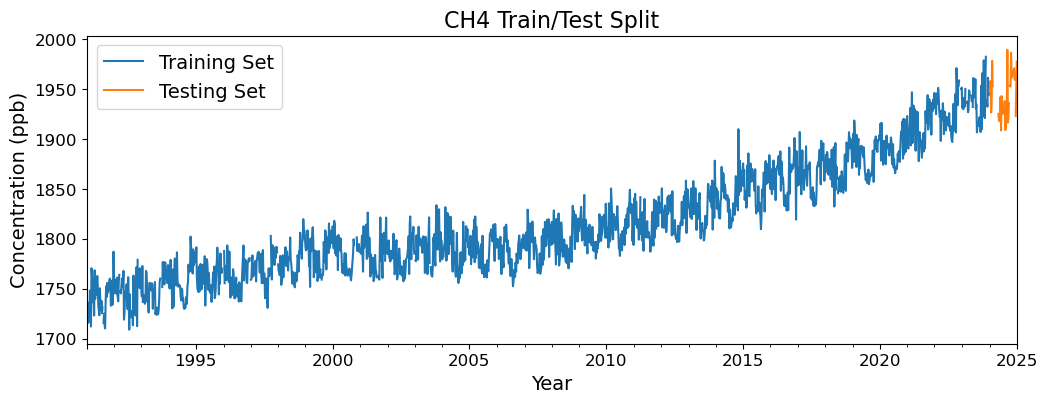

In [15]:
# visually confirm the data split

fig, ax = plt.subplots(figsize=(12,4))
train['CH4'].plot(ax=ax, label='Training Set')
test['CH4'].plot(ax=ax, label='Testing Set')

ax.set_title('CH4 Train/Test Split', fontsize=16)
ax.set_ylabel('Concentration (ppb)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=14)
plt.show()

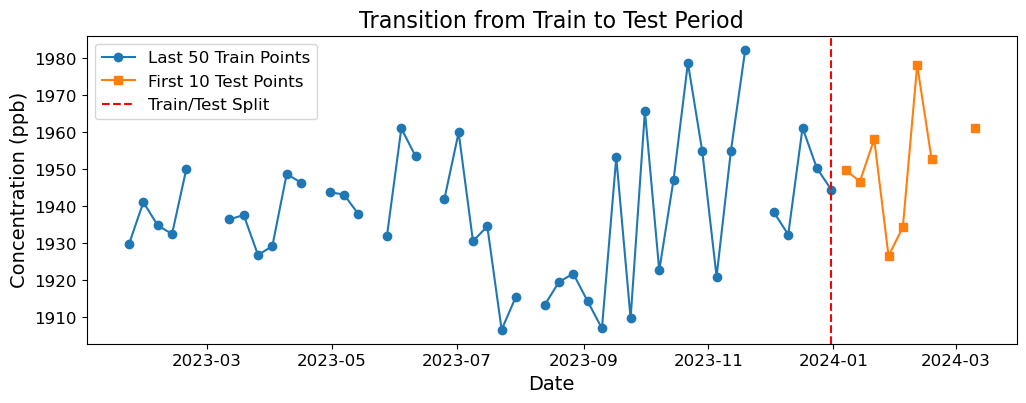

In [16]:
# Plot the transition from train to test

plt.figure(figsize=(12,4))
plt.plot(train['CH4'].index[-50:], train['CH4'].values[-50:], 
         label='Last 50 Train Points', marker='o')
plt.plot(test['CH4'].index[:10], test['CH4'].values[:10],
         label='First 10 Test Points', marker='s')
plt.axvline(x=train['CH4'].index[-1], color='red', linestyle='--', 
            label='Train/Test Split')

plt.title('Transition from Train to Test Period', fontsize=16)
plt.ylabel('Concentration (ppb)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='upper left',fontsize=12)
plt.show()

# Preprocessing and EDA of train set


[INFO] Fitting preprocessing for CH4
[INFO] Starting fit() for CH4 | Resample freq = None (using existing index)
Raw data: 1722 points, 37 NaNs
Trimmed data: 1722 points, 37 NaNs
Data range after trimming: 1991-01-06 00:00:00 to 2023-12-31 00:00:00
After resampling: 1722 points, 37 NaNs
[INFO] Found 30 potential outliers using robust STL residuals.
After outlier removal: 1722 points, 67 NaNs
After smoothing: 1722 points, 0 NaNs
After interpolation: 1722 points, 0 NaNs


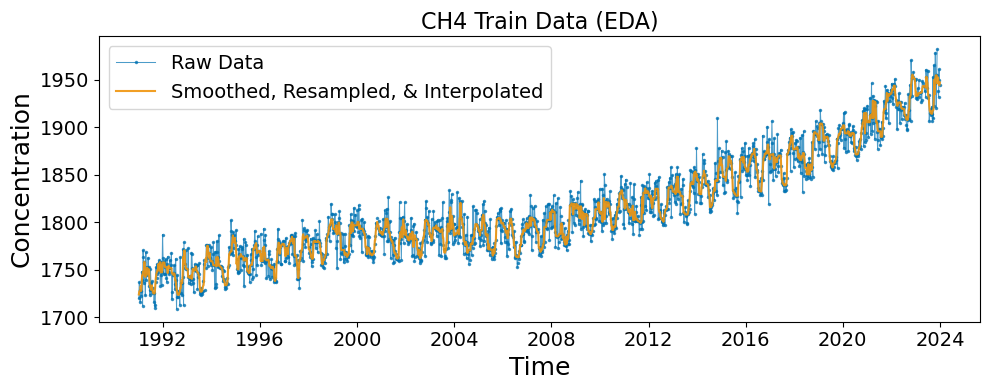

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -0.3406
ADF p-value 0.9196
KPSS statistic 5.8061
KPSS p-value 0.0100
the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


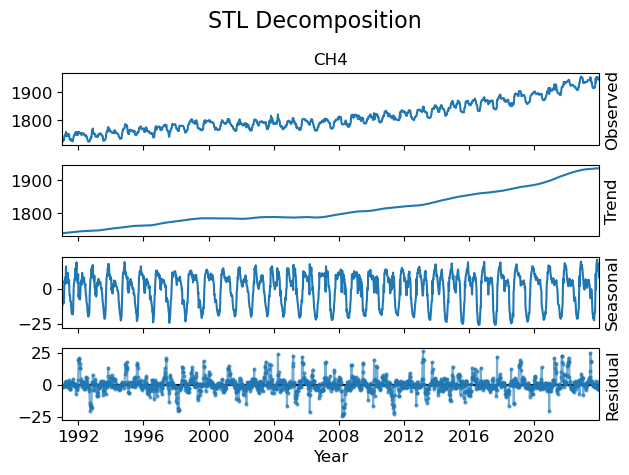

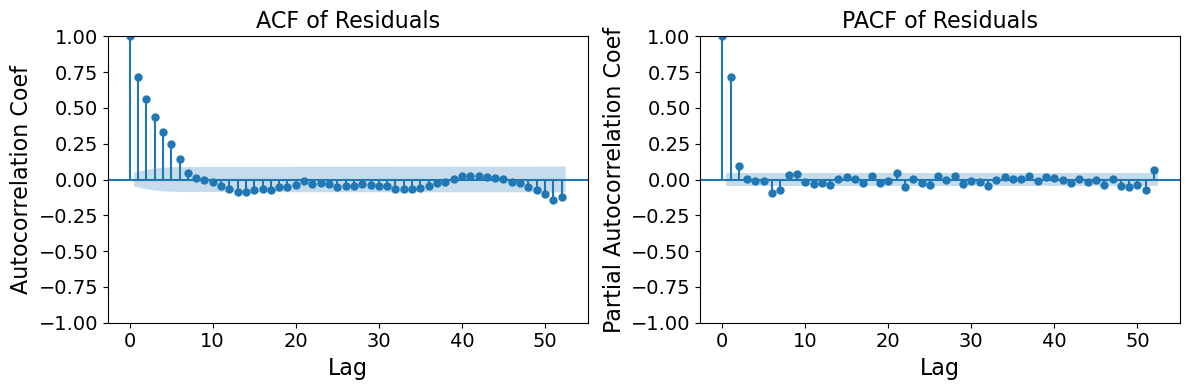


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.4836
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.7617
No heteroscedasticity detected (White test)
Adjusting test set dates to be contiguous with train set
[INFO] Dropping overlapping test point at 2023-12-31 00:00:00 (train end = 2023-12-31 00:00:00)


In [17]:
# fit and transform the training data to the GasPreprocessor class
# transform the test data using the fitted preprocessor

preprocessor = GasPreprocessor(
    gas_name='CH4', 
    iqr_factor=3.0,
    seasonal_period=52,
    do_eda=True
)

train_preprocessed = preprocessor.fit_transform(
    train[['CH4']], 
    custom_title = 'CH4 Train Data (EDA)'
)

# transform the test data using the fitted preprocessor
test_preprocessed = preprocessor.transform(test[['CH4']])

**Interpretation of STL decomposition**

- ADF/KPSS tests for stationarity:  Both tests indicate non-stationarity, which isn't surprising considering the strong positive trend.  However, the high ADF test p value suggests the presence of a unit root, which will likely require non-seasonal differencing.  
- Trend:  The positive trend of the preprocessed train data is consistent with that of the raw, full length data (see previous notebook, 2_ch4_eda_clean).  I will characterize the slope of the train_preprocessed data and determine if differencing is required to stationarize the data (is the global trend trend-stationary or differenc-stationary?). If the data is trend-stationary, then I could set the SARIMA model trend paramenter to 't' to simply subtract the linear increase in CH4 concentration.  However, a difference-stationary trend will require non-seasonal differencing (d).  
- Seasonal: the seasonal oscillations appear to be mostly uniform, likely additive and not multiplicative (see notebook 3_ch4_preprocessing_eda).  Log transformation may not be necessary.  Seasonal differencing (D) to handle drifts in seasonal peaks will be investigated by ACF/PACF plots and other statistical tests.
- Residual: Breusch-Pagan and White tests indicate homoscedastic residuals.  However, they appear to have volatility and may require modeling for reliable forecast confidence intervals (e.g. bootstrapping or GARCH).  Conditional heteroscedasticity will be evaluated with Engle's ARCH test on model residuals .  
- The slow decay in signficant ACF lags (1-6) and sharp cut off at PACF lag 1 suggests an AR(p) process, e.g. p = 1-6. 
- Significant spikes at lag 52 of both ACF and PACF plots could indicate a seasonal AR/MA process, e.g. P = 1, Q = 1-2.  

In [18]:
train_preprocessed.tail()

2023-12-03    1952.61250
2023-12-10    1947.39875
2023-12-17    1944.51750
2023-12-24    1944.51750
2023-12-31    1947.39875
Freq: W-SUN, Name: CH4, dtype: float64

In [19]:
test_preprocessed.head()

2024-01-07    1946.68750
2024-01-14    1948.25750
2024-01-21    1949.82750
2024-01-28    1949.77875
2024-02-04    1952.87000
Freq: W-SUN, Name: CH4, dtype: float64

In [20]:
# check length of each data series

print(f'length of train_preprocessed: {len(train_preprocessed)}')
print(f'Number of NaNs in train_preprocessed: {train_preprocessed.isna().sum()}')
print(f'length of test_preprocessed: {len(test_preprocessed)}')
print(f'Number of NaNs in test_preprocessed: {test_preprocessed.isna().sum()}')

length of train_preprocessed: 1722
Number of NaNs in train_preprocessed: 0
length of test_preprocessed: 52
Number of NaNs in test_preprocessed: 0


## Investigate trend of preprocessed train data (train_preprocessed)

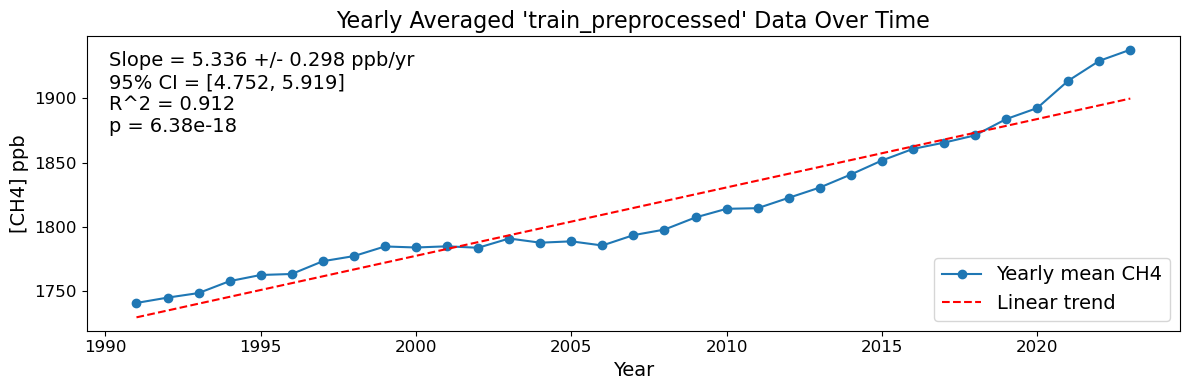

In [21]:
# convert the numpy object to a pandas DataFrame
train_preprocessed_df = pd.DataFrame(train_preprocessed, columns=['index', 'CH4'])

# calculate the yearly average
yearly_avg_df = train_preprocessed_df['CH4'].groupby(train_preprocessed_df.index.year).mean()

# calculate the slope
gas_trend_data = []

x = yearly_avg_df.index
y = yearly_avg_df

# linear regression
slope, intercept, r_value, p_value, std_err = linregress(x,y)

# predicted line
y_pred = intercept + slope * x

# confidence intervals
ci_lower = slope - 1.96 * std_err
ci_upper = slope + 1.96 * std_err

gas_trend_data_df = pd.DataFrame(gas_trend_data)

# plot the data
plt.figure(figsize=(12,4))
plt.plot(x, y, 'o-', label='Yearly mean CH4')
plt.plot(x, y_pred, 'r--', label='Linear trend')
plt.title("Yearly Averaged 'train_preprocessed' Data Over Time", fontsize=16)
plt.ylabel('[CH4] ppb', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# metrics text box
textstr = '\n'.join((
    f'Slope = {slope:.3f} +/- {std_err:.3f} ppb/yr',
    f'95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]',
    f'R^2 = {r_value**2:.3f}',
    f'p = {p_value:.2e}'
))

# place box on the figure
plt.gca().text(
    0.02, 0.95, textstr, transform=plt.gca().transAxes,
    fontsize=14, verticalalignment='top',
    bbox=dict(boxstyle='square,pad=0.4', facecolor='white', edgecolor='none')
)

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

**Interpretation of trend slope**

- The deterministic trend of the train_preprocessed data explains 91.2% of the variability in the data and is statistically significant.
- The slope does not deviate much from the full un-preprocessed data:
  - slope = 5.508 +/- 0.295 ppb/year
  - R^2 = 0.916
  - p = 9.22e-19

Either:
- 91.2% of the data variance is explained by a deterministic trend and 8.8% of the variance due to stochastic processes.
- or, it could possibly be a stochastic trend with structural drift changes.  

## Determine if seasonal cycles are multiplicative

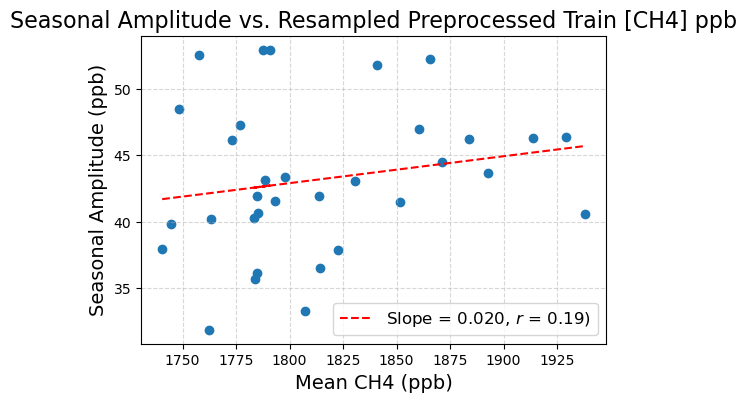

In [22]:
# plot amplitude of the seasonal cycle vs mean CH4 concentration for the preprocessed CH4 train data.  
# if the seasonal cycles do not scale with the long term mean, then the cycles are additive
# if the seasonal cycles scale with the mean, then the cycles are multiplicative 

# convert the pandas series to a DataFrame
train_prepro_df = train_preprocessed.to_frame(name='CH4')
train_prepro_df['year'] = train_prepro_df.index.year

# Group by year to compute mean and amplitude
yearly = train_prepro_df.groupby('year')['CH4'].agg(['mean', 'max', 'min'])
yearly['amplitude'] = yearly['max'] - yearly['min']

# calculate the regression line
x = yearly['mean'].values
y = yearly['amplitude'].values
m, b = np.polyfit(x, y, 1)

# calculate the correlation coefficient (r)
corr = yearly['mean'].corr(yearly['amplitude'])

# Scatter plot: mean vs amplitude
plt.figure(figsize=(6,4))
plt.scatter(yearly['mean'], yearly['amplitude'])
plt.plot(x, m*x + b, 
         color='red', 
         linestyle='--', 
         label=f'Slope = {m:.3f}, $r$ = {corr:.2f})')
plt.xlabel('Mean CH4 (ppb)', fontsize=14)
plt.ylabel('Seasonal Amplitude (ppb)', fontsize=14)
plt.title('Seasonal Amplitude vs. Resampled Preprocessed Train [CH4] ppb', fontsize=16)

# plt.plot(corr)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right', fontsize=12)
plt.show()

**Interpretation of the seasonal amplitude vs mean preprocessed CH4 plot:**

- cleaned, full length data: slope = 0.059, r = 0.36 (see notebook 3_ch4_preprocessing_eda)
- resampled preprocessed train data: slope = 0.020, r = 0.19

The resampled preprocessed train data is what will be modeled and will focus on these results.  Outlier removal, smoothing and interpolation made seasonal amplitude even more uniform.  

- A slope of 0.020 indicates a weak relationship between seasonal amplitude and mean.
- r = 0.19 and r^2 = 0.036 indicates that the mean explains only 3.6% of the variation in seasonal amplitude

The low values for slope and the correlation coefficient suggests that the seasonality does not need to be modeled as multiplicative (changing variance of the seasonal amplitude with the increasing CH4 concentration).  So, transformation likely won't be necessary.  

## Investigate the need for non-seasonal differencing

- slope, r^2, p value review
- ADF/KPSS review
- ACF/PACF plot and signficiant lags of non-differenced and non-seasonally differenced data
- minimum variance principle 

**Global trend slope review**
- slope = 5.3 +/- 0.3 ppb/year
- R^2 = 0.912
- p = 6.4e-18

**ADF/KPSS tests review**

The following results are copy/pasted here from the GasPreprocessor class analytics (see above):

- ADF test
  - ADF statistic -0.3406
  - ADF p-value 0.9196
<br>
<br>
- KPSS test
  - KPSS statistic 5.8061
  - KPSS p-value 0.0100

the Processed Data time series is non-stationary according to ADF and KPSS tests

**Interpretation**
While the slope R^2 = 0.912 indicates a strong global trend, the ADF and KPSS results indicate the need for differencing.  The ADF test fails to reject the null hypothesis of non-stationarity (presence of a unit root) and the KPSS test rejects the null hyothesis of stationarity.  So, the trend behaves more like a random walk with drift, a stochastic process.  Furthermore, atmospheric CH4 concentration has not followed a simple linear trajectory.  There was a stable period (~ 2000 - 2007) followed by an increase in the concentration rate.  So, a purely deterministic model with a single fixed slope wouldn't model these shifts very well.  

I will inspect the ACF and PACF plots of both non-differenced and differenced data to better understand if differencing is necessary rather than simply subtracting the trend during modeling (trend = 't').  

Original series length: 1722
Non-seasonally differenced series length: 1721

=== Stationarity tests ===

--- Non-Differenced Preprocessed Train Data ---
ADF and KPSS tests for non-differenced:
ADF statistic -0.2679
ADF p-value 0.9299
KPSS statistic 5.8062
KPSS p-value 0.0100
the non-differenced time series is non-stationary according to ADF and KPSS tests.


--- Non-Seasonally Differenced Preprocessed Train Data ---
ADF and KPSS tests for non-seasonally differenced:
ADF statistic -12.4675
ADF p-value 0.0000
KPSS statistic 0.0226
KPSS p-value 0.1000
the non-seasonally differenced time series is likely stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')
C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


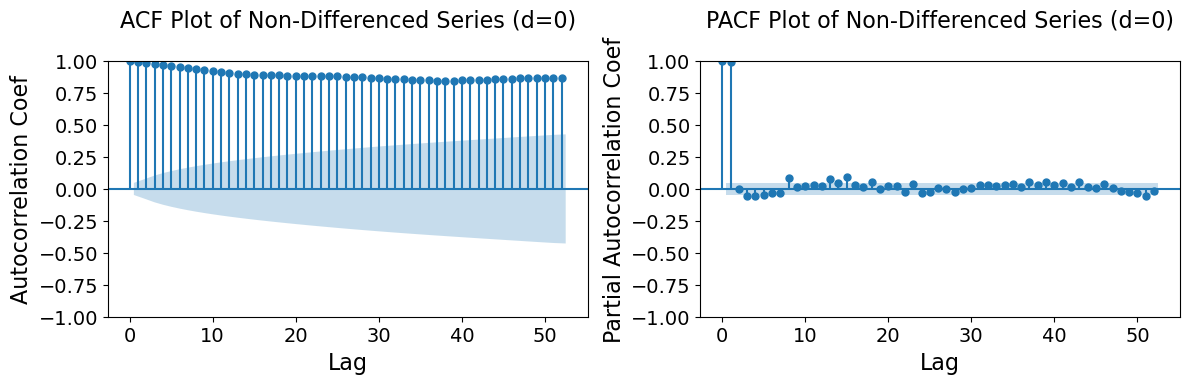

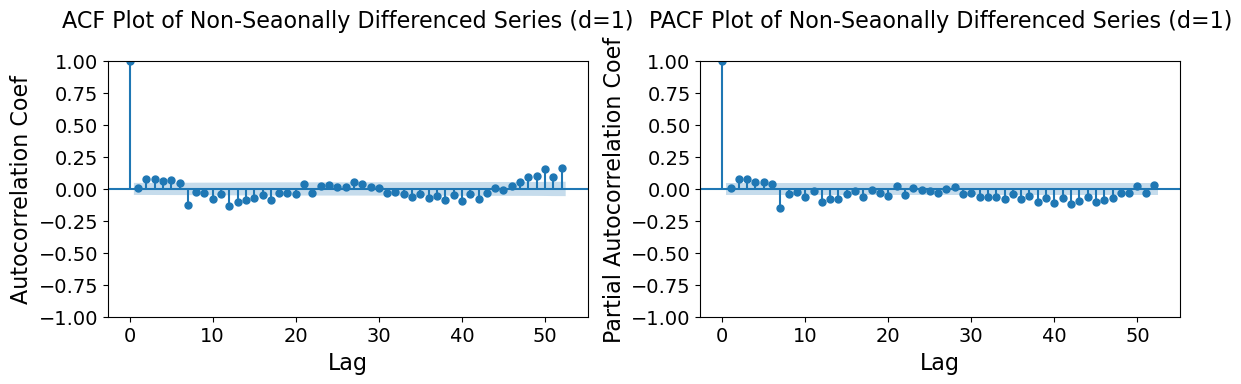

In [23]:
# inspect autocorrelation of non-differenced and non-seasonally differenced preprocessed train data 
# to determine its effectiveness in achieving stationarity 

nsdiffed_series = train_preprocessed.diff(1).dropna()

print(f'Original series length: {len(train_preprocessed)}')
print(f'Non-seasonally differenced series length: {len(nsdiffed_series)}')

# stationarity tests
print('\n=== Stationarity tests ===')
print('\n--- Non-Differenced Preprocessed Train Data ---')
preprocessor._run_stationarity_tests(train_preprocessed, 'non-differenced')

print('\n--- Non-Seasonally Differenced Preprocessed Train Data ---')
preprocessor._run_stationarity_tests(nsdiffed_series, 'non-seasonally differenced')

# plot ACF and PACF
preprocessor.plot_acf_pacf(train_preprocessed, 'Non-Differenced Series (d=0)')
preprocessor.plot_acf_pacf(nsdiffed_series, 'Non-Seaonally Differenced Series (d=1)')


In [24]:
# estimate the need for and number of non-seasonal differences
# with statsmodels "ndiffs"

d = ndiffs(train_preprocessed, test='kpss')
print(f'Estimated non-seasonal differences: d = {d}')

Estimated non-seasonal differences: d = 1


In [25]:
# Verify that d=1 is the correct degree of differencing (minimum variance principle)

# difference the series
nsdiff1 = train_preprocessed.diff().dropna()
nsdiff2 = nsdiff1.diff().dropna()

# determine the variance of each series: d=0, d=1, d=2
var_d0 = np.var(train_preprocessed)
var_d1 = np.var(nsdiff1)
var_d2 = np.var(nsdiff2)

print(f'variance at d=0: {var_d0:.3f}')
print(f'variance at d=1: {var_d1:.3f}')
print(f'variance at d=2: {var_d2:.3f}')

variance at d=0: 2994.229
variance at d=1: 24.075
variance at d=2: 47.706


In [26]:
# non-integer differencing to investigate possible over-differencing and to corroborate 
# d=1 as the best order of differencing.  

diffs = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
var_vals = {}

def fractional_diff_variance(series, d, threshold=1e-5):
    """Manually apply weights for a specific d to check variance."""
    n = len(series)
    weights = [1.0]
    for k in range(1, n):
        weights.append(-weights[-1] * (d - k + 1) / k)
    weights = np.array(weights)
    
    # Calculate the differentiated values (memory-weighted sum)
    res = np.zeros(n)
    for i in range(n):
        res[i] = np.dot(weights[:i+1], series[i::-1])
    
    return np.var(res[10:]) # Skip warm-up period for accuracy

# Run the loop again with the manual function
var_vals = {d: fractional_diff_variance(train_preprocessed.values, d) for d in diffs}
df_varvals = pd.DataFrame(list(var_vals.items()), columns=['d', 'variance'])
df_varvals

d     variance
0   0.0  2970.764944
1   0.2  6485.570970
2   0.4  2230.985863
3   0.6   364.053421
4   0.8    49.465046
5   1.0    24.060059
6   1.2    26.598007
7   1.4    29.270871
8   1.6    33.103756
9   1.8    39.170651
10  2.0    47.675235

In [27]:
# Diagnose non-seasonally differenced data to determine the need for a drift term for SARIMA models

diff1 = train_preprocessed.diff().dropna()
diff1.mean()

0.1297552295177221

**Interpretation of non-seasonal differrencing results**

- ADF and KPSS tests indicate stationarity after non-seasonal differencing (d=1)

ACF and PACF plots:
- ACF plot of non-differenced data shows a very gradual tapering of lags that are all signficicantly out of the CI band.  This is a signature of a unit root.
- Both ACF and PACF plots show significant spikes around lags 7 and 12.  These could indicate a periodic effect or a harmonic of a single seasonal cycle (i.e. 7 and 12 weeks are approximately 2 and 3 month periods).  I will need to consider high order non-seasonal SARIMA orders to clear these autocorrelations (e.g. p or q = 7).
- ACF rule of over-differencing:  If the first lag (lag 1) of the differenced series is not strongly negative (~ -0.5 or lower), then the data is not likely over-differenced.
- ACF plot of differenced data shows a significant spike around lag 52, which is absent in the PACF plot suggesting a seasonal MA (moving average) term, i.e. Q = 1.

best differencing order:
- two methods to determine the best differencing order both agree on d=1.
- fractional differencing does not improve/reduce variance in the train_preprocessed data

trend
- mean delta y of non-seaonally differenced data = 0.130 ppb/week
- this translates to 6.75 ppb/year (0.130 * 52)
- this value is consistent with the trend slope of 5.3 ppb/year
- conclusion:  need to use trend = 'c' for SARIMA models

## Investigate the need for seasonal differencing

NOTE: Since the global trend dominates the seasonal cycles, most analyses will be on the non-seasonal differenced data (d=1).  

1. Visualize Seasonal Subseries Plots:
Create a seasonal subseries plot to examine whether the seasonal pattern is stable over time.
- Stationary Seasonality: If each season (e.g., every January, every February) fluctuates around a constant mean for that specific month, the seasonality is likely deterministic and may not need differencing.
- Stochastic Seasonality: If the "mean" for a specific month is shifting or drifting over the years, the seasonal pattern is non-stationary, and a seasonal difference (e.g., \(Y_{t}-Y_{t-12}\)) is needed to stabilize it.
  
3. Conduct Formal Statistical Tests Use specialized statistical tests designed for seasonal unit roots to confirm your visual findings:
- OCSB Test (Osborn-Chui-Smith-Birchenhall): This is the standard test used to determine if a seasonal difference is necessary.
- HEGY Test (Hylleberg-Engle-Granger-Yoo): A more granular test that identifies whether a unit root exists at the zero frequency (trend) or at specific seasonal frequencies.
  
4. Rule of Thumb for Differencing
- Don't Over-Difference: Never use more than one seasonal difference (\(D=1\)). If you have already applied a non-seasonal difference (\(d=1\)), be cautious about applying \(D=1\) as well; the sum of \(d+D\) should generally not exceed 2.
- Lowest Standard Deviation: Often, the "best" order of differencing is the one that results in the lowest standard deviation of the differenced series. If seasonal differencing increases the series' variance, you have likely over-differenced. 

In [28]:
# Run the OCSB (Osborn, Chui, Smith, and Birchenhall) test to statistically determine if seasonal differencing is required

# estimate seasonal differences using OCSB test automatically
D = nsdiffs(train_preprocessed, m=52, test='ocsb')

print(f'Seasonal differences needed: D = {D}')

Seasonal differences needed: D = 0


In [29]:
# The global trend is much more substantial than the amplitudes of the seasonal cycles.
# So, I am running the OCSB test on the non-sesonally differenced data to check/confirm the previous result of D=0.  

# convert the numpy object to a DataFrame
nsdiffed_df = nsdiffed_series.to_frame(name='CH4_nsdif')

# estimate seasonal differences using OCSB test automatically where d=1
D = nsdiffs(nsdiffed_df['CH4_nsdif'], m=52, test='ocsb')

print(f'Seasonal differences needed (D): {D}')

Seasonal differences needed (D): 0


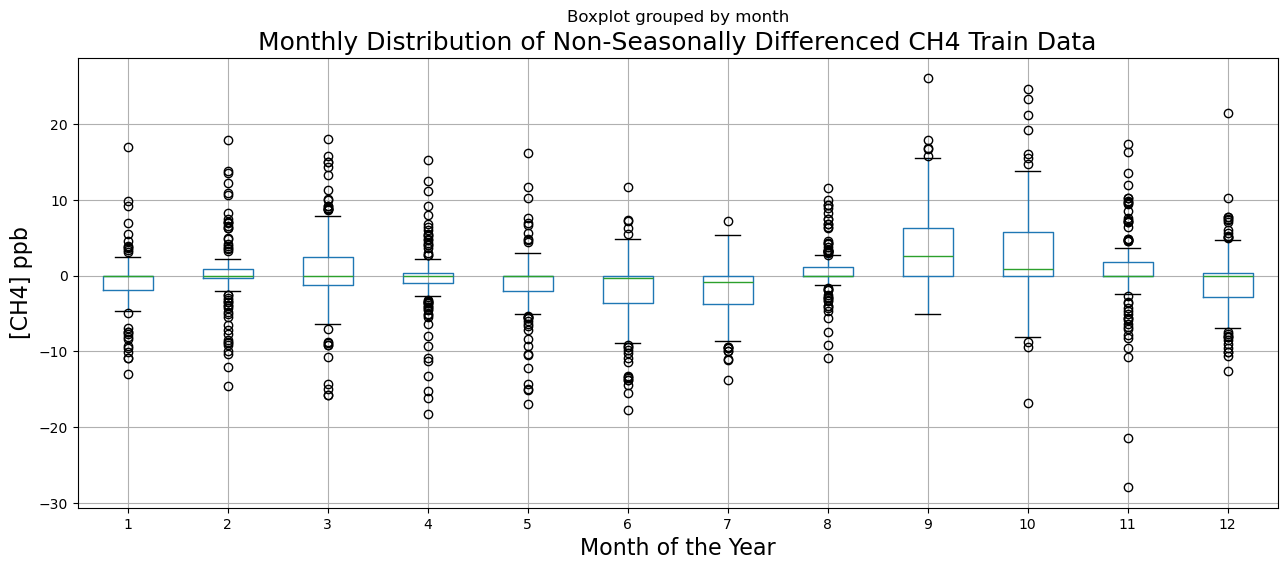

In [30]:
# boxplots of CH4 concentration distribution for each month for all ~ 40 years of train data

df_nsd = nsdiffed_series.to_frame(name='CH4_nsdif')

# extract ISO week (1-53) and year
df_nsd['month'] = df_nsd.index.month
df_nsd['year'] = df_nsd.index.year

# create a boxplot - grouping by week to visualize seasonal distribution
plt.figure(figsize=(15,6))
df_nsd.boxplot(column='CH4_nsdif', by='month', ax=plt.gca())
plt.title('Monthly Distribution of Non-Seasonally Differenced CH4 Train Data', fontsize=18)
plt.ylabel('[CH4] ppb', fontsize=16)
plt.xlabel('Month of the Year', fontsize=16)
plt.show()

**Interpretation of the box plot**

- The height of each box shows the total increase in CH4 concentration over the ~ 40 years of train set data per month.  

- The boxplots show that the median CH4 concentration (green line) sits consistently near 0 ppb for all months.  The distribution including quartiles, min/max values, and outliers fluctuate around a constant median.  

- Non-seasonal differencing has made the data stationary around a mean of zero.  The remaining seasonal pattern that remains appears to be stable (deterministic).

- This data corroborates the OCSB test regarding seasonal differencing, i.e. D=0. 

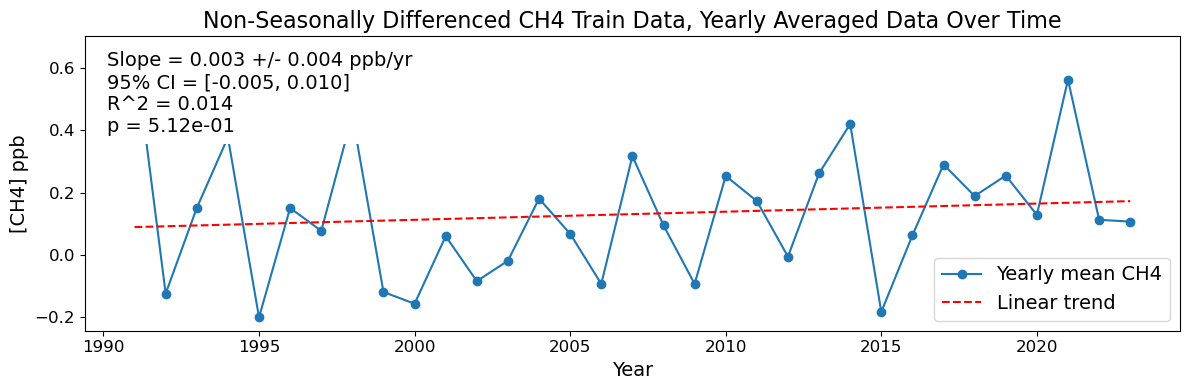

In [31]:
# calculate the yearly average of non-seasonally differenced train data
yearly_avg_df = df_nsd['CH4_nsdif'].groupby(df_nsd.index.year).mean()

# calculate the slope
gas_trend_data = []

x = yearly_avg_df.index
y = yearly_avg_df

# linear regression
slope, intercept, r_value, p_value, std_err = linregress(x,y)

# predicted line
y_pred = intercept + slope * x

# confidence intervals
ci_lower = slope - 1.96 * std_err
ci_upper = slope + 1.96 * std_err

gas_trend_data_df = pd.DataFrame(gas_trend_data)

# plot the data
plt.figure(figsize=(12,4))
plt.plot(x, y, 'o-', label='Yearly mean CH4')
plt.plot(x, y_pred, 'r--', label='Linear trend')
plt.title('Non-Seasonally Differenced CH4 Train Data, Yearly Averaged Data Over Time', fontsize=16)
plt.ylabel('[CH4] ppb', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# metrics text box
textstr = '\n'.join((
    f'Slope = {slope:.3f} +/- {std_err:.3f} ppb/yr',
    f'95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]',
    f'R^2 = {r_value**2:.3f}',
    f'p = {p_value:.2e}'
))

# place box on the figure
plt.gca().text(
    0.02, 0.95, textstr, transform=plt.gca().transAxes,
    fontsize=14, verticalalignment='top',
    bbox=dict(boxstyle='square,pad=0.4', facecolor='white', edgecolor='none')
)

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

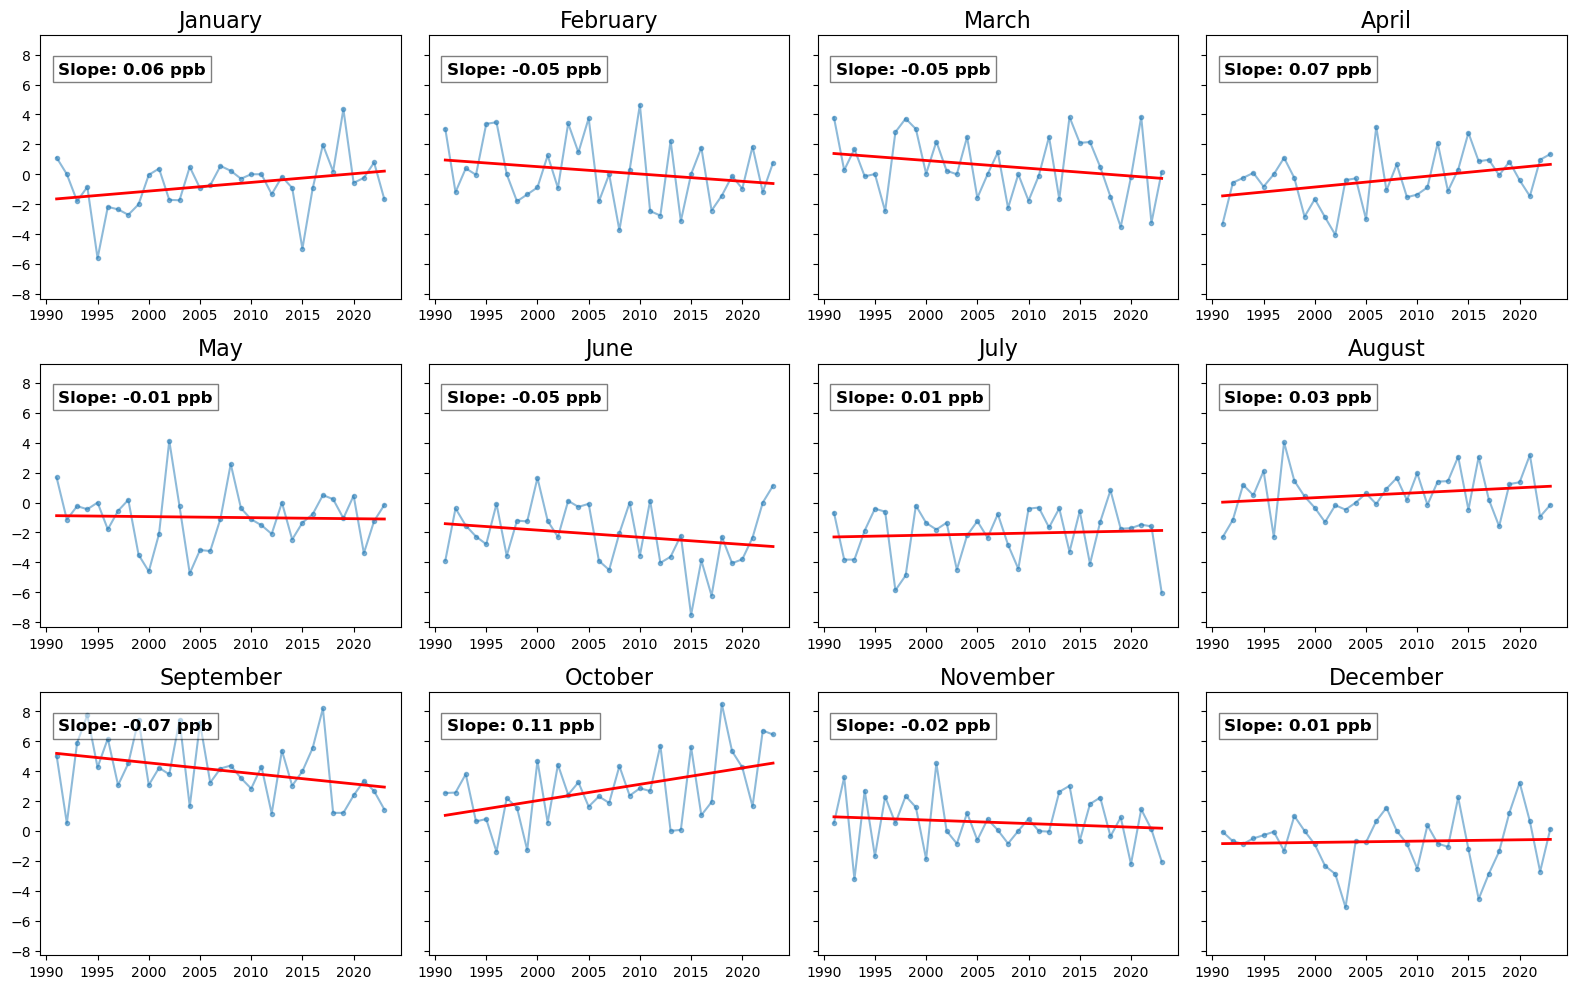

In [32]:
import calendar

# 1. Resample to monthly for clarity
df_monthly = df_nsd['CH4_nsdif'].resample('MS').mean().to_frame()
df_monthly['month'] = df_monthly.index.month
df_monthly['year'] = df_monthly.index.year

# 2. Plot with Slopes
fig, axes = plt.subplots(3, 4, figsize=(16, 10), sharey=True)
axes = axes.flatten()

for i, m in enumerate(range(1, 13)):
    subset = df_monthly[df_monthly['month'] == m].dropna()
    x = subset['year']
    y = subset['CH4_nsdif']
    
    # Calculate Slope (Linear Regression)
    slope, intercept = np.polyfit(x, y, 1)
    
    axes[i].plot(x, y, marker='o', markersize=3, alpha=0.5)
    axes[i].plot(x, slope*x + intercept, color='red', linewidth=2) # Trendline

    # place text 5% from left and 90% from bottom of each box
    axes[i].text(0.05, 0.9, f'Slope: {slope:.2f} ppb',
                 transform=axes[i].transAxes,
                 fontsize=12,
                 fontweight='bold',
                 verticalalignment='top',
                 bbox=dict(boxstyle=None, facecolor='white', alpha=0.5))
    # axes[i].set_title(f'Month {m}')
    axes[i].set_title(calendar.month_name[m], fontsize=16)

plt.tight_layout()
plt.show()

**Interpretation of the monthly trends (non-seasonally differenced CH4 train data)**

- global trend slope:
    - non-differenced data = 5.3 ppb/year (see "Investigate trend of preprocessed train data (train_preprocessed)" in this notebook)
    - non-seasonally differenced data = 0.003 ppb/year.  First differencing removed the global trend.
<br>
<br>
- The slope of the monthly trends are all close to zero and hover around the global slope of 0.003.  

- This analysis is a bit redundant with the boxplots but confirms and corroborates the boxplot that the seasonality is deterministic rather than stochastic, and the OCSB test result that no seasonally differencing is needed.  

**Seasonal differencing is not needed, D=0**

**Summary of trend and seaonality type analyses:**
- trend = deterministic + stochastic (d=1)
- seasonlity = deterministic (D=0)

## Periodogram to verify seasonal periodicity

In [33]:
nsdiffed_df.head()

CH4_nsdif
1991-01-13     3.3400
1991-01-20    -2.4325
1991-01-27     2.4325
1991-02-03     0.9050
1991-02-10    -0.9050

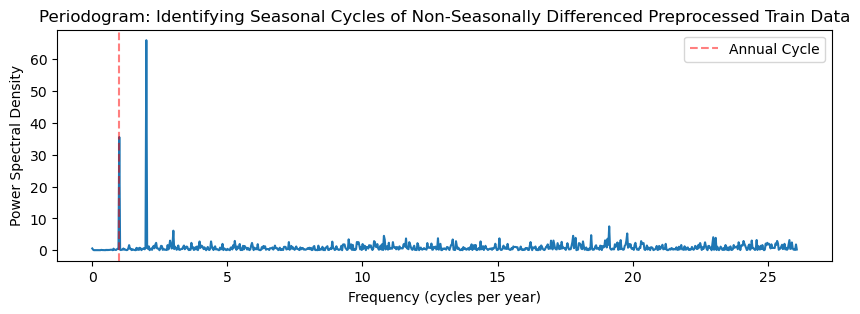

In [34]:
# Use a periodogram to dissect the annual cycle.
# Q: Are subseasonal cycles present that are not apparent?  Does non-seasonal differencing of preprocessed train data 
# alter the results and conclusion of the periodogram of the non-differenced full length data?  

from scipy.signal import periodogram

# weekly sampling frequency
fs = 52.18

# compute the periodogram
f, p = periodogram(nsdiffed_df['CH4_nsdif'], fs=fs, detrend=None)

# plot
plt.figure(figsize=(10,3))
plt.plot(f, p)
plt.title('Periodogram: Identifying Seasonal Cycles of Non-Seasonally Differenced Preprocessed Train Data')
plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Power Spectral Density')
plt.axvline(1.0, color='red', linestyle='--', alpha=0.5, label='Annual Cycle')
plt.legend()
plt.show()

**Interpretation of the periodogram**

- compared to the initial periodogram of the cleaned, full length data (see notebook 2_ch4_eda_clean, CH4 seaonal cycles), this plot shows no initial spike at frequency near zero.  This is a confirmation the non-seasonally differencing removed the low-frequency global trend and that further Seasonal differencing is inappropriate for this data, i.e. d=1, D=0.  
- The spike at 1 cycle per year (frequency) confirms the annual seasonal cycle annalyzed in the same noteobook and section (notebook 2_ch4_eda_clean, CH4 seaonal cycles).
- The spike at 2 cycles per year (lag 26) suggests that a simple annual model doesn't fully capture the seasonal/cyclical behavior.  ACF and PACF plots should help determine the best starting model parameters.  I may need to consider modeling the seasonal behavior as exogenous Fourier terms.  

## ACF/PACF plots to approximate model parameters


=== Stationarity tests ===

--- Non-Differenced Preprocessed Train Data (d=0,D=0) ---
ADF and KPSS tests for non-differenced (d=0,D=0):
ADF statistic -0.2679
ADF p-value 0.9299
KPSS statistic 5.8062
KPSS p-value 0.0100
the non-differenced (d=0,D=0) time series is non-stationary according to ADF and KPSS tests.


--- Non-Seasonally Differenced Preprocessed Train Data (d=1,D=0) ---
ADF and KPSS tests for non-seasonally differenced (d=1,D=0):
ADF statistic -12.4675
ADF p-value 0.0000
KPSS statistic 0.0226
KPSS p-value 0.1000
the non-seasonally differenced (d=1,D=0) time series is likely stationary according to ADF and KPSS tests.


--- Seasonally Differenced Preprocessed Train Data (d=0,D=1) ---


C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')
C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')
C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


ADF and KPSS tests for seasonally differenced (d=0,D=1):
ADF statistic -5.4863
ADF p-value 0.0000
KPSS statistic 1.3261
KPSS p-value 0.0100
the seasonally differenced (d=0,D=1) time series may be difference-stationary according to ADF and KPSS tests.


--- Non-Seasonally + Seasonally Differenced Preprocessed Train Data (d=1,D=1) ---
ADF and KPSS tests for non-seasonally + seasonally differenced (d=1,D=1):
ADF statistic -12.2568
ADF p-value 0.0000
KPSS statistic 0.0267
KPSS p-value 0.1000
the non-seasonally + seasonally differenced (d=1,D=1) time series is likely stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


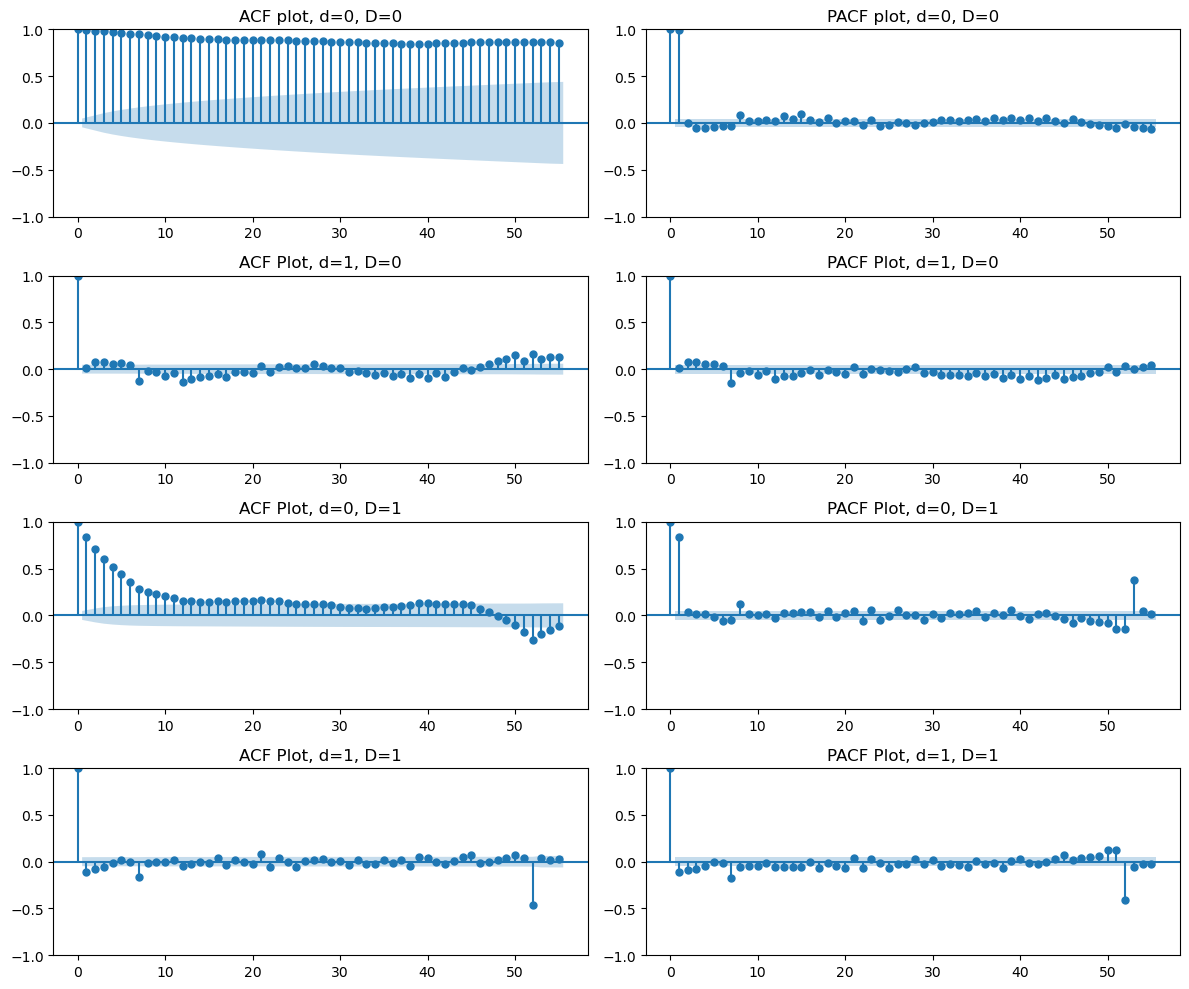

In [35]:
# I will run ADF/KPSS tests and ACF/PACF plots for several combinations of differencing for direct comparison.  
# Based on previous analyses, the tests on d=1,D=0 should be the most informative for model specification.  

nsdiffed_series = train_preprocessed.diff().dropna()
sdiffed_series = train_preprocessed.diff(52).dropna()
snsdiffed_series = nsdiffed_series.diff(52).dropna()

# run stationarity tests
print('\n=== Stationarity tests ===')
print('\n--- Non-Differenced Preprocessed Train Data (d=0,D=0) ---')
preprocessor._run_stationarity_tests(train_preprocessed, 'non-differenced (d=0,D=0)')

print('\n--- Non-Seasonally Differenced Preprocessed Train Data (d=1,D=0) ---')
preprocessor._run_stationarity_tests(nsdiffed_series, 'non-seasonally differenced (d=1,D=0)')

print('\n--- Seasonally Differenced Preprocessed Train Data (d=0,D=1) ---')
preprocessor._run_stationarity_tests(sdiffed_series, 'seasonally differenced (d=0,D=1)')

print('\n--- Non-Seasonally + Seasonally Differenced Preprocessed Train Data (d=1,D=1) ---')
preprocessor._run_stationarity_tests(snsdiffed_series, 'non-seasonally + seasonally differenced (d=1,D=1)')

# ACF and PACF plots
fig, axes = plt.subplots(4,2, figsize = (12,10))

plot_acf(train_preprocessed, lags=55, ax=axes[0,0], title='ACF plot, d=0, D=0')
plot_pacf(train_preprocessed, lags=55, ax=axes[0,1], title='PACF plot, d=0, D=0')

plot_acf(nsdiffed_series.values, lags=55, ax=axes[1,0], title='ACF Plot, d=1, D=0')
plot_pacf(nsdiffed_series.values, lags=55, ax=axes[1,1], title='PACF Plot, d=1, D=0')

plot_acf(sdiffed_series.values, lags=55, ax=axes[2,0], title='ACF Plot, d=0, D=1')
plot_pacf(sdiffed_series.values, lags=55, ax=axes[2,1], title='PACF Plot, d=0, D=1')

plot_acf(snsdiffed_series.values, lags=55, ax=axes[3,0], title='ACF Plot, d=1, D=1')
plot_pacf(snsdiffed_series.values, lags=55, ax=axes[3,1], title='PACF Plot, d=1, D=1')

plt.tight_layout()
plt.show()

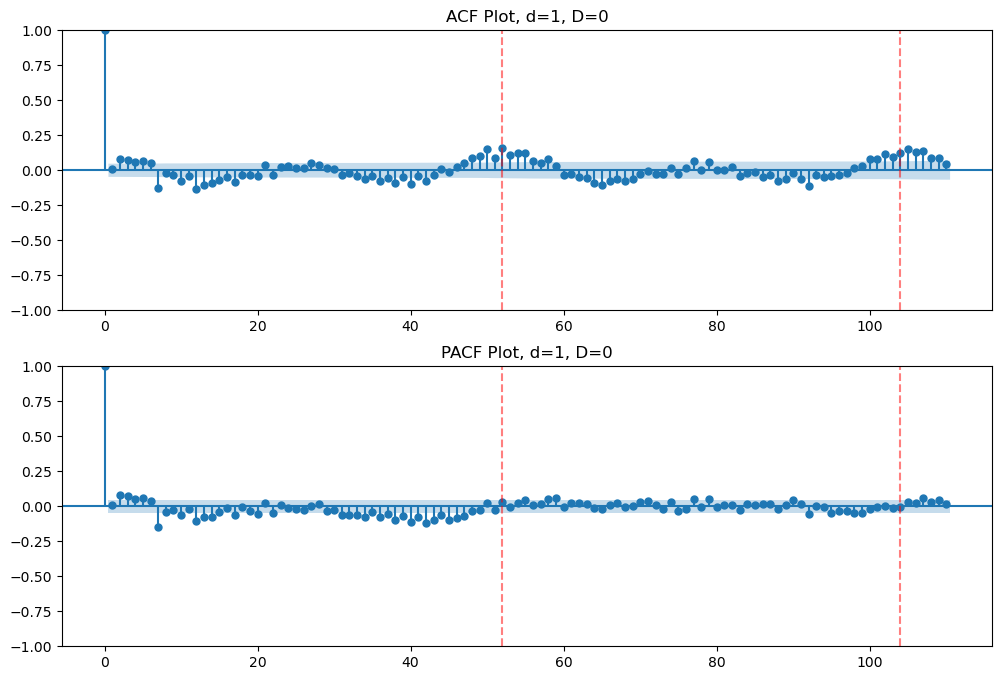

In [38]:
# Focuse on the non-seasonally differenced data for a more clear estimation of model parameters 
# and to further investigate the 1 and 2 cycles/year result of the periodogram.  

fig, axes = plt.subplots(2,1, figsize=(12,8))

plot_acf(nsdiffed_series.values, lags=110, ax=axes[0], title='ACF Plot, d=1, D=0')
axes[0].axvline(x=52, color='red', linestyle='--', alpha=0.5, label='Lag 104')
axes[0].axvline(x=104, color='red', linestyle='--', alpha=0.5, label='Lag 52')

plot_pacf(nsdiffed_series.values, lags=110, ax=axes[1], title='PACF Plot, d=1, D=0')
axes[1].axvline(x=52, color='red', linestyle='--', alpha=0.5, label='Lag 104')
axes[1].axvline(x=104, color='red', linestyle='--', alpha=0.5, label='Lag 52')
plt.show()

**Interpretation of the stationarity tests and ACF and PACF plots**

**d=0,D=0** 
- stationarity tests: ADF and KPSS tests suggest difference stationarity.
- ACF and PACF plots: Very gradual decay of lags in the ACF plot is a sign of unit root and needs non-seasonal differencing, as previously determined.  PACF plot has a sharp cutoff at lag 1 indicating an AR(1) structure for non-differenced data. 

**d=1,D=0:**  
- stationarity tests: Both ADF and KPSS tests indicate stationarity after non-seasonal differencing only.  Therefore, seasonal differencing is likely unnecessary.
- ACF and PACF plots: Both plots show an immediate sharp cutoff with a only a few signficiant non-seasonal lags, primarily around 7 and 12. No significant cutoff in the PACF plot suggests a low order MA process (MA(1)) or a low order mixed ARMA proces (ARMA(1,1)).  For seasonal structure, lag 52 is signficant in the ACF but not PACF.  The second set of ACF/PACF plots with expanded lag coverage helps to determine initial seasonal parameters for a SARIMA model.  The gradual tapering at lags 52 and 104 on the ACF plot and no sharp cutoff at seasonal lags on the PACF plot suggests a seasonal auto regressive process (SAR) and should start with P=1, D=0, Q=0.  

**d=0,D=1:**
- stationarity tests:  Both tests indicate that the seasonally differernced series is non-stationary. 
- ACF and PACF plots: The gradual decay of significant lags indicate that a non-stationary trend remains.  

**d=1,D=1:**  
- stationarity tests:  ADF and KPSS tests indicate stationarity, likely due to d=1.
- ACF and PACF plots: Significant negative spikes at lags 52 and 104 (seasonal lags) suggest possible over-differencing.

**Model order estimation** - The ACF and PACF plots of the non-seasonally differenced preprocessed train data (d=1,D=0) provide an estimation of the model orders:
- (0-7,1,0-1)(1,0,0,52) - to handle the ACF spike at lag 7
- I will also consider an ARIMAX model with Fourier terms to model the seasonal structure.  This may require two set of Fourier terms based on the periodogram results of two peaks (see periodogram above).  

**Interpretation of the CH4 train series preprocessing and EDA**

Preprocessing the CH4 data appears to be effectively handling resampling, outliers, and interpolation while preserving the seasonality and trend.  

**Stationarity** - STL decomposition provides visual confirmation of the positive global trend and the regular, annual seasonality of atomospheric CH4 concentration.  The ADF and KPSS tests confirm that the data series is not stationary, consistent with the apparent positive trend and linear regression metrics. ADF and KPSS tests, ACF and PACF plots, and minimal variance testing of non-integer values of non-seasonal differencing (d) all indicate that d = 1 is necessary to stationarize the data for ARIMA type modeling and forecasting.  The global trend is a combination of deterministic and stochastic processes.   

**Heteroscedasticity** - both the Breusch-Pagan and White tests indicate that the STL residuals are not heteroscedastic, which is consistent with what was observed for the full length data.  

**Seasonality** - The seasonal cycle amplitude vs preprocessed CH4 concentration show a very mild positive trend indicating that seasonality is additive.  So, transformation is likely unnecessary, but may be tested for possible improvements in modeling performance.  OCSB tests, data distribution for each month, ADF and KPSS tests, and ACF and PACF plots all agree that the seasonal trend is deterministic and, therefore, does not require differencing (D = 0)

## Investigate the need for variance stabilization 

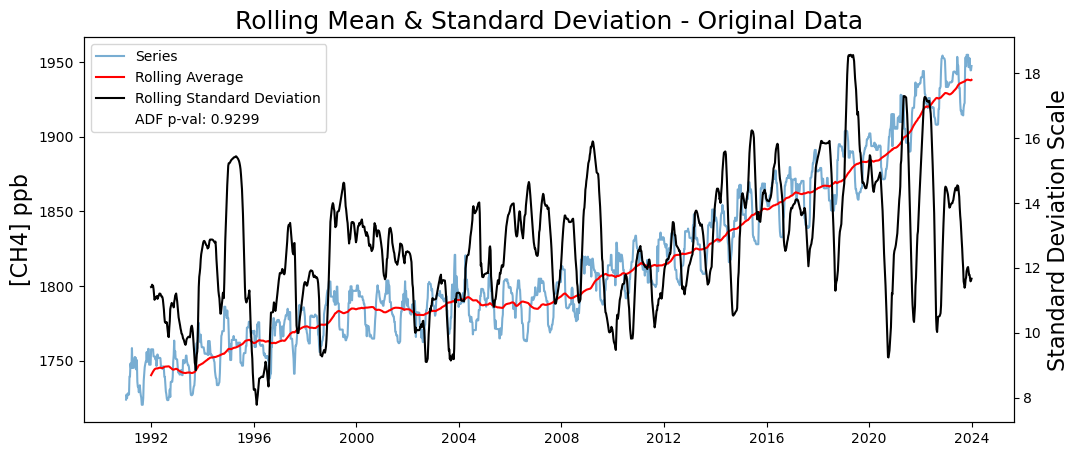

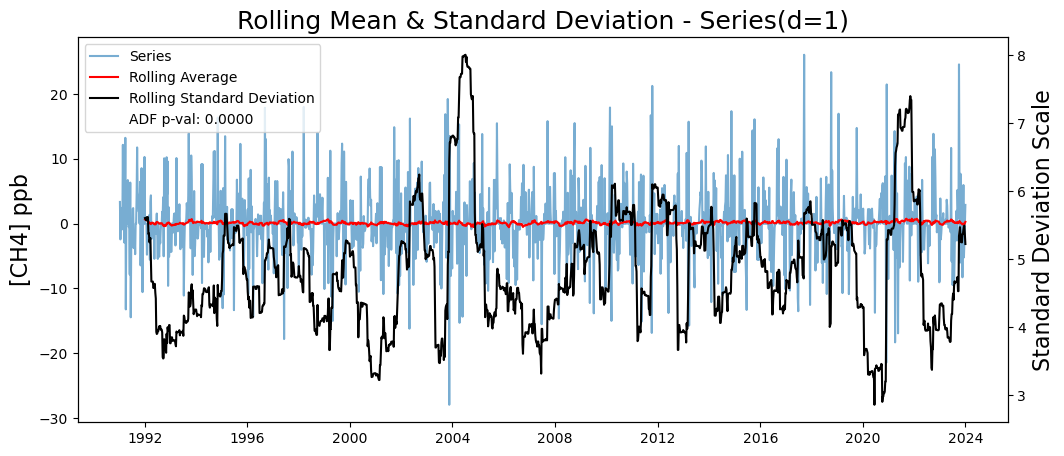

In [179]:
# rolling mean and standard deviation with twin axis plots

series = train_preprocessed
series_diff = train_preprocessed.diff().dropna()

def plot_with_adf(data, title):
    # calculate stats
    rolling_avg = data.rolling(window=52).mean()
    rolling_std = data.rolling(window=52).std()

    adf_result = adfuller(data)
    p_val = adf_result[1]

    # plot
    fig, ax1 = plt.subplots(figsize=(12,5))

    # left axis - series and mean
    line1, = ax1.plot(data, label='Series', color='tab:blue', alpha=0.6)
    line2, = ax1.plot(rolling_avg, label='Rolling Average', color='red')
    ax1.set_ylabel('[CH4] ppb', fontsize=16)

    # right axis - standard deviation
    ax2 = ax1.twinx()
    line3, = ax2.plot(rolling_std, label='Rolling Standard Deviation', color='black')
    ax2.set_ylabel('Standard Deviation Scale', fontsize=16)

    # CORRECTED LEGEND LOGIC
    # 1. Collect all handles (the lines)
    handles = [line1, line2, line3]
    
    # 2. Collect all labels
    labels = [line.get_label() for line in handles]
    
    # 3. Add the ADF p-value as a custom label
    labels.append(f'ADF p-val: {p_val:.4f}')
    # Add a "blank" proxy artist for the ADF label so the lists match length
    from matplotlib.patches import Patch
    handles.append(Patch(visible=False)) 

    ax1.legend(handles, labels, loc='upper left')

    plt.title(title, fontsize=18)
    plt.show()
    
# plot original 
plot_with_adf(series, 'Rolling Mean & Standard Deviation - Original Data')

# plot non-seasonally differenced data
plot_with_adf(series_diff, 'Rolling Mean & Standard Deviation - Series(d=1)')

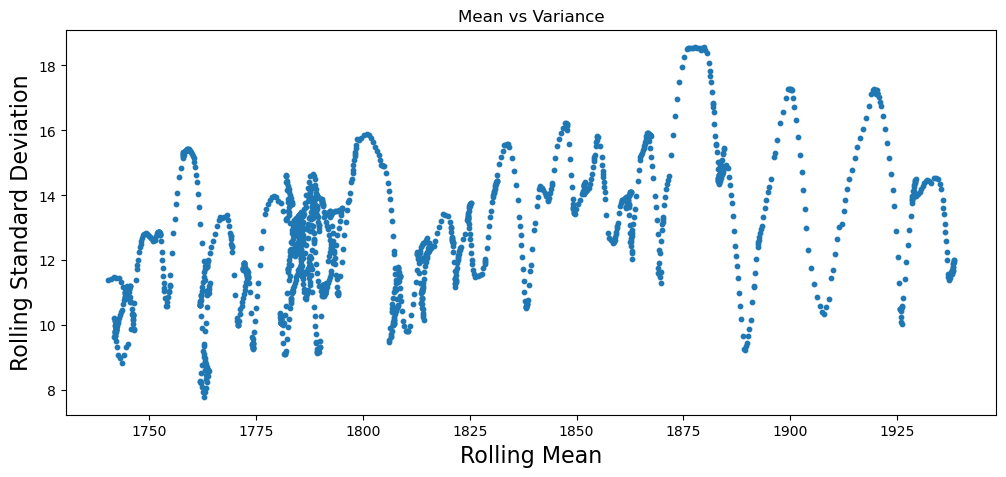

In [189]:
# plot rolling standard deviation vs rolling mean

rolling_avg = train_preprocessed.rolling(window=52).mean()
rolling_std = train_preprocessed.rolling(window=52).std()

plt.figure(figsize=(12,5))
plt.scatter(rolling_avg, rolling_std, s=10)
plt.xlabel('Rolling Mean', fontsize=16)
plt.ylabel('Rolling Standard Deviation', fontsize=16)
plt.title('Mean vs Variance')
plt.show()

In [190]:
# use scipy Boxcox to investigate possible transformation method
# - lambda = 1: no transformation necessary
# - lambda = 0: log transformation
# - lambda = 0.5: square root transformation
# - lambda = -1: reciprocal transformation

transformed_series, best_lambda = boxcox(train_preprocessed)

print(f"Optimal Lambda: {best_lambda:.4f}")

Optimal Lambda: -11.1420


**Interpretation of variance analysis**

- Variance does not increase with the mean.
- the mean vs variance plot wave pattern suggests cyclic behavior/seasonality in the variance
- transformations like log and Box-Cox are primarily to fix heteroscedasticity (variance that grows with the mean)
- optimal lambda = -11: this is an extreme value and may be due to the strong trend in the data with stable local variance.  

So, I will not transform the data and may need to apply seasonal differencing and a SARIMA model

# Save the preprocessed train and test data

In [36]:
print(train.index[:5])
print(train_preprocessed.index[:5])

DatetimeIndex(['1991-01-06', '1991-01-13', '1991-01-20', '1991-01-27',
               '1991-02-03'],
              dtype='datetime64[ns]', freq='W-SUN')
DatetimeIndex(['1991-01-06', '1991-01-13', '1991-01-20', '1991-01-27',
               '1991-02-03'],
              dtype='datetime64[ns]', freq='W-SUN')


In [37]:
# Add back value_unc and qcflag
# the preprocessed data will be added as a new column in a DataFrame with value_unc and qcflag

# rename the preprocessed data for the DataFrame column name
train_preprocessed = train_preprocessed.rename('CH4_preprocessed')
test_preprocessed = test_preprocessed.rename('CH4_preprocessed')

# convert to DataFrame
train_preprocessed_df = pd.DataFrame(train_preprocessed)
test_preprocessed_df = pd.DataFrame(test_preprocessed)

# merge metadata (qcflag, value_unc) using nearest original observation, which is the resampled data dates
train_preprocessed_df = pd.merge_asof(
    left=train_preprocessed_df.sort_index(),
    right=train[['value_unc', 'qcflag']].sort_index(),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta('3D') # nearest +/- 3 days
)

test_preprocessed_df = pd.merge_asof(
    left=test_preprocessed_df.sort_index(),
    right=test[['value_unc', 'qcflag']].sort_index(),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta('3D')
)

In [38]:
train_preprocessed_df.tail()

CH4_preprocessed  value_unc qcflag
2023-12-03        1952.61250      0.575    ...
2023-12-10        1947.39875      0.575    ...
2023-12-17        1944.51750      0.575    ...
2023-12-24        1944.51750      0.575    ...
2023-12-31        1947.39875      0.575    ...

In [39]:
test_preprocessed_df.head()

CH4_preprocessed  value_unc qcflag
2024-01-07        1946.68750      0.575    ...
2024-01-14        1948.25750      0.575    ...
2024-01-21        1949.82750      0.575    ...
2024-01-28        1949.77875      0.575    ...
2024-02-04        1952.87000      0.575    ...

The train and test indexes are different from those of train_preprocessed and test_preprocessed because of resampling for regular weekly frequency by the GasPreprocessor class.  Since the GasPreprocessor was fit only on the CH4 (value) column, value_unc and qcflag data remain aligned to the original, irregular timestamps.  

To align these ancillary variables with the new weekly time base, pd.merge_asof() is used to join them to the nearest resampled index. The tolerance=pd.Timedelta('3D') parameter specifies that only matches within ±3 days of each resampled timestamp are accepted.

If no value_unc or qcflag observation exists within that 3-day window, the corresponding cell remains NaN. These NaN values indicate weeks without a nearby original measurement. Because these are ancillary variables used for optional weighting or quality control rather than core model features, the NaNs are left in place for now.

In [40]:
# verify dataset dimensions

print('train shape:', train.shape)
print('test shape:', test.shape)

print('train_preprocessed shape:', train_preprocessed.shape)
print('test_preprocessed shape:', test_preprocessed.shape)

print('train_preprocessed_df shape:', train_preprocessed_df.shape)
print('test_preprocessed_df shape:', test_preprocessed_df.shape)

train shape: (1722, 3)
test shape: (53, 3)
train_preprocessed shape: (1722,)
test_preprocessed shape: (52,)
train_preprocessed_df shape: (1722, 3)
test_preprocessed_df shape: (52, 3)


**Verify lengths of datasets:**

- Train: 1722 weeks (1722 weeks / 52 weeks/year = 33 years)
- Test: 52 weeks (52 weeks / 52 weeks/year = 1 year)
- The sum of weeks = 1774, which is 34 years. The cleaned CH4 data series spans 1991-2025, which is 34 years.

In [41]:
# Check the last training point vs first test point after preprocessed both series. 

print('Last train date:', train.index[-1])
print('First test date:', test.index[0])
print('Gap between train end and test start:', test.index[0] - train.index[-1])

print('\nLast train_preprocessed date:', train_preprocessed.index[-1])
print('First test_preprocessed date:', test_preprocessed.index[0])
print('Gap between train end and test start:', test_preprocessed.index[0] - train_preprocessed.index[-1])

print('\nLast train_preprocessed_df date:', train_preprocessed_df.index[-1])
print('First test_preprocessed_df date:', test_preprocessed_df.index[0])
print('Gap between train end and test start:', test_preprocessed_df.index[0] - train_preprocessed_df.index[-1])

Last train date: 2023-12-31 00:00:00
First test date: 2024-01-07 00:00:00
Gap between train end and test start: 7 days 00:00:00

Last train_preprocessed date: 2023-12-31 00:00:00
First test_preprocessed date: 2024-01-07 00:00:00
Gap between train end and test start: 7 days 00:00:00

Last train_preprocessed_df date: 2023-12-31 00:00:00
First test_preprocessed_df date: 2024-01-07 00:00:00
Gap between train end and test start: 7 days 00:00:00


In [42]:
from pathlib import Path

# define output path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

In [43]:
# save the preprocessed train data including 'CH4' (formerly 'value'), 'value_unc', and 'qcflag'
output_path = output_dir / 'CH4_train_preprocessed.csv'
(
    train_preprocessed_df
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

# save the preprocessed test data including 'CH4' (formerly 'value'), 'value_unc', and 'qcflag'
output_path = output_dir / 'CH4_test_preprocessed.csv'
(
    test_preprocessed_df
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

print(f'CH4_train_preprocessed data saved to:\n{output_path}')
print(f'Shape: {train_preprocessed_df.shape}')
print(f'\nCH4_test_preprocessed data saved to:\n{output_path}')
print(f'Shape: {test_preprocessed_df.shape}')

CH4_train_preprocessed data saved to:
..\data\processed\CH4_test_preprocessed.csv
Shape: (1722, 3)

CH4_test_preprocessed data saved to:
..\data\processed\CH4_test_preprocessed.csv
Shape: (52, 3)


# SECTION 2:  IN-SAMPLE SCREENING (AIC/BIC)

## SARIMA models 

In [71]:
# Focus the model search on the d=1, D=0 and ACF/PACF results
# I will restrict non-seasonal and seasonal AR orders to 3 based on the ACF and PACF plots of d=1 train_preprocessed data, 
# and to avoid overfitting the data.  
# These plots have significant spikes at lags 7 and 12, which may be artificacts of seasonal harmonics.  

def candidate_sarima_models():
    '''    
    Generate SARIMA candidates consistent with diagnostics:
    - d = 1 (trend)
    - D = 0 (no seasonal differencing)
    - seasonal AR (broad ACF hump)
    - small nonseasonal AR/MA
    '''
    models = []
    
    # non-seasonal AR orders 
    for p in range(0, 4):
        # non-seasonal MA 
        for q in range(0, 2):
            # seasonal orders based on broad seasonal hump in ACF plot (but not PACF)
            for P in range(0, 3):
                for D in [0,1]:
                    for Q in range(0, 2):
                        # trend settings
                        for trend in ['n', 'c']:
                            models.append({
                                'order': (p, 1, q),
                                'seasonal_order': (P, D, Q, 52),
                                'trend': trend
                            })
    return models

sarima_models = candidate_sarima_models()
print(f'Generated {len(sarima_models)} models for evaluation\n')

sarima_models_df = pd.DataFrame(sarima_models)
print(sarima_models_df)

Generated 192 models for evaluation

         order seasonal_order trend
0    (0, 1, 0)  (0, 0, 0, 52)     n
1    (0, 1, 0)  (0, 0, 0, 52)     c
2    (0, 1, 0)  (0, 0, 1, 52)     n
3    (0, 1, 0)  (0, 0, 1, 52)     c
4    (0, 1, 0)  (0, 1, 0, 52)     n
..         ...            ...   ...
187  (3, 1, 1)  (2, 0, 1, 52)     c
188  (3, 1, 1)  (2, 1, 0, 52)     n
189  (3, 1, 1)  (2, 1, 0, 52)     c
190  (3, 1, 1)  (2, 1, 1, 52)     n
191  (3, 1, 1)  (2, 1, 1, 52)     c

[192 rows x 3 columns]


In [72]:
sarima_fit_results = []

for components in tqdm(sarima_models, desc='Fitting SARIMA models'):
    order = components['order']
    seasonal_order = components['seasonal_order']
    trend = components['trend']

    try:
        model = SARIMAX(
            train_preprocessed,
            order = order,
            seasonal_order = seasonal_order,
            trend = trend,
            enforce_stationarity = True,
            enforce_invertibility = True
        )

        res = model.fit(disp=False, method='lbfgs')

        # --- stability check if enforce_stationarity and invertibility = False ---
        # ar_ok = roots_outside_unit_circle(res.arroots)
        # ma_ok = roots_outside_unit_circle(res.maroots)
        # stable = ar_ok and ma_ok

        sarima_fit_results.append({
            'order'          : order,
            'seasonal_order' : seasonal_order,
            'trend'          : trend,
            'AIC'            : res.aic,
            'BIC'            : res.bic,
            'converged'      : res.mle_retvals.get('converged', None),
            'loglik'         : res.llf,
            'nobs'           : res.nobs,
            # 'stable'         : stable,
            # 'ar_root'        : res.arroots,
            # 'ma_root'        : res.maroots
        })

    except Exception as e:
        sarima_fit_results.append({
            'order'          : order,
            'seasonal_order' : seasonal_order,
            'trend'          : trend,
            'AIC'            : None,
            'BIC'            : None,
            'converged'      : False,
            'loglik'         : None,
            'nobs'           : None,
            # 'stable'         : False,
            # 'ar_root'        : None,
            # 'ma_root'        : None
        })
        pass

Fitting SARIMA models:   0%|          | 0/192 [00:00<?, ?it/s]

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA p

In [73]:
results_df = pd.DataFrame(sarima_fit_results)

results_df = results_df[
    (results_df['converged'] == True) &
    (results_df['AIC'].notnull())
].sort_values('AIC')

print(results_df.head(20))

         order seasonal_order trend          AIC           BIC  converged  \
127  (2, 1, 1)  (0, 1, 1, 52)     c  9887.417028   9919.936908       True   
79   (1, 1, 1)  (0, 1, 1, 52)     c  9887.583559   9914.683459       True   
126  (2, 1, 1)  (0, 1, 1, 52)     n  9889.114568   9916.214467       True   
78   (1, 1, 1)  (0, 1, 1, 52)     n  9889.242882   9910.922801       True   
174  (3, 1, 1)  (0, 1, 1, 52)     n  9890.520075   9923.039954       True   
142  (2, 1, 1)  (2, 1, 1, 52)     n  9890.944738   9928.884597       True   
94   (1, 1, 1)  (2, 1, 1, 52)     n  9890.985571   9923.505450       True   
134  (2, 1, 1)  (1, 1, 1, 52)     n  9891.071503   9923.591382       True   
86   (1, 1, 1)  (1, 1, 1, 52)     n  9891.178661   9918.278561       True   
190  (3, 1, 1)  (2, 1, 1, 52)     n  9892.318747   9935.678586       True   
182  (3, 1, 1)  (1, 1, 1, 52)     n  9892.485820   9930.425679       True   
150  (3, 1, 0)  (0, 1, 1, 52)     n  9966.323186   9993.423085       True   

**Interpretation of results**

Note: This gridsearch, with D = (0,1), was performed after the subsequent search with D = 0.

- All top 20 models include D = 1.
- The improved AIC/BIC, log likelihood, and reduced seasonal AR parameters suggest that D = 1 is appropriate.  

In [44]:
# Focus the model search on the d=1, D=0 and ACF/PACF results
# I will restrict non-seasonal and seasonal AR orders to 3 based on the ACF and PACF plots of d=1 train_preprocessed data, 
# and to avoid overfitting the data.  
# These plots have significant spikes at lags 7 and 12, which may be artificacts of seasonal harmonics.  

def candidate_sarima_models():
    '''    
    Generate SARIMA candidates consistent with diagnostics:
    - d = 1 (trend)
    - D = 0 (no seasonal differencing)
    - seasonal AR (broad ACF hump)
    - small nonseasonal AR/MA
    '''
    models = []
    
    # non-seasonal AR orders 
    for p in range(0, 4):
        # non-seasonal MA 
        for q in range(0, 2):
            # seasonal orders based on broad seasonal hump in ACF plot (but not PACF)
            for P in range(0, 3):
                for Q in range(0, 2):
                    # trend settings
                    for trend in ['n', 'c']:
                        models.append({
                            'order': (p, 1, q),
                            'seasonal_order': (P, 0, Q, 52),
                            'trend': trend
                        })
    return models

sarima_models = candidate_sarima_models()
print(f'Generated {len(sarima_models)} models for evaluation\n')

sarima_models_df = pd.DataFrame(sarima_models)
print(sarima_models_df)

Generated 96 models for evaluation

        order seasonal_order trend
0   (0, 1, 0)  (0, 0, 0, 52)     n
1   (0, 1, 0)  (0, 0, 0, 52)     c
2   (0, 1, 0)  (0, 0, 1, 52)     n
3   (0, 1, 0)  (0, 0, 1, 52)     c
4   (0, 1, 0)  (1, 0, 0, 52)     n
..        ...            ...   ...
91  (3, 1, 1)  (1, 0, 1, 52)     c
92  (3, 1, 1)  (2, 0, 0, 52)     n
93  (3, 1, 1)  (2, 0, 0, 52)     c
94  (3, 1, 1)  (2, 0, 1, 52)     n
95  (3, 1, 1)  (2, 0, 1, 52)     c

[96 rows x 3 columns]


In [45]:
# if setting enforce_stationarity and invertibility to False ...
# helper function to implement root filtering for the following grid search

def roots_outside_unit_circle(roots):
    if roots is None or len(roots) == 0:
        return True
    return np.all(np.abs(roots) > 1)

In [65]:
sarima_fit_results = []

for components in tqdm(sarima_models, desc='Fitting SARIMA models'):
    order = components['order']
    seasonal_order = components['seasonal_order']
    trend = components['trend']

    try:
        model = SARIMAX(
            train_preprocessed,
            order = order,
            seasonal_order = seasonal_order,
            trend = trend,
            enforce_stationarity = True,
            enforce_invertibility = True
        )

        res = model.fit(disp=False, method='lbfgs')

        # --- stability check if enforce_stationarity and invertibility = False ---
        # ar_ok = roots_outside_unit_circle(res.arroots)
        # ma_ok = roots_outside_unit_circle(res.maroots)
        # stable = ar_ok and ma_ok

        sarima_fit_results.append({
            'order'          : order,
            'seasonal_order' : seasonal_order,
            'trend'          : trend,
            'AIC'            : res.aic,
            'BIC'            : res.bic,
            'converged'      : res.mle_retvals.get('converged', None),
            'loglik'         : res.llf,
            'nobs'           : res.nobs,
            # 'stable'         : stable,
            # 'ar_root'        : res.arroots,
            # 'ma_root'        : res.maroots
        })

    except Exception as e:
        sarima_fit_results.append({
            'order'          : order,
            'seasonal_order' : seasonal_order,
            'trend'          : trend,
            'AIC'            : None,
            'BIC'            : None,
            'converged'      : False,
            'loglik'         : None,
            'nobs'           : None,
            # 'stable'         : False,
            # 'ar_root'        : None,
            # 'ma_root'        : None
        })
        pass

Fitting SARIMA models:   0%|          | 0/96 [00:00<?, ?it/s]

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA p

In [68]:
results_df = pd.DataFrame(sarima_fit_results)

results_df = results_df[
    (results_df['converged'] == True) &
    (results_df['AIC'].notnull())
].sort_values('AIC')

print(results_df.head(20))

        order seasonal_order trend           AIC           BIC  converged  \
66  (2, 1, 1)  (1, 0, 1, 52)     n  10133.715343  10166.419308       True   
42  (1, 1, 1)  (1, 0, 1, 52)     n  10134.013939  10161.267243       True   
70  (2, 1, 1)  (2, 0, 1, 52)     n  10135.642912  10173.797538       True   
46  (1, 1, 1)  (2, 0, 1, 52)     n  10135.907452  10168.611416       True   
18  (0, 1, 1)  (1, 0, 1, 52)     n  10195.151910  10216.954553       True   
30  (1, 1, 0)  (1, 0, 1, 52)     n  10196.066000  10217.868643       True   
54  (2, 1, 0)  (1, 0, 1, 52)     n  10196.520753  10223.774057       True   
19  (0, 1, 1)  (1, 0, 1, 52)     c  10196.843896  10224.097200       True   
22  (0, 1, 1)  (2, 0, 1, 52)     n  10197.076856  10224.330160       True   
31  (1, 1, 0)  (1, 0, 1, 52)     c  10197.761799  10225.015103       True   
78  (3, 1, 0)  (1, 0, 1, 52)     n  10197.873042  10230.577007       True   
34  (1, 1, 0)  (2, 0, 1, 52)     n  10197.989752  10225.243056       True   

results_df = pd.DataFrame(sarima_fit_results)

results_df['AIC'] = results_df['AIC'].round(3)
results_df['BIC'] = results_df['BIC'].round(3)

round real and imaginary parts of ar_root and ma_root

def round_complex_array(arr, decimals=4):
    if arr is None:
        return None
    return [complex(round(z.real, decimals), round(z.imag, decimals)) for z in arr]

results_df['ar_root'] = results_df['ar_root'].apply(lambda x: round_complex_array(x, decimals=4))
results_df['ma_root'] = results_df['ma_root'].apply(lambda x: round_complex_array(x, decimals=4))

results table ranked by AIC

results_df = results_df[
    (results_df['converged'] == True) & 
    (results_df['stable'] == True)].sort_values('AIC')

print(f'Number of models disregarded due to roots within the unit circle: {len(sarima_fit_results) - len(results_df)}\n')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(results_df)

**Interpretation of the SARIMA order search results**

- top 2 models have seasonal order (1,0,1)
- Seaonal pattern requires both AR and MA terms confirming that the data has a strong 52 week period:
- top 7 models all have trend = 'n' suggesting that d=1 is sufficient to handle the drift

Top models to consider:

| MODEL | AIC | BIC | TREND |
|-------|-----|-----|-------|
| (2,1,1)(1,0,1,52) | 10133.715 | 10166.419 | n |
| (1,1,1)(1,0,1,52) | 10134.013 | 10161.267 | n |
| (2,1,1)(2,0,1,52) | 10135.642 | 10173.797 | n |
| (1,1,1)(2,0,1,52) | 10135.907 | 10168.611 | n |

- The top four models have AIC values within 2 AIC units, so they are nearly identical in this metric.  The fifth best model AIC jumps 60 units.  

Drift and trend parameter:
- Mean(delta y) ≈ 0.13 ppb/week

theoretically, drift should help.  But, adding trend='c' worsens AIC slightly.

Ex: (0,1,1)(1,0,1,52)
- trend='n' --> 10195.151
- trend='c' --> 10196.843

The difference is small, but constant is not helping.

- Further tests are necessary to choose the top SARIMA model orders:
  - rolling-origin RMSE at various forecast horizons
  - Skill vs seaonal-naive score
  - Nash-Sutcliffe Efficiency (NSE) test
  - Residual diagnostics

In [69]:
model_211101 = SARIMAX(
    train_preprocessed,
    order = (2,1,1),
    seasonal_order = (1,0,1,52),
    trend = 'n',
    enforce_stationarity = True,
    enforce_invertibility = True
)

res = model_211101.fit(disp=False, method='lbfgs')
print(res.summary())

print("AR roots:", res.arroots)
print("MA roots:", res.maroots)
print("Stationary:", all(abs(res.arroots) > 1))
print("Invertible:", all(abs(res.maroots) > 1))

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                     SARIMAX Results                                      
Dep. Variable:                   CH4_preprocessed   No. Observations:                 1722
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 52)   Log Likelihood               -5060.858
Date:                            Wed, 25 Feb 2026   AIC                          10133.715
Time:                                    16:39:41   BIC                          10166.419
Sample:                                01-06-1991   HQIC                         10145.815
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8238      0.021     38.674      0.000       0.782       0.866
ar.L2          0.0372      0.018   

**Interpretation of the SARIMA(2,1,1)(1,0,1,52), trend='n' fit**

- all AR and MA parameters are statistically significant, so less concern for overfitting.
- Some coefficients very close 1 or -1, suggesting that the series is highly persistent after differencing (d=1).  
- roots 1.00034527 and 1.00217174 are very close to a unit root, suggesting that the seasonal persistence is strong.
- Ljung-Box p value = 0.92, meaning that there is no significant residual autocorrelation at lag 1.  
- Jarque-Bera result indicates non-normality in the residuals
- skew = 0.17 is mild
- kurtosis = 6 means that the residuals have heavy tails, which will be important for prediction intervals. Deepseek advice:  consider bootstrapping or using a robust covariance estimator for prediction intervals. 

In [70]:
model_111101 = SARIMAX(
    train_preprocessed,
    order = (1,1,1),
    seasonal_order = (1,0,1,52),
    trend = 'n',
    enforce_stationarity = True,
    enforce_invertibility = True
)

res_111101 = model_111101.fit(disp=False, method='lbfgs')
print(res_111101.summary())

print("AR roots:", res_111101.arroots)
print("MA roots:", res_111101.maroots)
print("Stationary:", all(abs(res_111101.arroots) > 1))
print("Invertible:", all(abs(res_111101.maroots) > 1))

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                   CH4_preprocessed   No. Observations:                 1722
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 52)   Log Likelihood               -5062.007
Date:                            Wed, 25 Feb 2026   AIC                          10134.014
Time:                                    17:19:13   BIC                          10161.267
Sample:                                01-06-1991   HQIC                         10144.097
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8535      0.019     45.370      0.000       0.817       0.890
ma.L1         -0.9727      0.009   

**Interpretation of SARIMA(1,1,1)(1,0,1,52), trend='n' model**

- results are nearly identical to the (2,1,1)(1,0,1,52) model.
- So, this model is favored based on parsimony.
- However, the seaonal AR term (ar.S.L52) is dangerously close to 1, which may be a proxy for a unit root.
- This may be the reason for the non-stationary starting parameter warning.  

In [74]:
# Run the top SARIMA model with D = 1

model_211011c = SARIMAX(
    train_preprocessed,
    order = (2,1,1),
    seasonal_order = (0,1,1,52),
    trend = 'c',
    enforce_stationarity = True,
    enforce_invertibility = True
)

res_211011c = model_211011c.fit(disp=False, method='lbfgs')
print(res_211011c.summary())

print("AR roots:", res_211011c.arroots)
print("MA roots:", res_211011c.maroots)
print("Stationary:", all(abs(res_211011c.arroots) > 1))
print("Invertible:", all(abs(res_211011c.maroots) > 1))

                                     SARIMAX Results                                      
Dep. Variable:                   CH4_preprocessed   No. Observations:                 1722
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -4937.709
Date:                            Thu, 26 Feb 2026   AIC                           9887.417
Time:                                    11:47:56   BIC                           9919.937
Sample:                                01-06-1991   HQIC                          9899.467
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      2.039      0.041    3.25e-05       0.002
ar.L1          0.7965      0.021   

**Interpretation of SARIMA(2,1,1)(0,1,1,52), trend='c' model**

- This model has nearly identical AIC value compared to the simpler (1,1,1)(0,1,1,52) model, but higher BIC value.
- This is reflected in the small ar.L2 value that also has marginal statistical significance.
- I will run the SARIMA(2,1,1)(0,1,1,52), trend='c' model to compare.  

In [75]:
# Run the top SARIMA model with D = 1

model_111011c = SARIMAX(
    train_preprocessed,
    order = (1,1,1),
    seasonal_order = (0,1,1,52),
    trend = 'c',
    enforce_stationarity = True,
    enforce_invertibility = True
)

res_111011c = model_111011c.fit(disp=False, method='lbfgs')
print(res_111011c.summary())

print("AR roots:", res_111011c.arroots)
print("MA roots:", res_111011c.maroots)
print("Stationary:", all(abs(res_111011c.arroots) > 1))
print("Invertible:", all(abs(res_111011c.maroots) > 1))

                                     SARIMAX Results                                      
Dep. Variable:                   CH4_preprocessed   No. Observations:                 1722
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -4938.792
Date:                            Thu, 26 Feb 2026   AIC                           9887.584
Time:                                    12:04:49   BIC                           9914.683
Sample:                                01-06-1991   HQIC                          9897.625
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.000      2.073      0.038    4.85e-05       0.002
ar.L1          0.8243      0.018   

**Interpretation of SARIMA(1,1,1)(0,1,1,52), trend='c' model**

- This model has nearly identical AIC value compared to the top model,  (2,1,1)(0,1,1,52), but slightly lower BIC value.
- All coefficients, and intercept, are statistically significant.
- The ma.L1 coefficient is very close to -1, suggesting perssistence of non-seasonal shocks.  The negative value of the MA root indicates more oscillatory type of persistence.
- Both models with D = 1 show no significant autocorrelation at lag 1. However, (2,1,1)(0,1,1,52) has p = 0.99, which is nearly perfect white noise.  So, the second seasonal AR term is contributing toward whitening the residuals.  
- Both models with D = 1 show no heteroscedasticity, whereas all models with D = 0 failed this test. Thereffore, models with D = 1 are more stable.  
- Both models with D = 1 have non-normal residuals but have substantially less deviation from normality based on the Jarque-Bera test, skew, and kurtosis.

While the D=1 model is superior to the D=0 model, the presence of an MA root at 1.002 suggests the model is on the verge of non-invertibility. This is a common side effect of taking both a non-seasonal and a seasonal difference on a series that may only need one or the other.

## ARIMAX models

In [78]:
# build Fourier regressors

def make_fourier_terms(index, period=52, K=2):
    '''
    index  : pd.DatetimeIndex (weekly)
    period : int (e.g. 52 weeks)
    K      : number of harmonic pairs (1..K)
    returns: DataFrame of shape (len(index), 2*K) with sin_k and cos_k columns
    '''
    # integer time t (0,1,2,...) aligned with index
    t = np.arange(len(index))
    fourier = {}
    for k in range(1, K+1):
        fourier[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        fourier[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return pd.DataFrame(fourier, index=index)

In [80]:
fourier_terms = {}

for K in range(1,5):
    x_fourier = make_fourier_terms(
        train_preprocessed.index,
        period=52,
        K=K
    )
    fourier_terms[K] = x_fourier

def candidate_arimax_models():
    '''    
    Generate ARIMAX + Fourier regressors candidate models:
    - d = 1 (trend)
    - Fourier terms (seasonality)
    '''
    arimax_models = []

    # define ranges
    p_params = range(0, 4)
    q_params = range(0, 3)
    k_params = range(1, 5)
    trends = ['n', 'c']

    for K in k_params:
        # get the specific Fourier dataframe for this K
        exog_data = fourier_terms[K]
    
        # non-seasonal AR orders 
        for p in p_params:
            # non-seasonal MA 
            for q in q_params:
                # trend settings
                for trend in trends:
                    # append a dictionary with all metadata for grid search
                    arimax_models.append({
                        'p'    : p,
                        'd'    : 1,
                        'q'    : q,
                        'K'    : K,
                        'trend': trend,
                        'exog' : exog_data
                    })
    return arimax_models

arimax_models = candidate_arimax_models()
print(f'Generated {len(arimax_models)} models for evaluation\n')

arimax_models_df = pd.DataFrame(arimax_models)
print(arimax_models_df)

Generated 96 models for evaluation

    p  d  q  K trend                                               exog
0   0  1  0  1     n                 sin_1     cos_1
1991-01-06  0.0...
1   0  1  0  1     c                 sin_1     cos_1
1991-01-06  0.0...
2   0  1  1  1     n                 sin_1     cos_1
1991-01-06  0.0...
3   0  1  1  1     c                 sin_1     cos_1
1991-01-06  0.0...
4   0  1  2  1     n                 sin_1     cos_1
1991-01-06  0.0...
.. .. .. .. ..   ...                                                ...
91  3  1  0  4     c                 sin_1     cos_1     sin_2     c...
92  3  1  1  4     n                 sin_1     cos_1     sin_2     c...
93  3  1  1  4     c                 sin_1     cos_1     sin_2     c...
94  3  1  2  4     n                 sin_1     cos_1     sin_2     c...
95  3  1  2  4     c                 sin_1     cos_1     sin_2     c...

[96 rows x 6 columns]


In [81]:
arimax_fit_results = []

for idx, cfg in enumerate(tqdm(arimax_models, desc='Fitting ARIMAX + FT models')):

    try:
        model = SARIMAX(
            train_preprocessed,
            exog=cfg['exog'],
            order=(
                cfg['p'],
                cfg['d'],
                cfg['q']
            ), 
            seasonal_order = (0,0,0,0),
            trend = cfg['trend'],
            enforce_stationarity = True,
            enforce_invertibility = True
        )

        res = model.fit(disp=False, method='lbfgs')

        arimax_fit_results.append({
            'model_ID' : idx,
            'order'    : (cfg['p'], cfg['d'], cfg['q']), 
            'K'        : cfg['K'],
            'trend'    : cfg['trend'],
            'AIC'      : res.aic,
            'BIC'      : res.bic,
            'converged': res.mle_retvals.get('warnflag') == 0,
            'loglik'   : res.llf,
            'nobs'     : res.nobs,
        })

    except Exception as e:
        arimax_fit_results.append({
            'model_ID' : idx,
            'order'    : (cfg['p'], cfg['d'], cfg['q']),
            'K'        : cfg['K'],
            'trend'    : cfg['trend'],
            'AIC'      : None,
            'BIC'      : None,
            'converged': False,
            'loglik'   : None,
            'nobs'     : None,
            'error'    : str(e)
        })
        pass

Fitting ARIMAX + FT models:   0%|          | 0/96 [00:00<?, ?it/s]

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA p

In [82]:
arimax_results_df = pd.DataFrame(arimax_fit_results)

arimax_results_df = arimax_results_df[
    (arimax_results_df['converged'] == True) &
    (arimax_results_df['AIC'].notnull())
].sort_values('AIC')

print(arimax_results_df.head(20))

    model_ID      order  K trend           AIC           BIC  converged  \
63        63  (2, 1, 1)  3     c  10063.842197  10123.799465       True   
87        87  (2, 1, 1)  4     c  10063.940497  10134.799088       True   
59        59  (1, 1, 2)  3     c  10064.042302  10123.999571       True   
83        83  (1, 1, 2)  4     c  10064.144807  10135.003398       True   
57        57  (1, 1, 1)  3     c  10064.994103  10119.500710       True   
93        93  (3, 1, 1)  4     c  10065.069635  10141.378886       True   
65        65  (2, 1, 2)  3     c  10065.860385  10131.268314       True   
89        89  (2, 1, 2)  4     c  10066.179388  10142.488640       True   
39        39  (2, 1, 1)  2     c  10076.585708  10125.641655       True   
45        45  (3, 1, 1)  2     c  10076.682753  10131.189361       True   
35        35  (1, 1, 2)  2     c  10076.759941  10125.815888       True   
33        33  (1, 1, 1)  2     c  10076.761824  10120.367110       True   
41        41  (2, 1, 2)  

**Interpretation of the ARIMAX model search results**

- The best SARIMA model has better in-sample metrics than the best ARIMAX models

model_type | Best AIC | Best BIC |
-----------|----------|----------|
(1,1,1)(0,1,1,52), trend='c' | 9887 | 9914
(2,1,1)+FT(K=3), trend='c' | 10063 | 10123

- The SARIMA model improves on the ARIMAX AIC and BIC scores by 176 and 209 units, respectively
- a differrence of 10 units is considered strong evidence to favor a model
- The difference may be due to the ARIMAX assumption of a fixed (deterministic) seasonal pattern vs a stochastic pattern that can evolve.  The SARIMA model likely better suits the dynamic seasonal patterns in greenhouse gases, such as methane.
- The best SARIMA model is more parsimonious than the best ARIMAX model, 4 terms vs 10 terms respectively.

In [83]:
# Run the top ARIMAX model 

# prepare the exogenous Fourier terms
fK3 = make_fourier_terms(
        train_preprocessed.index,
        period=52,
        K=3
    )

model_211K3c = SARIMAX(
    train_preprocessed,
    order = (2,1,1),
    seasonal_order = (0,0,0,0),
    exog = fK3,
    trend = 'c',
    enforce_stationarity = True,
    enforce_invertibility = True
)

res_211K3c = model_211K3c.fit(disp=False, method='lbfgs')

print(res_211K3c.summary())
print("AR roots:", res_211K3c.arroots)
print("MA roots:", res_211K3c.maroots)
print("Stationary:", all(abs(res_211K3c.arroots) > 1))
print("Invertible:", all(abs(res_211K3c.maroots) > 1))

                               SARIMAX Results                                
Dep. Variable:       CH4_preprocessed   No. Observations:                 1722
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -5020.921
Date:                Thu, 26 Feb 2026   AIC                          10063.842
Time:                        14:11:13   BIC                          10123.799
Sample:                    01-06-1991   HQIC                         10086.025
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0187      0.004      4.433      0.000       0.010       0.027
sin_1          6.9706      0.903      7.723      0.000       5.201       8.740
cos_1          9.7414      0.772     12.621      0.0

**Interpretation of the best ARIMAX model fit**

- Most parameters are statistically significant, except sin_3
- The log likelihood is worse than the SARIMA(1,1,1)(0,1,1,52) model: -5020 vs -4938
- As mentioned above, the AIC and BIC scores are both significantly worse for the ARIMAX model compared to the best SARIMA model.
- Autocorrelation looks good, with no AC at lag = 1
- Heteroscedasticity is borderline with more structured variance compared with the top SARIMA model
- Non-normality is more severe, with more skew and kurtosis compared with the best SARIMA model.
- notably, the MA root is still near the unit circle, as seen with the SARIMA models.  This issue is likely a property of the data rather than the model.  

## ETS models

In [86]:
def candidate_ets_models():
    '''    
    Generate ETS candidate models:
    '''
    ets_models = []

    # define parameters
    error_params = ['add', 'mul']
    trend_params = ['add', 'mul', None]
    damped_trend_params = [True, False]
    seasonal_params = ['add', 'mul']
    
 
    for error in error_params:
        for trend in trend_params:
            for damped_trend in damped_trend_params:
                for seasonal in seasonal_params:
                    ets_models.append({
                        'error'       : error,
                        'trend'       : trend,
                        'damped_trend': damped_trend,
                        'seasonal'    : seasonal
                    })
    return ets_models

ets_models = candidate_ets_models()
print(f'Generated {len(ets_models)} models for evaluation\n')

ets_models_df = pd.DataFrame(ets_models)
print(ets_models_df)

Generated 24 models for evaluation

   error trend  damped_trend seasonal
0    add   add          True      add
1    add   add          True      mul
2    add   add         False      add
3    add   add         False      mul
4    add   mul          True      add
5    add   mul          True      mul
6    add   mul         False      add
7    add   mul         False      mul
8    add  None          True      add
9    add  None          True      mul
10   add  None         False      add
11   add  None         False      mul
12   mul   add          True      add
13   mul   add          True      mul
14   mul   add         False      add
15   mul   add         False      mul
16   mul   mul          True      add
17   mul   mul          True      mul
18   mul   mul         False      add
19   mul   mul         False      mul
20   mul  None          True      add
21   mul  None          True      mul
22   mul  None         False      add
23   mul  None         False      mul


In [119]:
ets_fit_results = []

for idx, cfg in enumerate(tqdm(ets_models, desc='Fitting ETS models')):

    e, t, dt, s = cfg['error'], cfg['trend'], cfg['damped_trend'], cfg['seasonal']
    
    try:
        model = AutoETS(
            error=e,
            trend=t,
            damped_trend=dt,
            seasonal=s,
            sp=52,
            initialization_method='heuristic',
            auto=False   # force the model to use the specified parameters
        )

        fitted = model.fit(train_preprocessed)

        # access the underlying statsmodels result object for metrics
        # sm_res = model._forecaster._fitted_forecaster

        # Retrieve metrics using get_fitted_params()
        fit_params = fitted.get_fitted_params()
        aic = fit_params.get('aic')
        bic = fit_params.get('bic')
        llf = fit_params.get('llf') 

        ets_fit_results.append({
            'model_idx': idx,
            'config'   : f'{e},{t},{dt},{s}',
            'AIC'      : aic,
            'BIC'      : bic,
            'loglik'   : llf,
            'converged': True,
            'nobs'     : len(train_preprocessed),
        })

    except Exception as e:
        ets_fit_results.append({
            'model_idx': idx,
            'config'   : f'{e},{t},{dt},{s}',
            'AIC'      : None,
            'BIC'      : None,
            'loglik'   : None,
            'converged': False,
            'error_msg': str(e)
        })
        pass

Fitting ETS models:   0%|          | 0/24 [00:00<?, ?it/s]

In [138]:
print(pd.DataFrame(ets_fit_results)['error_msg'].unique())

[nan 'Can only dampen the trend component']


In [120]:
ets_results_df = pd.DataFrame(ets_fit_results)

ets_results_df = ets_results_df[
    (ets_results_df['converged'] == True) &
    (ets_results_df['AIC'].notnull())
].sort_values('AIC')

print(ets_results_df.head(20))

    model_idx              config           AIC           BIC loglik  \
22         22  mul,None,False,add  10304.062965  10320.416690   None   
12         12    mul,add,True,add  10308.257396  10335.513604   None   
16         16    mul,mul,True,add  10308.273030  10335.529238   None   
14         14   mul,add,False,add  10309.756708  10331.561675   None   
18         18   mul,mul,False,add  10310.132149  10331.937116   None   
10         10  add,None,False,add  10314.033477  10330.387202   None   
23         23  mul,None,False,mul  10317.759394  10334.113119   None   
0           0    add,add,True,add  10318.292645  10345.548853   None   
4           4    add,mul,True,add  10318.306516  10345.562725   None   
2           2   add,add,False,add  10319.780038  10341.585005   None   
6           6   add,mul,False,add  10320.152618  10341.957585   None   
13         13    mul,add,True,mul  10321.981931  10349.238139   None   
17         17    mul,mul,True,mul  10321.997237  10349.253445   

**Interpretation of the ETS model results**

- log likelihood all NaNs:  I likely need to manually calculate this, but not going to worry about it now since ETS is likely not the best model for this data.  
- ETS is not intended for differenced data, so I passed the non-differenced train_preprocessed data
- The top ETS model uses no trend component, indicating that a stochastic slope does not improve fit. This supports the idea that the series’ long‑term movement is adequately captured by a random walk (stochastic level) without a separate slope. SARIMA, which models the differences with ARMA terms, is statistically superior (lower AIC) and more flexible in capturing the short‑run dynamics, including the observed plateau (~ 2003-2007).

## TBATS models

In [126]:
def candidate_tbats_models():
    '''    
    Generate TBATS candidate models:
    '''
    tbats_models = []

    # define parameters
    boxcox_params = [True, False]
    trend_params = [True, False]
    damped_trend_params = [True, False]
    arma_params = [True, False]
    
 
    for boxcox in boxcox_params:
        for trend in trend_params:
            for damped_trend in damped_trend_params:
                # damped trend requires trend to be True
                if not trend and damped_trend:
                    continue
                for arma in arma_params:
                    tbats_models.append({
                        'use_box_cox'     : boxcox,
                        'use_trend'       : trend,
                        'use_damped_trend': damped_trend,
                        'use_arma'        : arma
                    })
    return tbats_models

tbats_models = candidate_tbats_models()
print(f'Generated {len(tbats_models)} models for evaluation\n')

tbats_models_df = pd.DataFrame(tbats_models)
print(tbats_models_df)

Generated 12 models for evaluation

    use_box_cox  use_trend  use_damped_trend  use_arma
0          True       True              True      True
1          True       True              True     False
2          True       True             False      True
3          True       True             False     False
4          True      False             False      True
5          True      False             False     False
6         False       True              True      True
7         False       True              True     False
8         False       True             False      True
9         False       True             False     False
10        False      False             False      True
11        False      False             False     False


In [145]:
tbats_fit_results = []

for idx, cfg in enumerate(tqdm(tbats_models, desc='Fitting TBATS models')):
    try:
        # initialize with grid configuration
        model = TBATS(
            use_box_cox=cfg['use_box_cox'],
            use_trend=cfg['use_trend'],
            use_damped_trend=cfg['use_damped_trend'],
            use_arma_errors=cfg['use_arma'],
            sp=[52.178],
            n_jobs=-1
        )
    
        fitted = model.fit(train_preprocessed)
    
        # access the internal results object
        fit_params = fitted.get_fitted_params()
    
        tbats_fit_results.append({
            'model_idx': idx,
            'config'   : f"BC={cfg['use_box_cox']}, T={cfg['use_trend']}, DT={cfg['use_damped_trend']}, ARMA={cfg['use_arma']}",
            'AIC'      : fit_params.get('aic'),
            'BIC'      : fit_params.get('bic'),
            'converged': True,
        })

    except Exception as e:
        tbats_fit_results.append({
            'model_idx': idx,
            'config'   : str(cfg),
            'converged': False,
            'error_msg': str(e)
        })
        pass

Fitting TBATS models:   0%|          | 0/12 [00:00<?, ?it/s]

In [147]:
tbats_results_df = pd.DataFrame(tbats_fit_results)

tbats_results_df = tbats_results_df[
    (tbats_results_df['converged'] == True) &
    (tbats_results_df['AIC'].notnull())
].sort_values('AIC')

if 'error_msg' in tbats_results_df.columns:
    print(tbats_results_df['error_msg'].unique())
else:
    print('All models converged successfully')
    
print(tbats_results_df.head(20))

All models converged successfully
Empty DataFrame
Columns: [model_idx, config, AIC, BIC, converged]
Index: []


In [150]:
tbats_results_df = pd.DataFrame(tbats_fit_results).sort_values('AIC')

if 'error_msg' in tbats_results_df.columns:
    print(f"Error found: {tbats_results_df['error_msg'].unique()}")
else:
    print('All models converged successfully')

print()
print(tbats_results_df.head(20))

All models converged successfully

    model_idx                                   config   AIC   BIC  converged
0           0      BC=True, T=True, DT=True, ARMA=True  None  None       True
1           1     BC=True, T=True, DT=True, ARMA=False  None  None       True
2           2     BC=True, T=True, DT=False, ARMA=True  None  None       True
3           3    BC=True, T=True, DT=False, ARMA=False  None  None       True
4           4    BC=True, T=False, DT=False, ARMA=True  None  None       True
5           5   BC=True, T=False, DT=False, ARMA=False  None  None       True
6           6     BC=False, T=True, DT=True, ARMA=True  None  None       True
7           7    BC=False, T=True, DT=True, ARMA=False  None  None       True
8           8    BC=False, T=True, DT=False, ARMA=True  None  None       True
9           9   BC=False, T=True, DT=False, ARMA=False  None  None       True
10         10   BC=False, T=False, DT=False, ARMA=True  None  None       True
11         11  BC=False, T=Fa

In [151]:
model = TBATS(sp=[52.178])
fitted = model.fit(train_preprocessed)

print(fitted.get_fitted_params().keys())

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\tbats\transformation\BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


dict_keys(['a', 'i', 'c'])


In [152]:
print(type(fitted.get_fitted_params()))
print(fitted.get_fitted_params())

<class 'dict'>
{'a': None, 'i': None, 'c': None}


In [156]:
print(hasattr(fitted, "aic"))

False


In [158]:
dir(fitted)

['FLIPPED_TAGS',
 'GET_FITTED_PARAMS_NESTING',
 '_ModelClass',
 '_X',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rpow__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_det_to_proba',
 '_alias_params',
 '_check_X',
 '_check_X_y',
 '_check_fh',
 '_clone_flags',
 '_complete_dict',
 '_components',
 '_config',
 '_config_doc',
 '_config_dynamic',
 '_converter_store_y',
 '_create_model_class',
 '_cutoff',
 '_deprecate_tag_warn',
 '_doc_link_module',
 '_fh',
 '_fit',
 '_fitted_param_names',
 '_forecaster',
 '_generate_doc_link',
 '_get_class_flag',
 '_get_class_flags',
 '_get_clone_plugins',
 '_get_columns',
 '_get_doc_link',
 '_get_fitted

### SARIMA model comparison and evaluation

#### Rolling-origin evaluation

Run this to remove checkpoints for all models.

for f in os.listdir('checkpoints'):
    os.remove(os.path.join('checkpoints', f))

In [208]:
models = [
    {'order':(2,1,1), 'seasonal_order':(3,0,0,52)},
    {'order':(1,1,1), 'seasonal_order':(3,0,0,52)},
    {'order':(2,1,1), 'seasonal_order':(2,0,0,52)},
    {'order':(1,1,1), 'seasonal_order':(2,0,0,52)}
]

checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

ro_sarima_results = []

for model in models:
    model_label = f"SARIMA{model['order']}{model['seasonal_order']}"
    ckpt_path = os.path.join(checkpoint_dir, f"{model_label}.pkl")

    ro_eval = me.rolling_origin_evaluation(
        y=train_preprocessed,
        model_type='sarima',
        model_params={
            'order':model['order'],
            'seasonal_order':model['seasonal_order'],
            'trend':'n',
            'enforce_stationarity':True,
            'enforce_invertibility':True
        },
        start_train_size=156,
        H_MAX=52,
        eval_horizons=(1,13,26,52),
        step=13,
        checkpoint_path=ckpt_path,
        verbose=False
    )

    for r in ro_eval:
        r['model'] = model_label

    ro_sarima_results.extend(ro_eval)              

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

In [209]:
# summarize the rolling_origin_evaluation results for the top four models at four horizons

df_ro_sarima_results = pd.DataFrame(ro_sarima_results)

ro_sarima_summary = (
    df_ro_sarima_results
    .groupby(['model', 'horizon'])
    .agg(
        rmse=('error', lambda x: np.sqrt(np.mean(x**2))),
        mae=('error', lambda x: np.mean(np.abs(x))),
        n_folds=('error', 'count')
    )
    .reset_index()
)

ro_sarima_summary

model  horizon       rmse        mae  n_folds
0   SARIMA(1, 1, 1)(2, 0, 0, 52)        1   5.601238   3.939429      117
1   SARIMA(1, 1, 1)(2, 0, 0, 52)       13  15.159172  12.283929      117
2   SARIMA(1, 1, 1)(2, 0, 0, 52)       26  15.859730  13.036836      117
3   SARIMA(1, 1, 1)(2, 0, 0, 52)       52  13.637522  10.591410      117
4   SARIMA(1, 1, 1)(3, 0, 0, 52)        1   5.599761   4.041100      117
5   SARIMA(1, 1, 1)(3, 0, 0, 52)       13  16.326154  12.323999      117
6   SARIMA(1, 1, 1)(3, 0, 0, 52)       26  21.536213  13.689245      117
7   SARIMA(1, 1, 1)(3, 0, 0, 52)       52  23.627253  12.137152      117
8   SARIMA(2, 1, 1)(2, 0, 0, 52)        1   5.761002   3.999341      117
9   SARIMA(2, 1, 1)(2, 0, 0, 52)       13  15.569273  12.694625      117
10  SARIMA(2, 1, 1)(2, 0, 0, 52)       26  16.642518  13.615872      117
11  SARIMA(2, 1, 1)(2, 0, 0, 52)       52  12.914584  10.276840      117
12  SARIMA(2, 1, 1)(3, 0, 0, 52)        1   5.641177   4.121941      117
13  SARIMA(2, 1, 1)(3, 0, 0, 52)       13  15.578682  11.819241      117
14  SARIMA(2, 1, 1)(3, 0, 0, 52)       26  19.482055  12.954485      117
15  SARIMA(2, 1, 1)(3, 0, 0, 52)       52  18.632577  11.194654      117

In [210]:
df_sarima = pd.DataFrame(ro_sarima_results)
df_sarima.columns

Index(['origin', 'model', 'horizon', 'y_true', 'y_pred', 'y_naive', 'error',
       'naive_error', 'abs_error', 'sq_error'],
      dtype='object')

**Interpretation of rolling-origin model evaluation results**

n_folds = 117 is consistent with the number of origins:
- number of origins = (data length - max horizon - start train size)/step size
- number of origins = (1722 - 52 - 156)/13 = 116

RMSE vs MAE 
- RMSE penalizes large differences between y_pred and y_true
- RMSE ~= MAE: errors are symmetric and stable
- RMSE >> MAE: the model has some large errors in the fit

h = 1: RMSE ~= MAE for all models.  Short term dynamics are easier for SARIMA to predict
h = 13 - 52: RMSE starts getting much larger than MAE for seasonal AR=3, compared to AR=2 suggesting that (3,0,0,52) models are more prone to making large errors on some folds for these forecast horizons and, therefore, less stable.  

conclusion:  
- Top models based on RMSE and RMSE vs MAE at h = 13-52:
  - (1,1,1)(2,0,0,52)
  - (2,1,1)(2,0,0,52)
- While (2,1,1) is slightly more accurate at h = 52, (1,1,1) is more accurate at h = 13 and 26 and is less complex. 
- Seasonal AR=3 is unstable across mid-long terms horizons.  


Top model as a baseline:  (1,1,1)(2,0,0,52) based on errors at forecast horizons 13 and 26.  Its error at h = 1 and 52 are also very close to the second best model, (2,1,1)(2,0,0,52). 

# Unit test for rolling-origin evaluation

In [70]:
# Maybe use this as a unit test for the rolling_origin_evaluation function???

test = me.rolling_origin_evaluation(
    y=train_preprocessed,
    model_type='sarima',
    model_params={
        'order': (1,1,1),
        'seasonal_order': (2,0,0,52),
        'trend': 'n',
        'enforce_stationarity': True,
        'enforce_invertibility': True
    },
    start_train_size=156,
    H_MAX=52,
    eval_horizons=(1, 13),
    step=52,
    verbose=True
)

len(test), test[:2]

Rolling-origin fold: train_end=156
DEBUG err value: -0.31452249002450117
DEBUG err type: <class 'numpy.float64'>
DEBUG err ndim: 0
Rolling-origin fold: train_end=208
Rolling-origin fold: train_end=260
Rolling-origin fold: train_end=312
Rolling-origin fold: train_end=364
Rolling-origin fold: train_end=416
Rolling-origin fold: train_end=468
Rolling-origin fold: train_end=520
Rolling-origin fold: train_end=572
Rolling-origin fold: train_end=624
Rolling-origin fold: train_end=676
Rolling-origin fold: train_end=728
Rolling-origin fold: train_end=780
Rolling-origin fold: train_end=832
Rolling-origin fold: train_end=884
Rolling-origin fold: train_end=936
Rolling-origin fold: train_end=988
Rolling-origin fold: train_end=1040
Rolling-origin fold: train_end=1092
Rolling-origin fold: train_end=1144
Rolling-origin fold: train_end=1196
Rolling-origin fold: train_end=1248
Rolling-origin fold: train_end=1300
Rolling-origin fold: train_end=1352
Rolling-origin fold: train_end=1404
Rolling-origin fold: 

(60,
 [{'origin': Timestamp('1994-01-02 00:00:00'),
   'model': 'sarima',
   'horizon': 1,
   'error': -0.31452249002450117,
   'abs_error': 0.31452249002450117,
   'sq_error': 0.09892439673121244},
  {'origin': Timestamp('1994-01-02 00:00:00'),
   'model': 'sarima',
   'horizon': 13,
   'error': 4.151566857219905,
   'abs_error': 4.151566857219905,
   'sq_error': 17.235507369966758}])

#### In-sample evaluation of top SARIMA models

In [85]:
model = SARIMAX(
    train_preprocessed,
    order = (1,1,1),
    seasonal_order = (3,0,0,52),
    trend = 'n',
    enforce_stationarity = True,
    enforce_invertibility = True
)

res = model.fit(disp=False, method='lbfgs')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    CH4_preprocessed   No. Observations:                 1722
Model:             SARIMAX(1, 1, 1)x(3, 0, [], 52)   Log Likelihood               -5133.369
Date:                             Fri, 16 Jan 2026   AIC                          10278.739
Time:                                     12:08:14   BIC                          10311.443
Sample:                                 01-06-1991   HQIC                         10290.838
                                      - 12-31-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0131      0.363      0.036      0.971      -0.698       0.724
ma.L1         -0.0768      0.365     -0.210      0.833      -0.792       0.639
ar.S.L52       0.1473      0.024      6.223      0.000       0.101       0.194
ar.S.L104      0.0985      0.024      4.065      0.000       0.051       0.146
ar.S.L156      0.1256      0.021      5.877      0.000       0.084       0.168
sigma2        22.7446      0.489     46.529      0.000      21.787      23.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1149.24
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             0.19
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Interpretation of results for SARIMA model candidate search**

(1,1,1)(3,0,0,52) is the top SARIMA model.  
- second lowest AIC of the initial group of models screened on in-sample fit.
- lowest BIC on in-sample fit
- best error metrics on out-of-sample fit at medium to long forecast horizons.

In-Sample fit metrics:
- seasonal AR terms at lags 52, 105, and 156 are all statistically significant.
- non-seasonal AR and MA terms are not statistically significant, which is apparently common after differrencing.
- The Ljung-Box test fails to reject the null hypothesis that there are no serial sutocorrelations up to lag 1.
- The Jarque-Bera test confirms heavy tails

Rolling-origin evaluation showed very similar forecast accuracy between SARIMA(1,1,1)(2,0,0,52) and SARIMA(1,1,1)(3,0,0,52). The latter provided consistently lower RMSE at medium and long forecast horizons and achieved superior AIC and BIC despite its higher seasonal order. Given the application’s emphasis on longer-horizon forecasts, SARIMA(1,1,1)(3,0,0,52) was selected as the primary SARIMA specification.

# SECTION 3: ROLLING-ORIGIN EVALUATION

# ARIMAX + FT model

In [223]:
# Run this code to to delete prior checkpoints specific to rolling-origin evaluation of ARIMAX models

for f in os.listdir("checkpoints"):
    if f.startswith("ARIMAX"):
        os.remove(os.path.join("checkpoints", f))

## Build Fourier regressors

In [224]:
# build Fourier regressors

def make_fourier_terms(index, period=52, K=2):
    '''
    index  : pd.DatetimeIndex (weekly)
    period : int (e.g. 52 weeks)
    K      : number of harmonic pairs (1..K)
    returns: DataFrame of shape (len(index), 2*K) with sin_k and cos_k columns
    '''
    # integer time t (0,1,2,...) aligned with index
    t = np.arange(len(index))
    fourier = {}
    for k in range(1, K+1):
        fourier[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        fourier[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return pd.DataFrame(fourier, index=index)

## Rolling-origin eval - ARIMAX (trend=n)

In [225]:
# generate Fourier terms for each value of K
fourier_terms = {}

for K in range(1,5):
    x_fourier = make_fourier_terms(
        train_preprocessed.index,
        period=52,
        K=K
    )
    fourier_terms[K] = x_fourier

# focus on top two non-seasonal orders from the SARIMA model rolling-origin evaluation 
non_seasonal_orders = [(1,1,1), (2,1,1)]

# Run rolling_origin_evaluation of four ARIMAX models at four horizons 
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
EVAL_VERSION = 'v2' # change this version prior to running this code with different model/parameters

warnings.filterwarnings(
    "ignore",
    message="Non-stationary starting autoregressive parameters"
)
warnings.filterwarnings(
    "ignore",
    message="Non-invertible starting MA parameters"
)

ro_arimax_results = []

for order in non_seasonal_orders:
    for K in fourier_terms:
        model_label = f"ARIMAX{order}_FT_K{K}"
        ckpt_path = os.path.join(
            checkpoint_dir, 
            f"{model_label}_{EVAL_VERSION}.pkl")
    
        ro_eval = me.rolling_origin_evaluation(
            y=train_preprocessed,
            model_type='sarima',
            model_params={
                'order':order,
                'seasonal_order':(0,0,0,0),
                'trend':'n',
                'enforce_stationarity':True,
                'enforce_invertibility':True
            },
            exog=fourier_terms[K],
            start_train_size=156,
            H_MAX=52,
            eval_horizons=(1,13,26,52),
            step=13,
            sp=52,
            checkpoint_path=ckpt_path,
            verbose=False
        )
    
        for r in ro_eval:
            r['K'] = K
            r['model'] = model_label
    
        ro_arimax_results.extend(ro_eval)      

# Note: For this ARIMAX + FT evaluation, skill vs naive will be comparing ARIMAX Fourier seaonality 
# to raw seasonal naive.  

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

In [226]:
# summarize the rolling_origin_evaluation results for the top four models at four horizons

df_ro_arimax_results = pd.DataFrame(ro_arimax_results)

ro_arimax_summary = (
    df_ro_arimax_results
    .groupby(['model', 'horizon'])
    .agg(
        rmse=('error', lambda x: np.sqrt(np.mean(x**2))),
        mae=('error', lambda x: np.mean(np.abs(x))),
        n_folds=('error', 'count')
    )
    .reset_index()
)

ro_arimax_summary

model  horizon       rmse        mae  n_folds
0   ARIMAX(1, 1, 1)_FT_K1        1   5.700828   3.821534      117
1   ARIMAX(1, 1, 1)_FT_K1       13  14.795780  12.112014      117
2   ARIMAX(1, 1, 1)_FT_K1       26  12.629178  10.192327      117
3   ARIMAX(1, 1, 1)_FT_K1       52  12.757492  10.279811      117
4   ARIMAX(1, 1, 1)_FT_K2        1   5.128960   3.726842      117
5   ARIMAX(1, 1, 1)_FT_K2       13  11.545865   9.300620      117
6   ARIMAX(1, 1, 1)_FT_K2       26  12.286174  10.046961      117
7   ARIMAX(1, 1, 1)_FT_K2       52  13.479693  10.761546      117
8   ARIMAX(1, 1, 1)_FT_K3        1   5.099383   3.719144      117
9   ARIMAX(1, 1, 1)_FT_K3       13  11.475254   9.316744      117
10  ARIMAX(1, 1, 1)_FT_K3       26  12.058094   9.918219      117
11  ARIMAX(1, 1, 1)_FT_K3       52  13.443242  10.807539      117
12  ARIMAX(1, 1, 1)_FT_K4        1   5.114139   3.734012      117
13  ARIMAX(1, 1, 1)_FT_K4       13  11.322320   9.225455      117
14  ARIMAX(1, 1, 1)_FT_K4       26  11.820948   9.779178      117
15  ARIMAX(1, 1, 1)_FT_K4       52  13.026674  10.407106      117
16  ARIMAX(2, 1, 1)_FT_K1        1   5.705615   3.797413      117
17  ARIMAX(2, 1, 1)_FT_K1       13  15.022708  12.268057      117
18  ARIMAX(2, 1, 1)_FT_K1       26  13.043554  10.511546      117
19  ARIMAX(2, 1, 1)_FT_K1       52  13.278358  10.634185      117
20  ARIMAX(2, 1, 1)_FT_K2        1   5.135271   3.753938      117
21  ARIMAX(2, 1, 1)_FT_K2       13  11.616087   9.397782      117
22  ARIMAX(2, 1, 1)_FT_K2       26  12.233575   9.962838      117
23  ARIMAX(2, 1, 1)_FT_K2       52  13.631722  10.929174      117
24  ARIMAX(2, 1, 1)_FT_K3        1   5.124982   3.748423      117
25  ARIMAX(2, 1, 1)_FT_K3       13  11.527722   9.400895      117
26  ARIMAX(2, 1, 1)_FT_K3       26  12.039780   9.866676      117
27  ARIMAX(2, 1, 1)_FT_K3       52  13.489161  10.834929      117
28  ARIMAX(2, 1, 1)_FT_K4        1   5.054740   3.700381      117
29  ARIMAX(2, 1, 1)_FT_K4       13  11.092018   8.968239      117
30  ARIMAX(2, 1, 1)_FT_K4       26  11.512116   9.355667      117
31  ARIMAX(2, 1, 1)_FT_K4       52  13.092908  10.441323      117

**Interpretation of the ARIMAX + FT model rolling-origin evaluation results**

- RMSE is larger than MAE by ~ 3 ppb at each horizon for each model.  Therefore, none of the models are creating large prediction outliers.
- ARIMAX(1,1,1) is as good as (2,1,1) and better at some horizons.
- K = 4 is best overall, especially at h = 26 and 52
- ARIMAX(1,1,1) + FT(K=4) will be baseline ARIMAX model.  

Is ARIMAX or SARIMA better model the data?  In other words, should the seasonal structure be modeled as a deterministic or a stochastic process?  

- I will make a DataFrame of the best SARIMA model and best ARIMAX mmodel to directly compare RMSE at each forecast horizon.  

In [228]:
# Choose the best of each model type
best_sarima = 'SARIMA(1, 1, 1)(2, 0, 0, 52)'
best_arimax = 'ARIMAX(1, 1, 1)_FT_K4'      

# Filter each rolling-origin evaluation summary
sarima_best_df = (
    ro_sarima_summary
    .query('model == @best_sarima')
    .set_index('horizon')
    .sort_index()
    .drop('n_folds', axis=1)
    .drop('model', axis=1)
)

arimax_best_df = (
    ro_arimax_summary
    .query('model == @best_arimax')
    .set_index('horizon')
    .sort_index()
    .drop('n_folds', axis=1)
    .drop('model', axis=1)
)

# merge the two DataFrames, which contain RMSE, MAE and folds for each horizon
comparison_arma_df = (
    sarima_best_df
    .add_prefix('SARIMA_')
    .merge(
        arimax_best_df.add_prefix('ARIMAX_'),
        left_index=True,
        right_index=True
    )
)

# Calculate the differences in RMSE and MAE at each fold for each model
comparison_arma_df['delta_rmse'] = comparison_arma_df['ARIMAX_rmse'] - comparison_arma_df['SARIMA_rmse']
comparison_arma_df['delta_mae'] = comparison_arma_df['ARIMAX_mae'] - comparison_arma_df['SARIMA_mae']

# print
print('SARIMA(1,1,1)(2,0,0,52)')
print('ARIMAX(1,1,1) + FT(K=4)\n')

comparison_arma_df = comparison_arma_df.reset_index()[[
    'horizon',
    'SARIMA_rmse',
    'ARIMAX_rmse',
    'delta_rmse',
    'SARIMA_mae',
    'ARIMAX_mae',
    'delta_mae'
]]

comparison_arma_df.style.hide(axis='index').format(precision=3)

SARIMA(1,1,1)(2,0,0,52)
ARIMAX(1,1,1) + FT(K=4)



## Rolling-origin eval - ARIMAX (trend=c)

In [883]:
# original ARIMAX model had trend = 'n', which cause systematic bias
# If trend = 'n' and d = 1, modeling a pure difference without drift.
# That implies the long-run expected change is zero, but there is a clear upward trend in the data
# set trend = 'c' to act as a drift term (when d > 0) 

# generate Fourier terms for each value of K
fourier_terms = {}

for K in range(1,5):
    x_fourier = make_fourier_terms(
        train_preprocessed.index,
        period=52,
        K=K
    )
    fourier_terms[K] = x_fourier

# focus on top two non-seasonal orders from the SARIMA model rolling-origin evaluation 
non_seasonal_orders = [(1,1,1), (2,1,1)]

# Run rolling_origin_evaluation of four ARIMAX models at four horizons 
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
EVAL_VERSION = 'v2' # change this version prior to running this code with different model/parameters

warnings.filterwarnings(
    "ignore",
    message="Non-stationary starting autoregressive parameters"
)
warnings.filterwarnings(
    "ignore",
    message="Non-invertible starting MA parameters"
)

ro_arimax_trendC_results = []

for order in non_seasonal_orders:
    for K in fourier_terms:
        model_label = f"ARIMAX{order}_FT_K{K}"
        ckpt_path = os.path.join(
            checkpoint_dir, 
            f"{model_label}_{EVAL_VERSION}.pkl")
    
        ro_eval = me.rolling_origin_evaluation(
            y=train_preprocessed,
            model_type='sarima',
            model_params={
                'order':order,
                'seasonal_order':(0,0,0,0),
                'trend':'c',
                'enforce_stationarity':True,
                'enforce_invertibility':True
            },
            exog=fourier_terms[K],
            start_train_size=156,
            H_MAX=52,
            eval_horizons=(1,13,26,52),
            step=13,
            sp=52,
            checkpoint_path=ckpt_path,
            verbose=False
        )
    
        for r in ro_eval:
            r['K'] = K
            r['model'] = model_label
    
        ro_arimax_trendC_results.extend(ro_eval)      

# Note: For this ARIMAX + FT evaluation, skill vs naive will be comparing ARIMAX Fourier seaonality 
# to raw seasonal naive.  

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

**Interpretation of the comparison between top models from SARIMA and ARIMAX**

- negative delta_rmse/mae:  ARIMAX is better
- positive delta_rmse/mae:  SARIMA is better

The data table shows that ARIMAX(1,1,1)+FT(K=4) is the more accurate model compared to SARIMA(1,1,1)(2,0,0,52), especially at the intermediate horizons (13 and 26). 

# ETS model

## Rolling-origin evaluation of ETS model

In [229]:
# Run this code to to delete prior checkpoints specific to rolling-origin evaluation of ETS models

for f in os.listdir("checkpoints"):
    if f.startswith("ETS"):
        os.remove(os.path.join("checkpoints", f))

In [230]:
models = [
    {'error':'add', 'trend':None, 'seasonal':'add'},
    {'error':'add', 'trend':'add', 'seasonal':'add'},
    {'error':'add', 'trend':None, 'seasonal':'mul'}
]

checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

ro_ets_results = []

for model in models:
    model_label = f"ETS(e={model['error']}, t={model['trend']}, s={model['seasonal']})"
    ckpt_path = os.path.join(checkpoint_dir, f"{model_label}.pkl")

    ro_eval = me.rolling_origin_evaluation(
        y=train_preprocessed,
        model_type='ets',
        model_params={
            'error':model['error'],
            'trend':model['trend'],
            'seasonal':model['seasonal'],
            'sp':52,
            'initialization_method':'heuristic'  # may solve convergence issues
        },
        start_train_size=156,
        H_MAX=52,
        eval_horizons=(1,13,26,52),
        step=13,
        checkpoint_path=ckpt_path,
        verbose=False
    )

    for r in ro_eval:
        r['model'] = model_label

    ro_ets_results.extend(ro_eval)       

# NOTE:  sktime AutoETS infers seasonal period from the data frequency, it does not accept 'seaonal_periods'

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

In [231]:
# summarize the rolling_origin_evaluation results for the ETS models at four horizons

df_ro_ets_results = pd.DataFrame(ro_ets_results)

ro_ets_summary = (
    df_ro_ets_results
    .groupby(['model', 'horizon'])
    .agg(
        rmse=('error', lambda x: np.sqrt(np.mean(x**2))),
        mae=('error', lambda x: np.mean(np.abs(x))),
        n_folds=('error', 'count')
    )
    .reset_index()
)

ro_ets_summary

model  horizon       rmse        mae  n_folds
0   ETS(e=add, t=None, s=add)        1   5.531818   4.141138      117
1   ETS(e=add, t=None, s=add)       13  14.605201  12.014490      117
2   ETS(e=add, t=None, s=add)       26  15.022934  11.918623      117
3   ETS(e=add, t=None, s=add)       52  12.675547  10.262646      117
4   ETS(e=add, t=None, s=mul)        1   5.581399   4.205737      117
5   ETS(e=add, t=None, s=mul)       13  14.394407  11.858183      117
6   ETS(e=add, t=None, s=mul)       26  14.858391  11.802864      117
7   ETS(e=add, t=None, s=mul)       52  12.676643  10.263687      117
8    ETS(e=add, t=add, s=add)        1   5.557397   4.176615      117
9    ETS(e=add, t=add, s=add)       13  14.821944  12.371402      117
10   ETS(e=add, t=add, s=add)       26  15.291948  11.951879      117
11   ETS(e=add, t=add, s=add)       52  12.325357   9.838592      117

In [234]:
# Choose the best of each model type
best_arimax = 'ARIMAX(1, 1, 1)_FT_K4'      
best_ets = 'ETS(e=add, t=None, s=mul)'

# Filter each rolling-origin evaluation summary
arimax_best_df = (
    ro_arimax_summary
    .query('model == @best_arimax')
    .set_index('horizon')
    .sort_index()
    .drop('n_folds', axis=1)
    .drop('model', axis=1)
)

ets_best_df = (
    ro_ets_summary
    .query('model == @best_ets')
    .set_index('horizon')
    .sort_index()
    .drop('n_folds', axis=1)
    .drop('model', axis=1)
)

# merge the two DataFrames, which contain RMSE, MAE and folds for each horizon
comparison_arimax_ets_df = (
    arimax_best_df
    .add_prefix('ARIMAX_')
    .merge(
        ets_best_df.add_prefix('ETS_'),
        left_index=True,
        right_index=True
    )
)

# Calculate the differences in RMSE and MAE at each fold for each model
comparison_arimax_ets_df['delta_rmse'] = comparison_arimax_ets_df['ARIMAX_rmse'] - comparison_arimax_ets_df['ETS_rmse']
comparison_arimax_ets_df['delta_mae'] = comparison_arimax_ets_df['ARIMAX_mae'] - comparison_arimax_ets_df['ETS_mae']

# print
print('ARIMAX(1,1,1) + FT(K=4)')
print('ETS(A,N,M)\n')

comparison_arimax_ets_df = comparison_arimax_ets_df.reset_index()[[
    'horizon',
    'ARIMAX_rmse',
    'ETS_rmse',
    'delta_rmse',
    'ARIMAX_mae',
    'ETS_mae',
    'delta_mae'
]]

comparison_arimax_ets_df.style.hide(axis='index').format(precision=3)

ARIMAX(1,1,1) + FT(K=4)
ETS(A,N,M)



**Interpretation of ETS model results**

Best ETS model by horizon:
- 1: ETS(A,N,A)
- 13: ETS(A,N,M)
- 26: ETS(A,N,M)
- 52: ETS(A,A,A)

No-trend has lowest error metrics at short and medium forecast horizons.  The trend helps with the long 52 week forecast horizon.  

ARIMAX(1,1,1) + FT(K=4) has better error metrics at the short and medium forecast horizons, especially at 13 and 26 weeks.  

ETS(A,N,M) has better error metrics at 52 weeks compared with ARIMAX(1,1,1) + FT(K=4)

# TBATS model

## Rolling-origin evaluation of TBATS models

In [235]:
# Run this code to to delete prior checkpoints specific to rolling-origin evaluation of TBATS models

for f in os.listdir("checkpoints"):
    if f.startswith("TBATS"):
        os.remove(os.path.join("checkpoints", f))

In [236]:
models = [
    {'use_trend':True, 'use_damped_trend':False},
    {'use_trend':True, 'use_damped_trend':True},    # use_trend must be True when use_damped_trend is True
]

checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

ro_tbats_bcFalse_results = []

for model in models:
    model_label = f"TBATS(bc=False, t={model['use_trend']}, dt={model['use_damped_trend']})"
    ckpt_path = os.path.join(checkpoint_dir, f"{model_label}.pkl")

    ro_eval = me.rolling_origin_evaluation(
        y=train_preprocessed,
        model_type='tbats',
        model_params={
            'use_box_cox':False,                          # checks if data needs transformation
            'use_trend':model['use_trend'],               # captures the long term increase in CH4 concentration
            'use_damped_trend':model['use_damped_trend'],
            'sp':[52.178],                                # seasonal period
            'use_arma_errors':True,                       # models the remaining autocorrelation
            'n_jobs':-1                                   # use all cpu cores
        },
        start_train_size=156,
        H_MAX=52,
        eval_horizons=(1,13,26,52),
        step=13,
        checkpoint_path=ckpt_path,
        verbose=False
    )

    for r in ro_eval:
        r['model'] = model_label

    ro_tbats_bcFalse_results.extend(ro_eval)      

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

In [237]:
# summarize the rolling_origin_evaluation results for the TBATS models at four horizons

df_ro_tbats_bcFalse_results = pd.DataFrame(ro_tbats_bcFalse_results)

ro_tbats_bcFalse_summary = (
    df_ro_tbats_bcFalse_results
    .groupby(['model', 'horizon'])
    .agg(
        rmse=('error', lambda x: np.sqrt(np.mean(x**2))),
        mae=('error', lambda x: np.mean(np.abs(x))),
        n_folds=('error', 'count')
    )
    .reset_index()
)

ro_tbats_bcFalse_summary

model  horizon       rmse        mae  n_folds
0  TBATS(bc=False, t=True, dt=False)        1   5.269202   3.737300      117
1  TBATS(bc=False, t=True, dt=False)       13  11.610273   9.202316      117
2  TBATS(bc=False, t=True, dt=False)       26  13.534885  11.015726      117
3  TBATS(bc=False, t=True, dt=False)       52  17.193940  13.387342      117
4   TBATS(bc=False, t=True, dt=True)        1   5.090029   3.694905      117
5   TBATS(bc=False, t=True, dt=True)       13   9.651350   7.581907      117
6   TBATS(bc=False, t=True, dt=True)       26  10.800218   8.593868      117
7   TBATS(bc=False, t=True, dt=True)       52  13.072144  10.639838      117

In [766]:
train_mean = train_preprocessed.mean()

print(f'train_preprocessed mean: {train_mean:.2f} ppb')
print(f'relative error at h = 52: {(13.072 / train_mean) * 100:.2f}%')

train_preprocessed mean: 1814.60 ppb
relative error at h = 52: 0.72%


In [238]:
# Based on periodogram and ARIMAX results, I will try TBATS with two seasonal periods.  
# Does explicitly modeling semiannual seasonality improve forecasts?

checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

model_label = "TBATS(bc=False, t=True, dt=True, arma=True, sp=[26.089,52.178])"
ckpt_path = os.path.join(checkpoint_dir, 'tbats_sp2.pkl')

ro_eval = me.rolling_origin_evaluation(
    y=train_preprocessed,
    model_type='tbats',
    model_params={
        'use_box_cox':False,                          # disable auto box-cox for multi-seasonal analysis
        'use_trend':True,                             # captures the long term increase in CH4 concentration
        'use_damped_trend':True,
        'sp':[26.089, 52.178],                        # seasonal periods based on periodogram result
        'use_arma_errors':True,                       # models the remaining autocorrelation
        'n_jobs':-1                                   # use all cpu cores
    },
    start_train_size=156,
    H_MAX=52,
    eval_horizons=(1,13,26,52),
    step=13,
    checkpoint_path=ckpt_path,
    verbose=False
)

for r in ro_eval:
    r['model'] = model_label
    
ro_tbats_sp2_results = ro_eval  

Rolling-origin folds:   0%|          | 0/117 [00:00<?, ?fold/s]

In [239]:
# summarize the rolling_origin_evaluation results for the TBATS model at four horizons

ro_tbats_sp2_results = pd.DataFrame(ro_eval)

ro_tbats_sp2_summary = (
    ro_tbats_sp2_results
    .groupby(['model', 'horizon'])
    .agg(
        rmse=('error', lambda x: np.sqrt(np.mean(x**2))),
        mae=('error', lambda x: np.mean(np.abs(x))),
        n_folds=('error', 'count')
    )
    .reset_index()
)

ro_tbats_sp2_summary

model  horizon       rmse  \
0  TBATS(bc=False, t=True, dt=True, arma=True, sp...        1   5.051234   
1  TBATS(bc=False, t=True, dt=True, arma=True, sp...       13   9.761044   
2  TBATS(bc=False, t=True, dt=True, arma=True, sp...       26  10.809234   
3  TBATS(bc=False, t=True, dt=True, arma=True, sp...       52  13.128194   

         mae  n_folds  
0   3.624204      117  
1   7.651365      117  
2   8.652426      117  
3  10.722341      117

**Interpretation of TBATS model results**

- TBATS with damped trend is significantly better at all horizons compared to without damped trend.
- TBATS (with damped trend) outperforms all other models at mid-range horizons (h = 13 and 26).
- ETS(A,A,A) has best error metrics at h = 52, with SARIMA(1,1,1)(3,0,0,52) and TBATS being close behind(RMSEs = 12.32, 12.57, and 13.07, respectively).
- TBATS with a second period (sp = 26.089 and 52.178) does not substantially improve forecast accuracy.
- Box–Cox transformations were tested but led to numerical instability when two seasonal periods were included and minimal improvement in rolling-origin forecast accuracy.

TBATS parameters:
- use_box_cox = False
- use_trend = True                           
- use_damped_trend = True
- sp = 52.178                     
- use_arma_errors = True                       

TBATS has the following advantages over other models for this data:
- non-integer seasonality, which is important since the data has weekly frequency over ~ 40 years.
- multiple harmonics, which is important based on the multiple seaonal frequencies observed with the periodogram.
- stochastic trend with damping, which avoids overshooting the forecast, especially at long horizons.

While atmospheric CH4 concentrations show a strong and accelerating upward trend, the damped trend model significantly outperformed the strictly linear model (use_damped_trend = False) at all horizons based on RMSE and MAE.  From a modeling perspective, we know that the rate of increase in atmospheric CH4 concentration is constant, but fluctuates based on natural variations in wetland dynamics and atmospheric hydroxyl radical concentration changes.  So, there is no indication that atmospheric CH4 concentration will decrease in the near or mid-term future, the data does not support a monotonic increase either.  

# Choosing a model

## comparing models: RMSE

In [326]:
# Choose the best of each model type
best_sarima = 'SARIMA(1, 1, 1)(2, 0, 0, 52)'
best_arimax = 'ARIMAX(1, 1, 1)_FT_K4'
best_ets = 'ETS(e=add, t=None, s=mul)'
best_tbats = 'TBATS(bc=False, t=True, dt=True)'

# Filter each rolling-origin evaluation summary
sarima_best_df = (
    ro_sarima_summary
    .query('model == @best_sarima')
    .set_index('horizon')
    .sort_index()
    .drop('n_folds', axis=1)
    .drop('model', axis=1)
)

arimax_best_df = (
    ro_arimax_summary
    .query('model == @best_arimax')
    .set_index('horizon')
    .sort_index()
    .drop('n_folds', axis=1)
    .drop('model', axis=1)
)

ets_best_df = (
    ro_ets_summary
    .query('model == @best_ets')
    .set_index('horizon')
    .sort_index()
    .drop('n_folds', axis=1)
    .drop('model', axis=1)
)

tbats_best_df = (
    ro_tbats_bcFalse_summary
    .query('model == @best_tbats')
    .set_index('horizon')
    .sort_index()
    .drop('n_folds', axis=1)
    .drop('model', axis=1)
)

# merge the DataFrames, which contain RMSE, MAE and folds for each horizon
comparison_models_df = (
    sarima_best_df
    .add_prefix('SARIMA_')
    .merge(
        arimax_best_df.add_prefix('ARIMAX_'),
        left_index=True,
        right_index=True
    )
    .merge(
        ets_best_df.add_prefix('ETS_'),
        left_index=True,
        right_index=True
    )
    .merge(
        tbats_best_df.add_prefix('TBATS_'),
        left_index=True,
        right_index=True
    )
)

# print
print('SARIMA(1,1,1)(2,0,0,52)')
print('ARIMAX(1,1,1) + FT(K=4)')
print('ETS(e=add, t=None, s=mul)')
print('TBATS(bc=False, t=True, dt=True, arma=True)\n')

comparison_models_df = comparison_models_df.reset_index()[[
    'horizon',
    'SARIMA_rmse',
    'ARIMAX_rmse',
    'ETS_rmse',
    'TBATS_rmse'
]]

comparison_models_df.style.hide(axis='index').format(precision=3)

SARIMA(1,1,1)(2,0,0,52)
ARIMAX(1,1,1) + FT(K=4)
ETS(e=add, t=None, s=mul)
TBATS(bc=False, t=True, dt=True, arma=True)



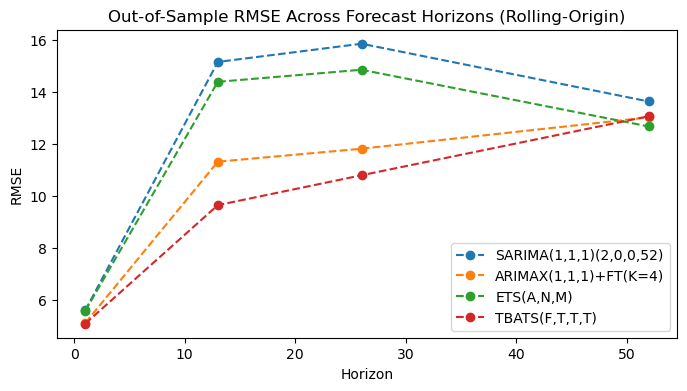

In [327]:
# visualize the RMSE values across forecast horizons to compare models 

x = comparison_models_df['horizon'].astype(int).values

y_values = [
    (comparison_models_df['SARIMA_rmse'], 'SARIMA(1,1,1)(2,0,0,52)'),
    (comparison_models_df['ARIMAX_rmse'], 'ARIMAX(1,1,1)+FT(K=4)'),
    (comparison_models_df['ETS_rmse'], 'ETS(A,N,M)'),
    (comparison_models_df['TBATS_rmse'], 'TBATS(F,T,T,T)') # bc=F, t=T, dt=T, arma=T
]

plt.figure(figsize=(8,4))

for y, label in y_values:
    plt.plot(x, y, marker='o', linestyle='--', label=label)

plt.xlabel('Horizon')
plt.ylabel('RMSE')
plt.title('Out-of-Sample RMSE Across Forecast Horizons (Rolling-Origin)')
plt.legend(loc='lower right')
plt.show()

**Interpretation of models comparison on out-of-sample RMSE**

- None of the models are most accurate at all forecast horizons tested.
- I will interpret the results based on the strategic importance of three horizon categories:
  - short (1-4 weeks) - operational acccuracy
  - medium (13-26 weeks) - seasonal transition skill
  - long (52 weeks) - policy and climate planning

Best model at each category based on RMSE

| Operational Accuracy | Seasonal Skill | Policy Planning (52 weeks)|
|----------------------|----------------|-----------------|
| TBATS | TBATS | SARIMA(1,1,1)(2,0,0,52)

- ETS provides the lowest long-horizon RMSE but lacks explicit structural dynamics. For policy-relevant forecasts where interpretability and seasonal mechanisms are critical, SARIMA is retained despite slightly higher error.
- Overall, TBATS has the most regular error growth as forecast horizon increases, and therefore, is the most stable of the four models.  TBATS also has the lowest error metrics for h = 1, 13, and 26.  This suggests that TBATS is the most robust model for both trend and seasonal extrapolation.  The ARIMAX model is in second place with regards to stability across horizons and magnitude of error at h = 1, 13, and 26.  

I will run Diebold-Mariano tests on the top at medium and long range forecast horizons:
- medium range horizons (h = 13 and 26): TBATS vs ARIMAX
- long range horizon (h = 52): ETS vs SARIMA

### Diebold-Mariano tests

#### ARIMAX vs TBATS

In [330]:
# Get the error values (MAE or MSE) from the top ARIMAX and TBATS model results
# Are RMSE values for ARIMAX and TBATS models statistically significantly different?
# I am most interested in h = 13 and 26, but will test all horizons for completeness.  

horizons = [1, 13, 26, 52]
dm_results = []

for h in horizons:
    err_A = (
        df_ro_arimax_results
        .query("model == 'ARIMAX(1, 1, 1)_FT_K4' and horizon == @h")
        .sort_values('origin')['error']
        .values
    )
    
    err_B = (
        df_ro_tbats_bcFalse_results
        .query("model == 'TBATS(bc=False, t=True, dt=True)' and horizon == @h")
        .sort_values('origin')['error']
        .values
    )
    
    # assert alignment
    assert len(err_A) == len(err_B)
    assert len(err_A) > 0
    
    # Run the Diebold-Mariano function from the model_evaluation.py file
    dm_stat, p_val = me.diebold_mariano(
        err_A,
        err_B,
        loss='mae'
    )
    dm_results.append({
        'horizon':h,
        'DM stat':dm_stat,
        'p-value':p_val
    })

dm_results_df = pd.DataFrame(dm_results)
    
print('Diebold-Mariano test for statistically significant difference between models at forecast horizons')
print('- Models: ARIMAX(1,1,1)+FT(K=4) Vs. TBATS(F,T,T,T)')
print('- DM H0: The two competing forecasts have equal predictive accuracy.')
print('- test metric: MAE')
dm_results_df.style.hide(axis='index').format(precision=3)

Diebold-Mariano test for statistically significant difference between models at forecast horizons
- Models: ARIMAX(1,1,1)+FT(K=4) Vs. TBATS(F,T,T,T)
- DM H0: The two competing forecasts have equal predictive accuracy.
- test metric: MAE


**Interpretation of Diebold-Mariano test for ARIMAX vs TBATS**

Forecast accuracy was compared using rolling-origin evaluation at fixed horizons. Statistical significance of differences in predictive accuracy was assessed using Diebold–Mariano tests based on MAE loss differentials for rebustness to outliers. To account for potential serial correlation in multi-step-ahead forecast errors, Newey–West heteroskedasticity and autocorrelation consistent (HAC) variance estimates were used with lag length equal to h−1.

Results:
- TBATS is statistically significantly different than ARIMAX(1,1,1)+FT(K=4) at lags 13 and 26
- The models are not statistically significantly different at lags 1 and 52.
- Since the TBATS error metrics are as good as those of the ARIMAX model at lags 1 and 52 and better than ARIMAX at lags 13 and 26, the DM test supports the choice of TBATS as the best model for this data. 

#### ETS vs SARIMA

In [328]:
# Get the error values (MAE) from the top ETS and SARIMA model results
# SARIMA is a preferable model due to mechanistic interpretability, but ETS has better error metrics at h = 52.  
# Are RMSE values for SARIMA and ETS models at h = 52 statistically significantly different?

horizons = [1, 13, 26, 52]
dm_results = []

for h in horizons:
    err_A = (
        df_ro_ets_results
        .query("model == 'ETS(e=add, t=None, s=mul)' and horizon == @h")
        .sort_values('origin')['error']
        .values
    )
    
    err_B = (
        df_ro_sarima_results
        .query("model == 'SARIMA(1, 1, 1)(2, 0, 0, 52)' and horizon == @h")
        .sort_values('origin')['error']
        .values
    )
    
    # assert alignment
    assert len(err_A) == len(err_B)
    assert len(err_A) > 0
    
    # Run the Diebold-Mariano function from the model_evaluation.py file
    dm_stat, p_val = me.diebold_mariano(
        err_A,
        err_B,
        loss='mae'
    )
    dm_results.append({
        'horizon':h,
        'DM stat':dm_stat,
        'p-value':p_val
    })

dm_results_df = pd.DataFrame(dm_results)
    
print('Diebold-Mariano test for statistically significant difference between models at forecast horizons')
print('- Models: ETS(A,N,M) Vs. SARIMA(1,1,1)(2,0,0,52)')
print('- DM H0: The two competing forecasts have equal predictive accuracy.')
print('- test metric: MAE')
dm_results_df.style.hide(axis='index').format(precision=3)

Diebold-Mariano test for statistically significant difference between models at forecast horizons
- Models: ETS(A,N,M) Vs. SARIMA(1,1,1)(2,0,0,52)
- DM H0: The two competing forecasts have equal predictive accuracy.
- test metric: MAE


**Interpretation of Diebold-Mariano test for ETS vs SARIMA**

The best model for long horizon forecasts (h = 52) based on RMSE and MAE is ETS(A,N,M).  However:
- ETS(A,N,M) assumes no stochastic trend and multiplicative seasonality, which is not consistent with several analyses of the train data for non-seasonal and seasonal differencing and seasonal amplitude vs mean.
- Although ETS has slightly lower RMSE at long horizons, its advantage over SARIMA is not statistically significant.

Therefore, SARIMA is the preferred model for long-horizon forecasts due to interpretability and structural consistency, given that forecast accuracy is not statistically different from ETS.

## comparing models: skill vs seasonal naive

In [264]:
# concatenate rolling_origin_evaluation results for all models:

df_sarima = pd.DataFrame(ro_sarima_results)
df_arimax = pd.DataFrame(ro_arimax_results)
df_ets = pd.DataFrame(ro_ets_results)
df_tbats = pd.DataFrame(ro_tbats_bcFalse_results)

df_eval = pd.concat(
    [df_sarima, df_arimax, df_ets, df_tbats],
    ignore_index=True
)

# Filter df_eval for top models in each model category

top_models = [
    'SARIMA(1, 1, 1)(2, 0, 0, 52)',
    'ARIMAX(1, 1, 1)_FT_K4',
    'ETS(e=add, t=None, s=mul)',
    'TBATS(bc=False, t=True, dt=True)'
]

df_top_models = (df_eval.query('model in @top_models'))

In [271]:
# produce a DataFrame for model comparison

horizons = [13,26,52]

skill_df = (
    df_top_models
    .query('horizon in @horizons')
    .groupby(['model', 'horizon'])
    .apply(
        lambda g: me.skill_vs_naive(
            y_true=g['y_true'].values,
            y_pred=g['y_pred'].values,
            y_naive=g['y_naive'].values
        ),
        include_groups=False
    )
    .reset_index(name='skill')
    .assign(pct_improvement = lambda x: x['skill'] * 100).round(2)
)
skill_df

model  horizon  skill  pct_improvement
0              ARIMAX(1, 1, 1)_FT_K4       13   0.10            10.45
1              ARIMAX(1, 1, 1)_FT_K4       26   0.08             7.62
2              ARIMAX(1, 1, 1)_FT_K4       52  -0.02            -1.85
3          ETS(e=add, t=None, s=mul)       13  -0.14           -13.85
4          ETS(e=add, t=None, s=mul)       26  -0.16           -16.12
5          ETS(e=add, t=None, s=mul)       52   0.01             0.88
6       SARIMA(1, 1, 1)(2, 0, 0, 52)       13  -0.20           -19.89
7       SARIMA(1, 1, 1)(2, 0, 0, 52)       26  -0.24           -23.95
8       SARIMA(1, 1, 1)(2, 0, 0, 52)       52  -0.07            -6.63
9   TBATS(bc=False, t=True, dt=True)       13   0.24            23.67
10  TBATS(bc=False, t=True, dt=True)       26   0.16            15.59
11  TBATS(bc=False, t=True, dt=True)       52  -0.02            -2.21

**Interpretation of skill vs naive results**

- Skill > 0 --> model beats seasonal naive
- Skill ~= 0 --> model ~= naive
- Skill < 0 --> model is worse than naive 

Results:
- ARIMAX and TBATS are both better than seasonal naive at medium-range forecasts
- TBATS provides statistically and practically meaningful gains at 13-26 weeks
- ETS is competitive with seasonal naive forecast at h = 52, but is otherwise worse at medium-range horizons.
- SARIMA is consistently worse than the seasonal naive benchmark.
- No model meaningfully beats naive at 52 weeks
- Differences at 52 weeks are small, unstable, and not statistically significant
- Seasonal naive is a very strong baseline for CH4

## comparing models: Nash-Sutcliffe Efficiency (NSE)

In [275]:
horizons = [13,26,52]

nse_df = (
    df_top_models
    .query('horizon in @horizons')
    .groupby(['model', 'horizon'])
    .apply(
        lambda g: me.nse_vs_naive(
        g['y_true'].values,
        g['y_pred'].values,
        g['y_naive'].values
        ),
        include_groups=False
    )
    .reset_index(name='NSE')
)

nse_df

model  horizon       NSE
0              ARIMAX(1, 1, 1)_FT_K4       13  0.198103
1              ARIMAX(1, 1, 1)_FT_K4       26  0.146510
2              ARIMAX(1, 1, 1)_FT_K4       52 -0.037417
3          ETS(e=add, t=None, s=mul)       13 -0.296090
4          ETS(e=add, t=None, s=mul)       26 -0.348458
5          ETS(e=add, t=None, s=mul)       52  0.017585
6       SARIMA(1, 1, 1)(2, 0, 0, 52)       13 -0.437469
7       SARIMA(1, 1, 1)(2, 0, 0, 52)       26 -0.536333
8       SARIMA(1, 1, 1)(2, 0, 0, 52)       52 -0.136992
9   TBATS(bc=False, t=True, dt=True)       13  0.417328
10  TBATS(bc=False, t=True, dt=True)       26  0.287543
11  TBATS(bc=False, t=True, dt=True)       52 -0.044672

**Interpretation of Nash-Sutcliffe Efficiency vs naive results**

Nash–Sutcliffe efficiency was computed relative to a seasonal naive benchmark using rolling-origin evaluation at fixed forecast horizons.

Note: For reporting on methane data, standard NSE can be misleading. Because the CH4 trend 
is so aggressive, almost any model that captures a basic upward slope will have a very high 
standard NSE, simply because the "mean of the data" is a very poor predictor for a trending series.

NSE vs naive = 1 - (SSE(model) / SSE(naive))
- NSE = Nash-Sutcliffe Efficiency
- SSE = sum of squared errors

Note: The NSE vs naive metric is essentially the same as MSE.  Since both "model" and "naive" have the same number of data points, they cancel leaving SSE.  

how to inerpret results:
- NSE < 0 --> worse than naive
- NSE ~= 0 --> same as naive
- NSE ~= 0.1-0.3 --> modest but meaningful skill
- NSE ~= 0.3+ --> strong forecast skill
  
results:
- TBATS has the best NSE vs naive scores at mid-range forecast horizons:
  - 13: 0.417 means ~ 42% reeduction in MSE vs naive, at h = 13
  - 26: 0.287 means ~ 29% reduction in MSE vs naive, at h = 26
- ARIMAX has the second best NSE scores at h = 13 and 26
- ETS at h = 52 is essentially equal to naive, and will no longer be considered for long horizon forecasting.
- SARIMA NSE scores are worse than naive at all forecast horizons.

## Final model comparison

Aggregate metrics for the top parameters of all four candidate models for final inspection and model selection.  

In [315]:
# First concatenate RMSE values per horizon and per model 

best_model_params = [
    (ro_sarima_summary, 'SARIMA(1, 1, 1)(2, 0, 0, 52)'),
    (ro_arimax_summary, 'ARIMAX(1, 1, 1)_FT_K4'),
    (ro_ets_summary, 'ETS(e=add, t=None, s=mul)'),
    (ro_tbats_bcFalse_summary, 'TBATS(bc=False, t=True, dt=True)')
]

horizons = [13,26,52]
temp_dfs = []

# MSE: Filter each rolling-origin evaluation summary
for df_obj, param in best_model_params:
    filtered_df = (
        df_obj
        .query('model == @param and horizon in @horizons')
        .drop(columns=['n_folds', 'mae'], errors='ignore') 
    )
    temp_dfs.append(filtered_df)

# concatenate temp_dfs (filtered model summaries)
mse_table_df = pd.concat(temp_dfs, ignore_index=True)
# mse_table_df.style.hide(axis='index')

In [325]:
# Second, merge the concatenated RMSE DataFrame with skill and NSE DataFrames

model_comp_df = (
    mse_table_df
    .merge(skill_df, on=['model', 'horizon'], how='left')
    .merge(nse_df, on=['model', 'horizon'], how='left')
    .assign(
        beats_naive = lambda d: d['skill'] > 0,
        rmse=lambda d: d['rmse'].round(2),
        skill=lambda d: d['skill'].round(2),
        pct_skill_vs_naive=lambda d: (d['skill'] * 100).round(2),
        NSE=lambda d: d['NSE'].round(2)
    )
)

# order columns
cols = ['model', 'horizon', 'rmse', 'skill', 'pct_skill_vs_naive', 'beats_naive', 'NSE']
model_comp_df = model_comp_df[cols]

display(
    model_comp_df.style.format({
        'rmse'              :'{:.2f}',
        'skill'             :'{:.2f}',
        'pct_skill_vs_naive':'{:.1f}',
        'NSE'               :'{:.2f}'
    }).hide(axis='index')
)

print('\n=== Evaluation Metrics guide ===')
print('\nRMSE --> accuracy (lower score is better)')
print('\nSkill vs naive --> relative RMSE improvement over seasonal naive benchmark (higher is better)')
print('     - Skill > 0: model beats seasonal naive')
print('     - Skill ~= 0: model ~= naive')
print('     - Skill < 0: model is worse than naive')
print('\nNash-Sutcliffe Efficiency (NSE) vs naive --> robustness to large errors (closer to one is better)')
print('     - NSE < 0: worse than naive')
print('     - NSE ~= 0: same as naive')
print('     - NSE ~= 0.1–0.3: modest but meaningful skill')
print('     - NSE ~= 0.3+: strong forecast skill')


=== Evaluation Metrics guide ===

RMSE --> accuracy (lower score is better)

Skill vs naive --> relative RMSE improvement over seasonal naive benchmark (higher is better)
     - Skill > 0: model beats seasonal naive
     - Skill ~= 0: model ~= naive
     - Skill < 0: model is worse than naive

Nash-Sutcliffe Efficiency (NSE) vs naive --> robustness to large errors (closer to one is better)
     - NSE < 0: worse than naive
     - NSE ~= 0: same as naive
     - NSE ~= 0.1–0.3: modest but meaningful skill
     - NSE ~= 0.3+: strong forecast skill


**Summary of results:**

- TBATS exhibits the highest skill and NSE at seasonal horizons (13–26 weeks), indicating substantial reductions in mean squared error relative to the naive benchmark.
- ARIMAX models show moderate skill at shorter horizons but deteriorate at one-year lead times, suggesting limited long-horizon extrapolation capability.
- SARIMA and ETS models generally perform worse than the naive benchmark once evaluated using rolling-origin cross-validation.

**Final Model Comparison and Selection Rationale**

Model evaluation proceeded in two stages. Preliminary parameter screening used MAE to identify stable candidate configurations without excessive sensitivity to outliers. Final evaluation focused on benchmark-relative performance using RMSE-based skill scores and Nash–Sutcliffe Efficiency (NSE).

RMSE-based skill quantifies average error reduction relative to a seasonal naive forecast, while NSE assesses the model’s ability to capture variance and avoid large forecast failures. Although both metrics use squared errors, they emphasize different aspects of forecast quality and are therefore complementary rather than redundant.

Forecast performance was evaluated using rolling-origin cross-validation at fixed horizons (13, 26, and 52 weeks). Accuracy was assessed relative to a seasonal naive benchmark using three complementary metrics: RMSE, RMSE-based skill scores, and Nash–Sutcliffe efficiency (NSE).

RMSE quantifies absolute forecast accuracy, while skill scores measure relative improvement over a naive benchmark. NSE provides a complementary perspective based on mean squared error, penalizing large forecast errors more strongly and emphasizing robustness. Consistent conclusions across skill and NSE strengthen confidence in model selection.

Key findings:

SARIMA and ETS models exhibit negative skill and negative NSE at most horizons, indicating performance that is worse than or indistinguishable from the seasonal naive benchmark. Despite reasonable in-sample fit, these models fail to add predictive value under rolling-origin evaluation and are therefore excluded from further consideration.

ARIMAX(1,1,1) with Fourier terms (K=4) shows modest but consistent skill at short to medium horizons (13-26 weeks), suggesting that explicit seasonal regressors improve near-term forecast accuracy. However, skill and NSE deteriorate at the one-year horizon, indicating limited long-horizon extrapolation capability.

TBATS demonstrates the strongest and most stable performance across horizons. It achieves the highest skill and NSE at seasonal horizons (13-26 weeks), reflecting substantial reductions in mean squared error relative to the naive benchmark. While long-horizon (52-week) performance converges toward naive levels, TBATS remains competitive and exhibits the smoothest degradation of forecast accuracy with increasing lead time.

Diebold–Mariano tests reinforce these conclusions. TBATS is statistically significantly more accurate than ARIMAX at horizons 13 and 26 weeks, while differences at short (1 week) and long (52 weeks) horizons are not statistically significant. No significant differences are observed between ETS and SARIMA, consistent with their similarly poor relative performance.

Final model choice:
- Primary model: TBATS - best overall robustness and seasonal forecasting skill
- Secondary model: ARIMAX - useful for shorter horizons and interpretability
- Excluded models: SARIMA and ETS - do not outperform a seasonal naive benchmark under rolling-origin evaluation

# Residual diagnostics: TBATS vs ARIMAX

## TBATS

In [388]:
# TBATS(F,T,T,T) in-sample model of CH4 train data

tbats_model = me.fit_mean_model(
    y=train_preprocessed,
    model_type='tbats',
    model_params={
        'use_box_cox':False,
        'use_trend':True,
        'use_damped_trend':True,
        'sp':[52.178],
        'use_arma_errors':True
    }
)


=== Residual Diagnostics: TBATS(bc=F, t=T, dt=T, arma=T) ===
Mean    : 0.43379
Std     : 4.39411
Skew    : 0.109
Kurtosis: 3.642

Jarque-Bera p-value: 0.0000

Ljung-Box p-values:
  lag 1: p = 0.6763
  lag 4: p = 0.9910
  lag 13: p = 0.0000
  lag 26: p = 0.0001
  lag 52: p = 0.0030

Engle's ARCH test (nlags=52) p-value: 4.9170e-04

ADF p-value: 0.0000


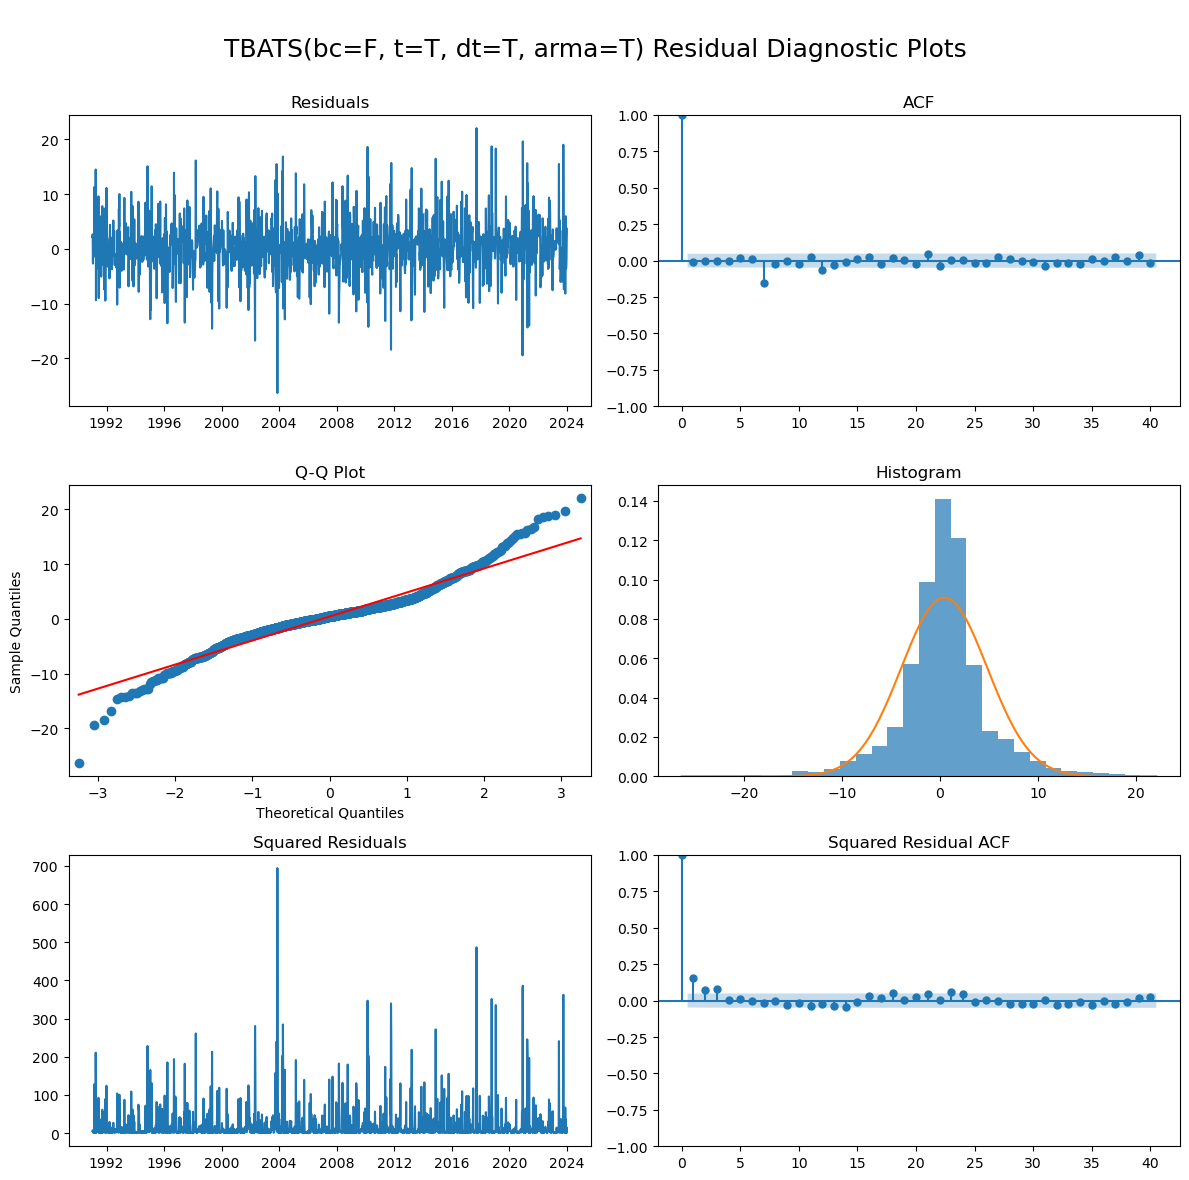

In [409]:
# TBATS(F,T,T,T) in-sample residual diagnostics

me.residual_diagnostics(
    tbats_model['residuals'], 
    title='TBATS(bc=F, t=T, dt=T, arma=T)', 
    plot=True
)

## ARIMAX

In [357]:
# Make exogenous Fourier terms

arimax_exog = make_fourier_terms(
    train_preprocessed.index,
    period=52,
    K=4
)

In [374]:
# ARIMAX(1,1,1) + FT(K=4) in-sample model of CH4 train data

arimax_model = me.fit_mean_model(
    y=train_preprocessed,
    model_type='sarima',
    model_params={
        'order':(1,1,1),
        'seasonal_order':(0,0,0,0),
        'trend':'n',
        'enforce_stationarity':True,
        'enforce_invertibility':True
    },
    exog=arimax_exog
)


=== Residual Diagnostics: ARIMAX(1,1,1) + FT(K=4) ===
Mean    : 0.43881
Std     : 4.48660
Skew    : 0.186
Kurtosis: 3.727

Jarque-Bera p-value: 0.0000

Ljung-Box p-values:
  lag 1: p = 0.0487
  lag 4: p = 0.1842
  lag 13: p = 0.0000
  lag 26: p = 0.0000
  lag 52: p = 0.0000

Engle's ARCH test (nlags=52) p-value: 1.6228e-04

ADF p-value: 0.0000


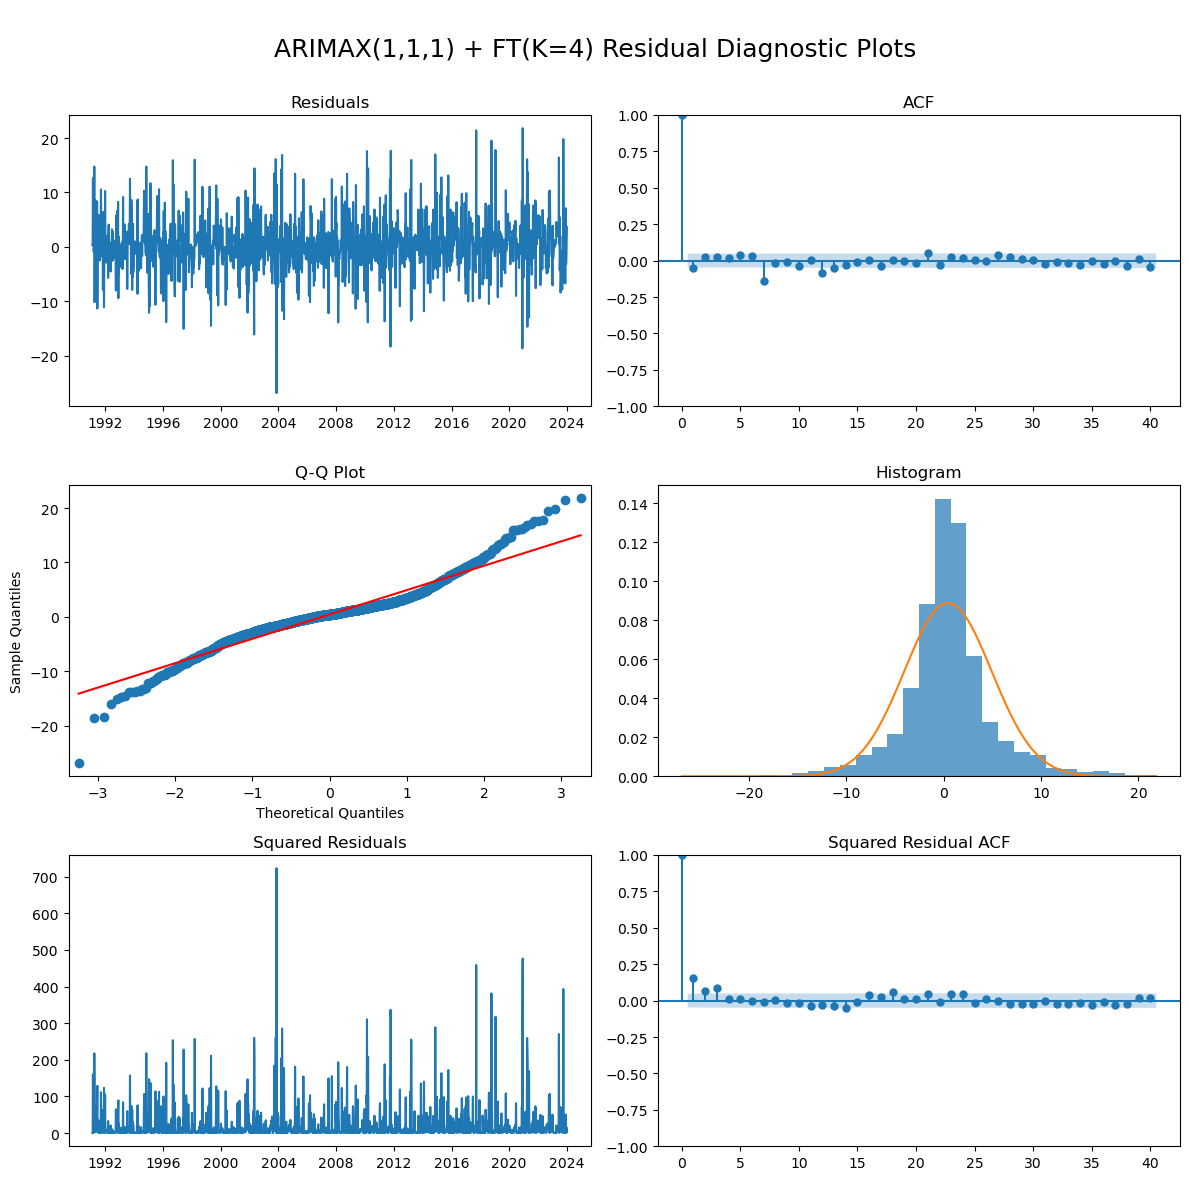

In [410]:
# ARIMAX(1,1,1) + FT(K=4) in-sample residual diagnostics

me.residual_diagnostics(
    arimax_model['residuals'], 
    title='ARIMAX(1,1,1) + FT(K=4)', 
    plot=True
)

**Inerpretation of the TBATS model in-sample residuals diagnostic tests**

- Jarque-Bera H0: residuals are normally distributed
- Ljung-Box H0: no joint autocorrelation up to a specified lag
- ADF H0: residuals contain a unit root (non-stationary)
- Engle's ARCH test H0: no conditional heterscedasticity (constant variance)

TBATS provides a better specification of the conditional mean: 
- no evidence of short-lag autocorrelation (lags 1 and 4), but some seasonal dependencies remain
- residuals are stationary
- residuals exhibit marginally reduced tail heaviness relative to ARIMAX
- Conditional heteroscedasticity is less pronounced than in ARIMAX

However, both models:
- show autocorrelation at lags 13, 26, and 52
- have a non-normal distribution of residuals
- show significant conditional heteroscedasticity that will affect forecast uncertainty.

Conclusion:
- Continue with TBATS as the top mean model
- model conditional heteroscedasticity with GARCH to improve prediction intervals

next steps:
- CRPS
- Interval coverage (e.g. 80%, 95%)
- Sharpness vs calibration
- test variance modeling, evaluate with CRPS
- rolling-origin forecast evaluation with expanding window at fixed horizons (1, 13, 26, 52).

# Probabilistic model and evaluation

- CRPS (continuous ranked probability score) - how accurate is the distribution?
- PIT (probability integral transform) - where is the bias?  

## CRPS (continuous ranked probability score)

In [419]:
def crps_gaus_helper(model_results, y_true):
    '''
    Helper function to extract values and calculate CRPS from fit_mean_model output
    '''
    # use the model's residual index to align y_true to account for observations dropped during burn-in
    aligned_y = y_true.loc[model_results['residuals'].index].values
    
    mu = model_results['fitted_values'].values
    resid = model_results['residuals'].values
    sigma = np.full_like(mu, np.std(resid, ddof=1))

    return me.crps_gaussian(y=aligned_y, mu=mu, sigma=sigma)

In [431]:
# Since ARIMAX residuals were trimmed due to burn-in artifacts at the earliest time points, I will 
# use a common index for both TBATS and ARIMAX for direct comnparison of CRPS results.  

# identify the common earliest start index
common_index = arimax_model['residuals'].index.intersection(tbats_model['residuals'].index)

# create trimmed versions of the model results
def trim_results(results, index):
    return{
        'fitted_values': results['fitted_values'].loc[index],
        'residuals'    : results['residuals'].loc[index]
    }

tbats_trimmed = trim_results(tbats_model, common_index)
arimax_trimmed = trim_results(arimax_model, common_index)

print(f'indexes for trimmed TBATS fitted values, min/max: {tbats_trimmed['fitted_values'].index.min()} / {tbats_trimmed['fitted_values'].index.max()}')
print(f'indexes for trimmed TBATS residuals, min/max: {tbats_trimmed['residuals'].index.min()} / {tbats_trimmed['residuals'].index.max()}')

print(f'\nindexes for trimmed ARIMAX fitted values, min/max: {arimax_trimmed['fitted_values'].index.min()} / {arimax_trimmed['fitted_values'].index.max()}')
print(f'indexes for trimmed ARIMAX residuals, min/max: {arimax_trimmed['residuals'].index.min()} / {arimax_trimmed['residuals'].index.max()}')

indexes for trimmed TBATS fitted values, min/max: 1991-02-10 00:00:00 / 2023-12-31 00:00:00
indexes for trimmed TBATS residuals, min/max: 1991-02-10 00:00:00 / 2023-12-31 00:00:00

indexes for trimmed ARIMAX fitted values, min/max: 1991-02-10 00:00:00 / 2023-12-31 00:00:00
indexes for trimmed ARIMAX residuals, min/max: 1991-02-10 00:00:00 / 2023-12-31 00:00:00


In [433]:
crps_tbats_insample = crps_gaus_helper(tbats_trimmed, train_preprocessed)
crps_arimax_insample = crps_gaus_helper(arimax_trimmed, train_preprocessed)

print(f'CRPS for TBATS(F,T,T,T) in-sample fit: {crps_tbats_insample:.4f}')
print(f'CRPS for ARIMAX(1,1,1)+FT(K=4) in-sample fit: {crps_arimax_insample:.4f}')

CRPS for TBATS(F,T,T,T) in-sample fit: 2.3352
CRPS for ARIMAX(1,1,1)+FT(K=4) in-sample fit: 2.3728


In [441]:
# Compare CRPS scores to seasonal naive benchmark

# create seasonal naive forecast (y(t) = y(t-52))
y_seasonal_naive = train_preprocessed.shift(52)

# update common_index to exclude the first 52 weeks (NaNs from shifting)
# take the intersection of the model index and the non-null naive index
naive_valid_index = y_seasonal_naive.dropna().index
final_comparison_index = common_index.intersection(naive_valid_index)

# align with common evaluation index (due to burn-in trimming and shifting)
y_true_trimmed = train_preprocessed.loc[final_comparison_index]
y_naive_trimmed = y_seasonal_naive.loc[final_comparison_index]

# trim the model results again to match the new 52 week offset index
tbats_final_trim = trim_results(tbats_model, final_comparison_index)
arimax_final_trim = trim_results(arimax_model, final_comparison_index)

# re-calculate CRPS for models on the new index
crps_tbats_comp = crps_gaus_helper(tbats_final_trim, train_preprocessed)
crps_arimax_comp = crps_gaus_helper(arimax_final_trim, train_preprocessed)

# calculate baseline CRPS (the MAE of the naive forecast)
# The seasonal naive forecast is treated as deterministic; therefore CRPS reduces to MAE.
crps_baseline = mean_absolute_error(y_true_trimmed, y_naive_trimmed)

# calculate skill scores
skill_crps_tbats = 1 - (crps_tbats_comp / crps_baseline)
skill_crps_arimax = 1 - (crps_arimax_comp / crps_baseline)

print(f'Seasonal naive baseline CRPS (MAE): {crps_baseline:.4f}')
print(f'TBATS CRPS skill score: {skill_crps_tbats:.4f}')
print(f'ARIMAX CRPS skill score: {skill_crps_arimax:.4f}')

print(f'\nindexes for tbats_final_trim, min/max: {tbats_final_trim['fitted_values'].index.min().strftime('%Y-%m-%d')} / {tbats_final_trim['fitted_values'].index.max().strftime('%Y-%m-%d')}')
print(f'indexes for arimax_final_trim, min/max: {arimax_final_trim['fitted_values'].index.min().strftime('%Y-%m-%d')} / {arimax_final_trim['fitted_values'].index.max().strftime('%Y-%m-%d')}')


Seasonal naive baseline CRPS (MAE): 10.1295
TBATS CRPS skill score: 0.7714
ARIMAX CRPS skill score: 0.7680

indexes for tbats_final_trim, min/max: 1992-01-05 / 2023-12-31
indexes for arimax_final_trim, min/max: 1992-01-05 / 2023-12-31


**Interpretation of the CRPS results**

CRPS scores accuracy and sharpness 

TBATS vs ARIMAX:  TBATS has a slightly better probabilistic accuracy than ARIMAX.  This result supports diagnostics that TBATS handles low lag structure better (no evidence of autocorrelation at lags 1 and 4) and smoother seasonal representation.  

- The CRPS skill score of ~ 0.77 means that both models achieve approximately 77% CRPS skill relative to a seasonal naive forecast, indicating large gains in probabilistic forecast accuracy.
- Both models substantially reduce average probabilistic error relative to a deterministic seasonal naive forecast
- TBATS has a better overall CRPS score and marginally better CRPS skill score compared to the ARIMAX model.
- The results suggest that the trigonometric seasonality of TBATS is slightly more efficient at capturing seasonal dynamics of atmospheric CH4 concentration compared to the fixed Fourier terms of the ARIMAX model.

Conclusions:  Which mean model is better assuming constant variance?
- TBATS remains the top mean model
- ARIMAX is a competitive benchmark

Important Note:  The model residual diagnostics reveal significant conditional heteroscedasticity, and the fixed sigma used in the CRPS calculation is the global standard deviation.  Due to the ARCH effects, we know that the variance is time-dependent, which means that these CRPS scores are estimates and the CRPS scores will need to be recalculated following ARCH effects modeling.  

Next steps:
- TBATS + GARCH variance
- Rolling one-step-ahead CRPS
- Rolling seasonal-horizon CRPS (13, 26, 52)
- Interval coverage diagnostics
- Final model selection

## GARCH - model conditional variance

In [446]:
garch_tbats_res, scale = me.fit_garch(
    residuals=tbats_model['residuals'],
    p=1,
    q=1,
    dist='normal'
)

print(garch_tbats_res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:       CH4_preprocessed   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2401.51
Distribution:                  Normal   AIC:                           4811.01
Method:            Maximum Likelihood   BIC:                           4832.82
                                        No. Observations:                 1722
Date:                Fri, Jan 30 2026   Df Residuals:                     1721
Time:                        15:24:26   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0994  2.508e-02      3.965  7.350e-05 [5.028e-0

In [457]:
# Did the GARCH model fix the residuals?  

# get the standardized residuals from the GARCH results (errors / predicted volatility)
std_resid = garch_tbats_res.resid / garch_tbats_res.conditional_volatility

# run an ARCH test on the new residuals 
lm_stat, p_val, f_stat, f_p_val = het_arch(std_resid.dropna(), nlags=52)

print('original TBATS ARCH p-value: 0.00049')
print(f'standardized (GARCH) ARCH p-value: {p_val:.4f}')

if p_val > 0.05:
    print('Success:  GARCH has successfully modeled the conditional heteroscedasticity')
else:
    print('Note: Some ARCH effects remain')

original TBATS ARCH p-value: 0.00049
standardized (GARCH) ARCH p-value: 0.8218
Success:  GARCH has successfully modeled the conditional heteroscedasticity


**GARCH model results**

- all parameters are statistically significant.  omega, alpha[1], and beta[1] have p-values < 0.05.  This confirms that CH4 volatility is not constant and follows a predictable pattern based on past shocks (alpha) and past volatility (beta).
- stationarity:  alpha + beta = 0.587.  The sum is < 1 indicating that the volatility process is mean-reverting, which means that CH4 concentration returns to a stable noise level following a spike/volatile event.
- The Engle's ARCH test on standardized GARCH residuals confirm that GARCH(1,1) effectively modeled the TBATS(F,T,T,T) model's conditional heteroscedasticity - the TBATS residuals are now essentially white noise.  

## GARCH-sigma_t CRPS

In [453]:
# Recalculate CRPS 

# The fit_garch() function manually scales residuals to help the arch library's optimizer converge
    # scale = residuals.std() 
    # resids_scaled = residuals / scale
# Therefore, conditional volatility (sigma_t) returned by the GARCH model will need to re-sccaled to get the 
# time-varying sigma back into the original scale of ppb.  

# since I originally divided the residuals by the scale factor, I will now multiply sigma_t by the scale factor.  
scale_factor = tbats_model['residuals'].std()
sigma_t = garch_tbats_res.conditional_volatility * scale_factor 

# align indexes for the TBATS model and GARCH model residuals, since I am not moving forward with the ARIMAX model
tbats_garch_index = tbats_model['residuals'].index.intersection(sigma_t.index)

# extract aligned components 
y_eval = train_preprocessed.loc[tbats_garch_index].values
mu_eval = tbats_model['fitted_values'].loc[tbats_garch_index].values
resid_eval = tbats_model['residuals'].loc[tbats_garch_index].values

# Global sigma (the static benchmark)
# calculate standard deviation only on the evaluation window for fairness
sigma_global = np.full_like(mu_eval, np.std(resid_eval, ddof=1))
crps_global = me.crps_gaussian(y=y_eval, mu=mu_eval, sigma=sigma_global)

# GARCH sigma
sigma_dynamic = sigma_t.loc[tbats_garch_index].values
crps_garch = me.crps_gaussian(y=y_eval, mu=mu_eval, sigma=sigma_dynamic)

# print
print(f"Evaluation window: {tbats_garch_index.min().strftime('%Y-%m-%d')} to {tbats_garch_index.max().strftime('%Y-%m-%d')}")
print(f'Observations: {len(tbats_garch_index)}')
print(f'CRPS (global sigma): {crps_global:.4f}')
print(f'CRPS (dynamic sigma): {crps_garch:.4f}')

Evaluation window: 1991-01-06 to 2023-12-31
Observations: 1722
CRPS (global sigma): 2.3322
CRPS (dynamic sigma): 2.3148


**Interpretation of the CRPS (GARCH) result**

Skill (GARCH) = 1 - (CRPS (dynamic sigma) / CRPS (global sigma)) = 0.0075 or 0.75%

While the mean TBATS model captures the primary seasonal dynamics, the addition of a GARCH(1,1) volatility component further refines the probabilistic forecast, yielding a 0.75% improvement in CRPS and providing better-calibrated uncertainty estimates during episodic volatility.

## Rolling seasonal CRPS

### TBATS(bc=F,dt=T) + GARCH(1,1)

In [661]:
# rolling seasonal CRPS on TBATS mean model + GARCH variance model

rolling_crps_dynamic_tbats = me.rolling_crps(
    y=train_preprocessed,
    model_type='tbats',
    model_params={
        'use_box_cox':False,
        'use_trend':True,
        'use_damped_trend':True,
        'sp':[52.178],
        'use_arma_errors':True
    },
    variance_type='garch',
    variance_params={'p':1, 'q':1},
    horizons=(1,13,26,52),
    step=13
)

In [662]:
rolling_crps_dynamic_tbats

origin  horizon           mu      sigma      y_true       crps  \
0   1994-01-02        1  1759.926983   3.794635  1759.04500   0.968203   
1   1994-01-02       13  1755.591518   7.070324  1754.09000   1.779036   
2   1994-01-02       26  1737.939872   7.143786  1743.13250   3.112275   
3   1994-01-02       52  1758.704110   7.257071  1778.67750  15.891980   
4   1994-04-03        1  1754.767285   4.168933  1763.25500   6.199907   
..         ...      ...          ...        ...         ...        ...   
463 2022-08-28       52  1906.791704  12.192430  1914.93375   4.941292   
464 2022-11-27        1  1951.235725   3.937321  1952.66250   1.124167   
465 2022-11-27       13  1937.876534   9.161278  1936.42000   2.233134   
466 2022-11-27       26  1933.479553  10.381862  1943.47125   5.991694   
467 2022-11-27       52  1945.534378  12.243949  1946.63000   2.900435   

          pit mean_model variance_model  
0    0.408102      tbats          garch  
1    0.415910      tbats          garch  
2    0.766348      tbats          garch  
3    0.997041      tbats          garch  
4    0.979122      tbats          garch  
..        ...        ...            ...  
463  0.747868      tbats          garch  
464  0.641463      tbats          garch  
465  0.436839      tbats          garch  
466  0.832080      tbats          garch  
467  0.535651      tbats          garch  

[468 rows x 9 columns]

In [663]:
# Check rolling_crps function call output to determine if every origin produced forecasts for all horizons
# number of origins: (sample length - start size - 52) / 13
folds_dynamic = rolling_crps_dynamic_tbats.groupby('horizon').size()

# Check for healthy predictive distribution degradation over increasing forecast horizons
# expect 1 < 13 < 26 < 52
crps_dynamic = rolling_crps_dynamic_tbats.groupby('horizon')['crps'].mean()

# calibration diagnostics
pit_dynamic = rolling_crps_dynamic_tbats.groupby('horizon')['pit'].mean()

print('Rolling-origin TBATS with GARCH (dynamic sigma)')
print('\nNumber of origins (structural correctness)')
print(folds_dynamic)
print('\nCRPS (forecast coherence)')
print(crps_dynamic)
print('\nPIT (calibration diagnostics)')
print(pit_dynamic)

Rolling-origin TBATS with GARCH (dynamic sigma)

Number of origins (structural correctness)
horizon
1     117
13    117
26    117
52    117
dtype: int64

CRPS (forecast coherence)
horizon
1     2.709605
13    5.419279
26    6.109872
52    7.490675
Name: crps, dtype: float64

PIT (calibration diagnostics)
horizon
1     0.534052
13    0.604197
26    0.656309
52    0.717990
Name: pit, dtype: float64


**PIT values per horizon**

- approximately equal to 0.5 - well calibrated probabilistic forecast
- greather than 0.5 - forecast distribution too low/narrow
- less than 0.5 - forecast distribution too high/wide

per horizon: 
- h = 1: slight under-dispersion, but very close to 0.5
- h = 13: distribution is becoming too narrow.  Seasonal uncertainty is underpresented
- h = 26: under-dispersion.  Model is too confident
- h = 52: model is very overconfident.  Long horizon seasonal uncertainty is underestimated.

Interpretation:
- TBATS + GARCH models short term uncertainty pretty well, but underestimates long-horizon seasonal uncertainty

### TBATS(bc=F,dt=T) - GARCH (static/global sigma)

In [664]:
# rolling seasonal CRPS on TBATS mean model (static sigma)

rolling_crps_static_tbats = me.rolling_crps(
    y=train_preprocessed,
    model_type='tbats',
    model_params={
        'use_box_cox':False,
        'use_trend':True,
        'use_damped_trend':True,
        'sp':[52.178],
        'use_arma_errors':True
    },
    variance_type='static',
    variance_params=None,
    horizons=(1,13,26,52),
    step=13
)

In [830]:
# Check rolling_crps function call output to determine if every origin produced forecasts for all horizons
# number of origins: (sample length - start size - 52) / 13
folds_static = rolling_crps_static_tbats.groupby('horizon').size()

# Check for healthy predictive distribution degradation over increasing forecast horizons
# expect 1 < 13 < 26 < 52
crps_static = rolling_crps_static_tbats.groupby('horizon')['crps'].mean()

# calibration diagnostics
pit_static = rolling_crps_static_tbats.groupby('horizon')['pit'].mean()

print('Rolling-origin TBATS without GARCH (static/global sigma)')
print('\nNumber of origins (structural correctness)')
print(folds_static)
print('\nCRPS (forecast coherence)')
print(crps_static)
print('\nPIT (calibration diagnostics)')
print(pit_static)

Rolling-origin TBATS without GARCH (static/global sigma)

Number of origins (structural correctness)
horizon
1     117
13    117
26    117
52    117
dtype: int64

CRPS (forecast coherence)
horizon
1     2.718206
13    5.425013
26    6.109206
52    7.490171
Name: crps, dtype: float64

PIT (calibration diagnostics)
horizon
1     0.529274
13    0.604187
26    0.656330
52    0.718468
Name: pit, dtype: float64


In [831]:
delta_crps = crps_static.values - crps_dynamic.values
delta_pit = pit_static.values - pit_dynamic.values

dynamic_vs_static_comp_df = pd.DataFrame({
    'folds': folds_dynamic,
    'CRPS (static)': crps_static.values,
    'CRPS (dynamic)': crps_dynamic.values,
    'delta CRPS': delta_crps,
    'PIT (static)': pit_static.values,
    'PIT (dynamic)': pit_dynamic.values,
    'delta PIT': delta_pit
})

dynamic_vs_static_comp_df.style.format('{:.6f}')

**Interpretation of the rolling CRPS results**

Static vs. Dynamic (The GARCH effect)
- The "Static" metrics represent the base TBATS model, while "Dynamic" includes the GARCH(1,1) component. 
- Marginal Gains: The CRPS (Continuous Ranked Probability Score) improves (decreases) slightly for short horizons (1 and 13 weeks) when adding GARCH.
- The Vanishing Benefit: By week 26 and 52, the delta CRPS turns negative (or negligible), meaning the GARCH component offers no predictive advantage for long-term methane trends. This suggests that while methane may have short-term volatility clusters, its long-term uncertainty is dominated by the trend and seasonality, not heteroscedasticity.

PIT (Probability Integral Transform) Calibration
- The PIT values measure how well the model captures the true distribution of the data (0.5 is ideal for a perfectly calibrated median). 
- Calibration Drift: The mean PIT values start near 0.53 (good) but climb to 0.71 by week 52.
- Interpretation: Since PIT values > 0.5 indicate the model is consistently underestimating the actual values, The TBATS model is "biased low" as the horizon increases. This suggests the damped trend might be suppressing the actual acceleration of atmospheric methane more than it should.


Need to plot the histogram of PIT to better understand the reliability of the probabilistic model:
- U-shaped: intervals are too narrow.  The model is overconfident
- inverted U-shaped: intervals are too wide.  The model is undercofident
- flat (uniform): the model is perfectly calibrated.  

#### PIT histograms

PIT = probability integral transform 

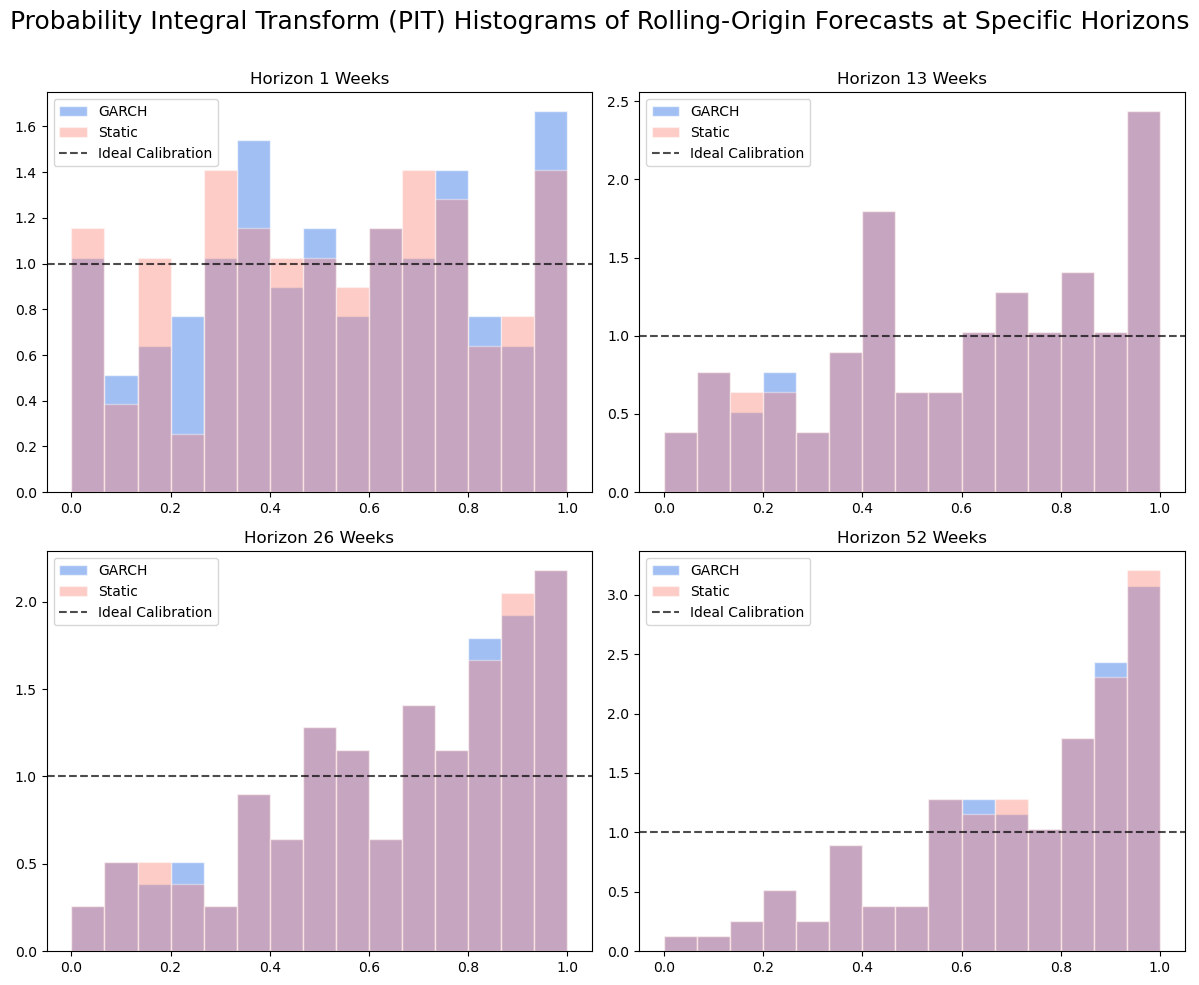

In [668]:
horizons = [1,13,26,52]
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()
common_bins = np.linspace(0,1,16)   # align bins

for i, h in enumerate(horizons):
    # filter the dynamic sigma (GARCH) PIT values 
    dynamic_pits = rolling_crps_dynamic_tbats[rolling_crps_dynamic_tbats['horizon'] == h]['pit']

    # filter the static/global sigma (no GARCH) PIT values 
    static_pits = rolling_crps_static_tbats[rolling_crps_static_tbats['horizon'] == h]['pit']

    # plot both on axes[i]
    axes[i].hist(dynamic_pits, bins=common_bins, alpha=0.6, label='GARCH', color='cornflowerblue', edgecolor='white', density=True)
    axes[i].hist(static_pits, bins=common_bins, alpha=0.4, label='Static', color='salmon', edgecolor='white', density=True)

    # add a reference ling at 1.0 (uniform distribution)
    axes[i].axhline(1, color='black', linestyle='--', alpha=0.7, label='Ideal Calibration')
    axes[i].set_title(f'Horizon {h} Weeks')
    axes[i].legend()

plt.suptitle('Probability Integral Transform (PIT) Histograms of Rolling-Origin Forecasts at Specific Horizons\n', fontsize=18)
plt.tight_layout()
plt.show()

**Interpretation of the PIT histograms**

The probability integral transform (PIT) histogram informs about the model's predicted probabilities, whether they align with the observed probability distribution.  

- flat/uniform - the ideal result.  It indicates a well-calibrated model where the observed values fall within the predicted ranges as often as expected.  e.g. 95% of the observed values fall within the 95% confidence interval.
- U-shaped - the model is overconfident, under-dispersed.  The predictive distributions are too narrow.
- dome-shaped - the model is underconfident, over-dispersed.  The predictive distributions are too wide.
- skewed - the model has a systematic bias.  The model is systematically over-forecasting or under-forecasting.
  - over-forecasting - a histogram that is skewed to the left (towards 0) with a downward slope.  The actual values are consistently lower than predicted.
  - under-forecasting - a histogram that is skewed to the right (towards 1) with an upward slope.  The actual values are consistently higher than predicted. 

H = 1: The PIT histograms of both models are approximately flat.  The peaks at 0 and even moreso at 1 are an early indication of an asymmetric over-confidence towards being right-leaning. 

H = 13, 26, and 52:  all histograms have an upward slope indicating systematic overconfidence (under-dispersion, under-forecasting), meaning that the true observations are consistently higher than those predicted by the model.  As the horizon increases, the mass is shifting towards the highest bins, suggesting a failure in the model to capture long-term drift.  

It's possible that the TBATS model parameter use_damped_trend = True is restricting the trend to strongly.

Next steps:
- plot the interval coverage to observe and formalize the under-dispersion.
- compare CRPS and PIT results with TBATS with use_damped_trend = False.
- possibly run a diagnostic on TBATS to determine if/where the model is mis-specified.
- assess CRPS, PIT, and interval coverage for the competeing ARIMAX + FT model to determine if the problem is possibly a structural problem with TBATS or an unaccounted for exogenous factor, e.g. regime change.  If, for example, the PIT histograms are flatter for the ARIMAX model, the likely problem here is how the current TBATS parameters are set to handle the trend.  If the histograms are simply less skewed, then the problem is more likely an exogenous factor, such as missing shocks, regime change, etc.  

#### Interval coverage

In [832]:
# compute coverage per horizon

levels = [0.80, 0.95]
rows = []

for h in [1,13,26,52]:
    dyn_h = rolling_crps_dynamic_tbats[rolling_crps_dynamic_tbats['horizon'] == h]
    stat_h = rolling_crps_static_tbats[rolling_crps_static_tbats['horizon'] == h]

    for lvl in levels:
        rows.append({
            'horizon': h,
            'level': lvl,
            'coverage_dynamic': me.interval_coverage(dyn_h, lvl),
            'coverage_static': me.interval_coverage(stat_h, lvl)
        })

coverage_df = pd.DataFrame(rows)
coverage_df

horizon  level  coverage_dynamic  coverage_static
0        1   0.80          0.794872         0.794872
1        1   0.95          0.880342         0.888889
2       13   0.80          0.777778         0.769231
3       13   0.95          0.923077         0.914530
4       26   0.80          0.786325         0.777778
5       26   0.95          0.923077         0.923077
6       52   0.80          0.717949         0.709402
7       52   0.95          0.923077         0.923077

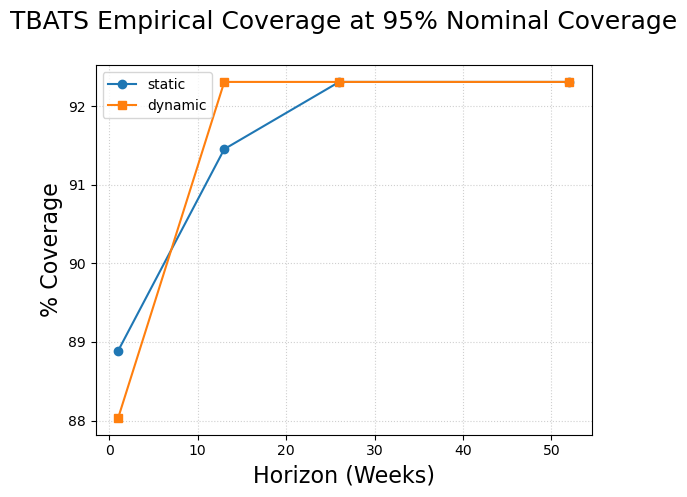

In [833]:
# plot interval coverage vs horizon

# I will plot only the 95% coverage since both 80% and 95% are so similar
filtered_coverage_df = coverage_df[coverage_df['level'] == 0.95]

plt.plot(figsize=(8,6))
plt.plot(filtered_coverage_df['horizon'], filtered_coverage_df['coverage_static']*100, label = 'static', marker='o')
plt.plot(filtered_coverage_df['horizon'], filtered_coverage_df['coverage_dynamic']*100, label = 'dynamic', marker='s')
plt.title('TBATS Empirical Coverage at 95% Nominal Coverage\n', fontsize=18)
plt.xlabel('Horizon (Weeks)', fontsize=16)
plt.ylabel('% Coverage', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

These results reveal a substantial problem for predictions intervals.

The interval coverge indicates that a 95% prediction interval contains the true value only 13-22% of the time, which is severe undercoverage.  The model's intervals are far too narrow (the model is too confident). 

### ARIMAX + FT

In [617]:
# rolling seasonal CRPS on ARIMAX(1,1,1) + FT(K=4) mean model + GARCH variance model

rolling_crps_dynamic_arimax = me.rolling_crps(
    y=train_preprocessed,
    model_type='sarima',
    model_params={
        'order':(1,1,1),
        'seasonal_order':(0,0,0,0),
        'trend':'n',
        'enforce_stationarity':True,
        'enforce_invertibility':True
    },
    exog=arimax_exog,                  # K = 4
    variance_type='garch',
    variance_params={'p':1, 'q':1},
    horizons=(1,13,26,52),
    step=13
)

In [834]:
# Check rolling_crps function call output to determine if every origin produced forecasts for all horizons
# number of origins: (sample length - start size - 52) / 13
folds_dynamic_arimax = rolling_crps_dynamic_arimax.groupby('horizon').size()

# Check for healthy predictive distribution degradation over increasing forecast horizons
# expect 1 < 13 < 26 < 52
crps_dynamic_arimax = rolling_crps_dynamic_arimax.groupby('horizon')['crps'].mean()

# calibration diagnostics
pit_dynamic_arimax = rolling_crps_dynamic_arimax.groupby('horizon')['pit'].mean()

print('Rolling-origin ARIMAX(1,1,1)+FT(K=4) with GARCH (dynamic sigma)')
print('\nNumber of origins (structural correctness)')
print(folds_dynamic_arimax)
print('\nCRPS (forecast coherence)')
print(crps_dynamic_arimax)
print('\nPIT (calibration diagnostics)')
print(pit_dynamic_arimax)

Rolling-origin ARIMAX(1,1,1)+FT(K=4) with GARCH (dynamic sigma)

Number of origins (structural correctness)
horizon
1     117
13    117
26    117
52    117
dtype: int64

CRPS (forecast coherence)
horizon
1     2.766598
13    6.588232
26    6.867223
52    7.647662
Name: crps, dtype: float64

PIT (calibration diagnostics)
horizon
1     0.546100
13    0.566115
26    0.606581
52    0.666351
Name: pit, dtype: float64


In [619]:
# rolling seasonal CRPS on ARIMAX(1,1,1) + FT(K=4) mean model variance model (without GARCH)

rolling_crps_static_arimax = me.rolling_crps(
    y=train_preprocessed,
    model_type='sarima',
    model_params={
        'order':(1,1,1),
        'seasonal_order':(0,0,0,0),
        'trend':'n',
        'enforce_stationarity':True,
        'enforce_invertibility':True
    },
    exog=None,                 
    horizons=(1,13,26,52),
    step=13
)

In [835]:
# Check rolling_crps function call output to determine if every origin produced forecasts for all horizons
# number of origins: (sample length - start size - 52) / 13
folds_static_arimax = rolling_crps_static_arimax.groupby('horizon').size()

# Check for healthy predictive distribution degradation over increasing forecast horizons
# expect 1 < 13 < 26 < 52
crps_static_arimax = rolling_crps_static_arimax.groupby('horizon')['crps'].mean()

# calibration diagnostics
pit_static_arimax = rolling_crps_static_arimax.groupby('horizon')['pit'].mean()

print('Rolling-origin ARIMAX(1,1,1)+FT(K=4) without GARCH (static/global sigma)')
print('\nNumber of origins (structural correctness)')
print(folds_static_arimax)
print('\nCRPS (forecast coherence)')
print(crps_static_arimax)
print('\nPIT (calibration diagnostics)')
print(pit_static_arimax)

Rolling-origin ARIMAX(1,1,1)+FT(K=4) without GARCH (static/global sigma)

Number of origins (structural correctness)
horizon
1     117
13    117
26    117
52    117
dtype: int64

CRPS (forecast coherence)
horizon
1      3.097656
13    10.670885
26    12.251375
52    10.777274
Name: crps, dtype: float64

PIT (calibration diagnostics)
horizon
1     0.523934
13    0.505349
26    0.535571
52    0.560914
Name: pit, dtype: float64


In [621]:
delta_crps_arimax = crps_static_arimax.values - crps_dynamic_arimax.values
delta_pit_arimax = pit_static_arimax.values - pit_dynamic_arimax.values

dynamic_vs_static_arimax_comp_df = pd.DataFrame({
    'folds': folds_dynamic_arimax,
    'CRPS (static)': crps_static_arimax.values,
    'CRPS (dynamic)': crps_dynamic_arimax.values,
    'delta CRPS': delta_crps_arimax,
    'PIT (static)': pit_static_arimax.values,
    'PIT (dynamic)': pit_dynamic_arimax.values,
    'delta PIT': delta_pit_arimax
})

print('CRPS and PIT Values at Specific Horizons - ARIMAX(1,1,1)+FT(K=4) +/- GARCH(1,1)\n')
dynamic_vs_static_arimax_comp_df.style.format('{:.6f}')

CRPS and PIT Values at Specific Horizons - ARIMAX(1,1,1)+FT(K=4) +/- GARCH(1,1)



In [877]:
# calcualate mean forecast error (y_true - y_hat(mu)), mean PIT, and mean CRPS at each horizon for each model

arimax_cond_var_comp = []

for h in horizons:
    # filter the rolling_crps() function call DataFrame for the specific horizons
    arimax_statH = rolling_crps_static_arimax[rolling_crps_static_arimax['horizon'] == h]
    arimax_dynH = rolling_crps_dynamic_arimax[rolling_crps_dynamic_arimax['horizon'] == h]

    # calculate mean forecast error (mfe) for each horizon
    mfe_statH = (arimax_statH['y_true'] - arimax_statH['mu']).mean()
    mfe_dynH = (arimax_dynH['y_true'] - arimax_dynH['mu']).mean()
    mean_pit_statH = arimax_statH['pit'].mean()
    mean_pit_dynH = arimax_dynH['pit'].mean()
    mean_crps_statH = arimax_statH['crps'].mean()
    mean_crps_dynH = arimax_dynH['crps'].mean()
    
    arimax_cond_var_comp.append({
        'Horizon':h, 
        'MFE(static)':mfe_statH, 
        'MFE(dynamic)':mfe_dynH,
        'Mean PIT(static)':mean_pit_statH,
        'Mean PIT(dynamic)':mean_pit_dynH,
        'Mean CRPS(static)':mean_crps_statH,
        'Mean CRPS(dynamic)':mean_crps_dynH
    })

# confert list to DataFrame
arimax_cond_var_comp_df = pd.DataFrame(arimax_cond_var_comp)
arimax_cond_var_comp_df   

Horizon  MFE(static)  MFE(dynamic)  Mean PIT(static)  Mean PIT(dynamic)  \
0        1     0.442449      0.653277          0.523934           0.546100   
1       13     1.436169      2.598200          0.505349           0.566115   
2       26     3.061339      4.397711          0.535571           0.606581   
3       52     6.071986      7.283269          0.560914           0.666351   

   Mean CRPS(static)  Mean CRPS(dynamic)  
0           3.097656            2.766598  
1          10.670885            6.588232  
2          12.251375            6.867223  
3          10.777274            7.647662

#### PIT histograms 

probability integral transform

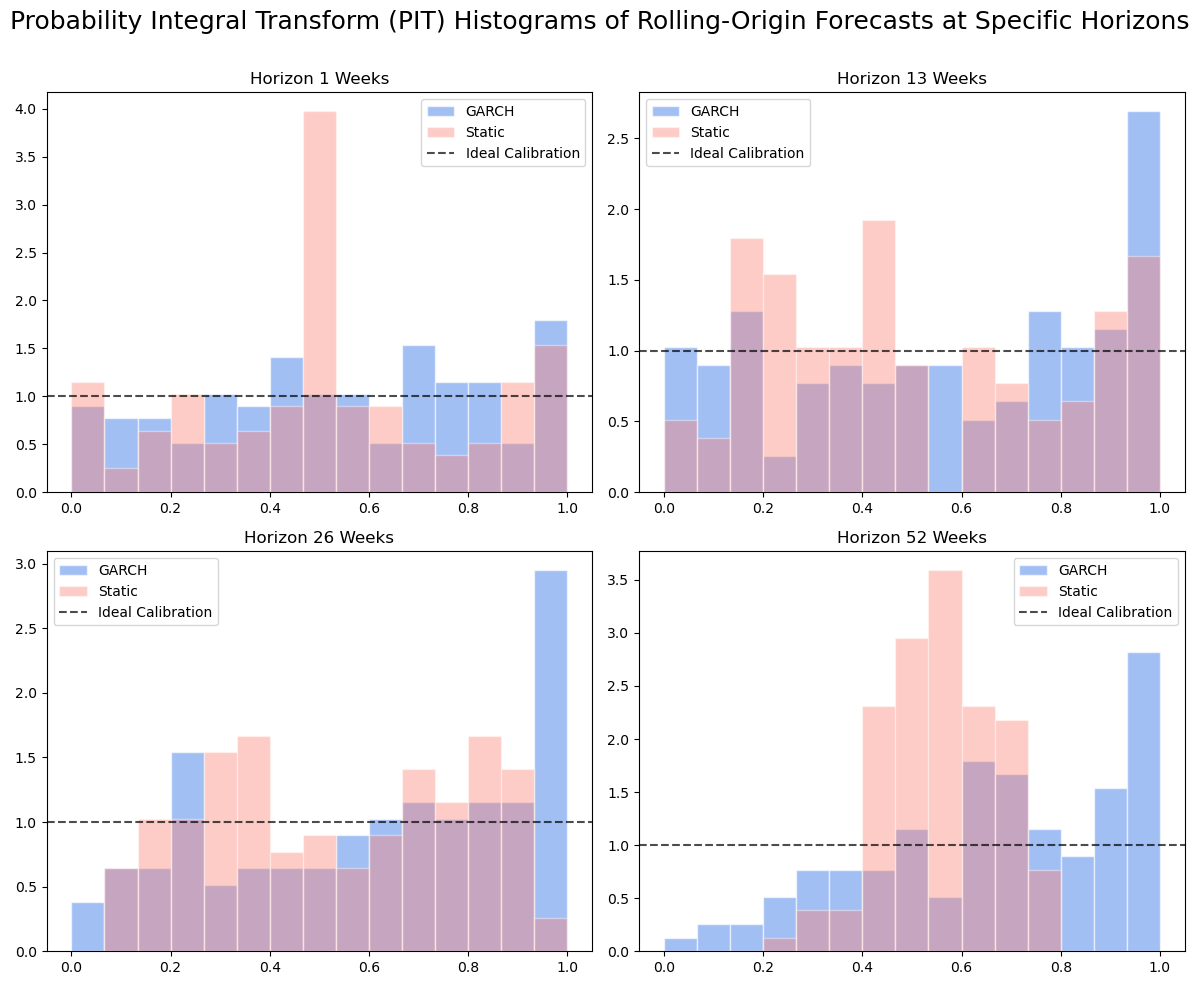

In [674]:
horizons = [1,13,26,52]
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()
common_bins = np.linspace(0,1,16)  # align bins

for i, h in enumerate(horizons):
    # filter the dynamic sigma (GARCH) PIT values 
    dynamic_pits_arimax = rolling_crps_dynamic_arimax[rolling_crps_dynamic_arimax['horizon'] == h]['pit']

    # filter the static/global sigma (no GARCH) PIT values 
    static_pits_arimax = rolling_crps_static_arimax[rolling_crps_static_arimax['horizon'] == h]['pit']

    # plot both on axes[i]
    axes[i].hist(dynamic_pits_arimax, bins=common_bins, alpha=0.6, label='GARCH', color='cornflowerblue', edgecolor='white', density=True)
    axes[i].hist(static_pits_arimax, bins=common_bins, alpha=0.4, label='Static', color='salmon', edgecolor='white', density=True)

    # add a reference ling at 1.0 (uniform distribution)
    axes[i].axhline(1, color='black', linestyle='--', alpha=0.7, label='Ideal Calibration')
    axes[i].set_title(f'Horizon {h} Weeks')
    axes[i].legend()

plt.suptitle('Probability Integral Transform (PIT) Histograms of Rolling-Origin Forecasts at Specific Horizons\n', fontsize=18)
plt.tight_layout()
plt.show()

#### Interval coverage

In [836]:
# compute coverage per horizon

levels = [0.80, 0.95]
rows = []

for h in [1,13,26,52]:
    dyn_h_arimax = rolling_crps_dynamic_arimax[rolling_crps_dynamic_arimax['horizon'] == h]
    stat_h_arimax = rolling_crps_static_arimax[rolling_crps_static_arimax['horizon'] == h]

    for lvl in levels:
        rows.append({
            'horizon': h,
            'level': lvl,
            'coverage_dynamic_arimax': me.interval_coverage(dyn_h_arimax, lvl),
            'coverage_static_arimax': me.interval_coverage(stat_h_arimax, lvl)
        })

arimax_coverage_df = pd.DataFrame(rows)

print('Coverage per Horizon for ARIMAX(1,1,1)+FT(K=4) +/- GARCH(1,1)\n')
arimax_coverage_df

Coverage per Horizon for ARIMAX(1,1,1)+FT(K=4) +/- GARCH(1,1)



horizon  level  coverage_dynamic_arimax  coverage_static_arimax
0        1   0.80                 0.786325                0.777778
1        1   0.95                 0.880342                0.880342
2       13   0.80                 0.692308                0.803419
3       13   0.95                 0.871795                0.948718
4       26   0.80                 0.717949                0.948718
5       26   0.95                 0.931624                0.991453
6       52   0.80                 0.760684                1.000000
7       52   0.95                 0.923077                1.000000

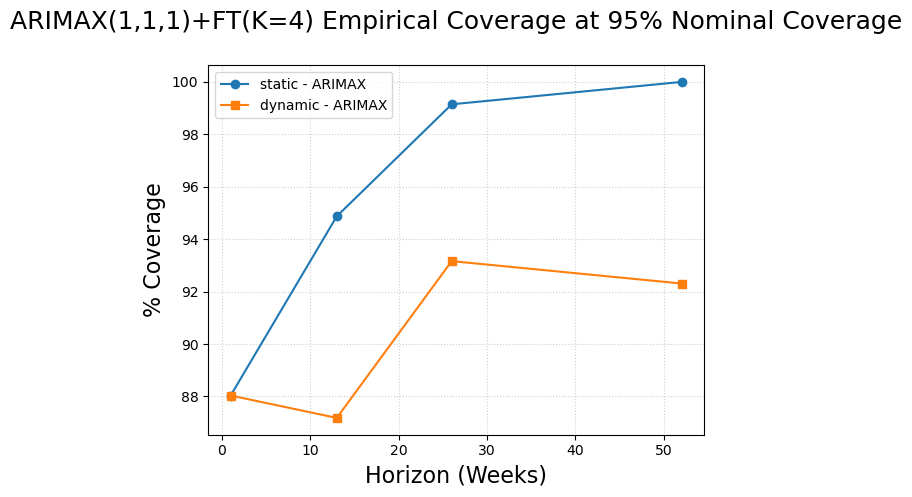

In [837]:
# plot interval coverage vs horizon

# I will plot only the 95% coverage since both 80% and 95% are so similar
arimax_filtered_coverage_df = arimax_coverage_df[coverage_df['level'] == 0.95]

plt.plot(figsize=(8,6))
plt.plot(arimax_filtered_coverage_df['horizon'], arimax_filtered_coverage_df['coverage_static_arimax']*100, label = 'static - ARIMAX', marker='o')
plt.plot(arimax_filtered_coverage_df['horizon'], arimax_filtered_coverage_df['coverage_dynamic_arimax']*100, label = 'dynamic - ARIMAX', marker='s')
plt.title('ARIMAX(1,1,1)+FT(K=4) Empirical Coverage at 95% Nominal Coverage\n', fontsize=18)
plt.xlabel('Horizon (Weeks)', fontsize=16)
plt.ylabel('% Coverage', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

### TBATS vs ARIMAX - interval coverage

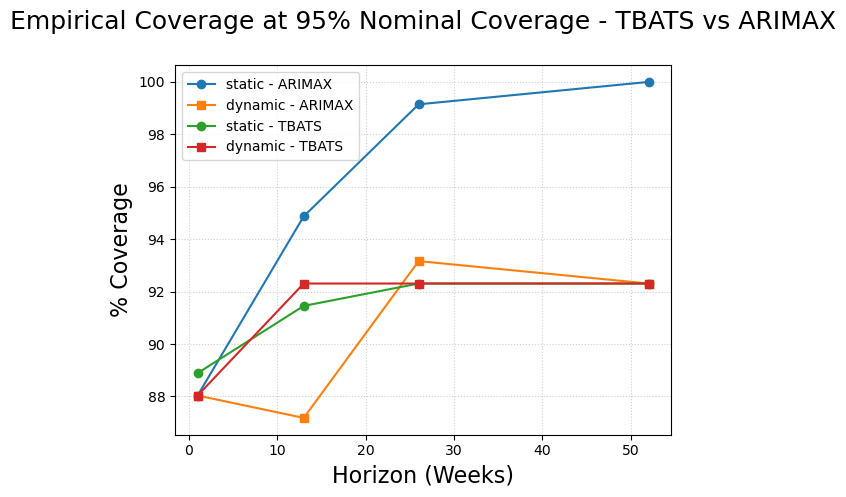

In [838]:
# plot interval coverage vs horizon

# I will plot only the 95% coverage since both 80% and 95% are so similar
arimax_filtered_coverage_df = arimax_coverage_df[coverage_df['level'] == 0.95]

plt.plot(figsize=(8,6))
# ARIMAX results
plt.plot(arimax_filtered_coverage_df['horizon'], arimax_filtered_coverage_df['coverage_static_arimax']*100, label = 'static - ARIMAX', marker='o')
plt.plot(arimax_filtered_coverage_df['horizon'], arimax_filtered_coverage_df['coverage_dynamic_arimax']*100, label = 'dynamic - ARIMAX', marker='s')
# overlay the TBATS result
plt.plot(filtered_coverage_df['horizon'], filtered_coverage_df['coverage_static']*100, label = 'static - TBATS', marker='o')
plt.plot(filtered_coverage_df['horizon'], filtered_coverage_df['coverage_dynamic']*100, label = 'dynamic - TBATS', marker='s')

plt.title('Empirical Coverage at 95% Nominal Coverage - TBATS vs ARIMAX\n', fontsize=18)
plt.xlabel('Horizon (Weeks)', fontsize=16)
plt.ylabel('% Coverage', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

**Probabilistic model results summary**

- TBATS and ARIMAX, both +/- GARCH are overconfident (under-dispersed) according to PIT histograms
- TBATS and ARIMAX, both +/- GARCH, all substantially under-cover at all horizons, especially medium and long horizons.
- GARCH greatly helps the ARIMAX model at medium horizons (13 and 26).
- By h = 52 (weeks), mean uncertainty is dominating for both mean models, GARCH has mean reverted and is no longer helping.

“Neither TBATS nor ARIMAX, with Gaussian innovations and conditional variance modeling, produces calibrated long-horizon probabilistic forecasts for atmospheric CH4. Mean dynamics and uncertainty dynamics are fundamentally decoupled in this system.”

What comes after coverage (don’t do yet)

Once coverage confirms underdispersion, options are:
- Variance inflation by horizon
- State-space uncertainty propagation
- Regime-dependent variance
- Scenario-based envelopes
- Comparing TBATS vs ARIMAX uncertainty growth
- But none of that makes sense until coverage is computed.

### TBATS(bc=F,dt=F) + GARCH(1,1)

In [678]:
# rolling seasonal CRPS on TBATS mean model (damped_trend = False) + GARCH variance model

rolling_crps_dynamic_tbats_dtf = me.rolling_crps(
    y=train_preprocessed,
    model_type='tbats',
    model_params={
        'use_box_cox':False,
        'use_trend':True,
        'use_damped_trend':False,
        'sp':[52.178],
        'use_arma_errors':True
    },
    variance_type='garch',
    variance_params={'p':1, 'q':1},
    horizons=(1,13,26,52),
    step=13
)

In [839]:
# Check rolling_crps function call output to determine if every origin produced forecasts for all horizons
# number of origins: (sample length - start size - 52) / 13
folds_dynamic_dtf = rolling_crps_dynamic_tbats_dtf.groupby('horizon').size()

# Check for healthy predictive distribution degradation over increasing forecast horizons
# expect 1 < 13 < 26 < 52
crps_dynamic_dtf = rolling_crps_dynamic_tbats_dtf.groupby('horizon')['crps'].mean()

# calibration diagnostics
pit_dynamic_dtf = rolling_crps_dynamic_tbats_dtf.groupby('horizon')['pit'].mean()

print('Rolling-origin TBATS (damped_trend=False) with GARCH (dynamic sigma)')
print('\nNumber of origins (structural correctness)')
print(folds_dynamic_dtf)
print('\nCRPS (forecast coherence)')
print(crps_dynamic_dtf)
print('\nPIT (calibration diagnostics)')
print(pit_dynamic_dtf)

Rolling-origin TBATS (damped_trend=False) with GARCH (dynamic sigma)

Number of origins (structural correctness)
horizon
1     117
13    117
26    117
52    117
dtype: int64

CRPS (forecast coherence)
horizon
1      2.796666
13     6.848300
26     8.344558
52    12.235113
Name: crps, dtype: float64

PIT (calibration diagnostics)
horizon
1     0.497681
13    0.500046
26    0.503672
52    0.504475
Name: pit, dtype: float64


#### PIT histograms

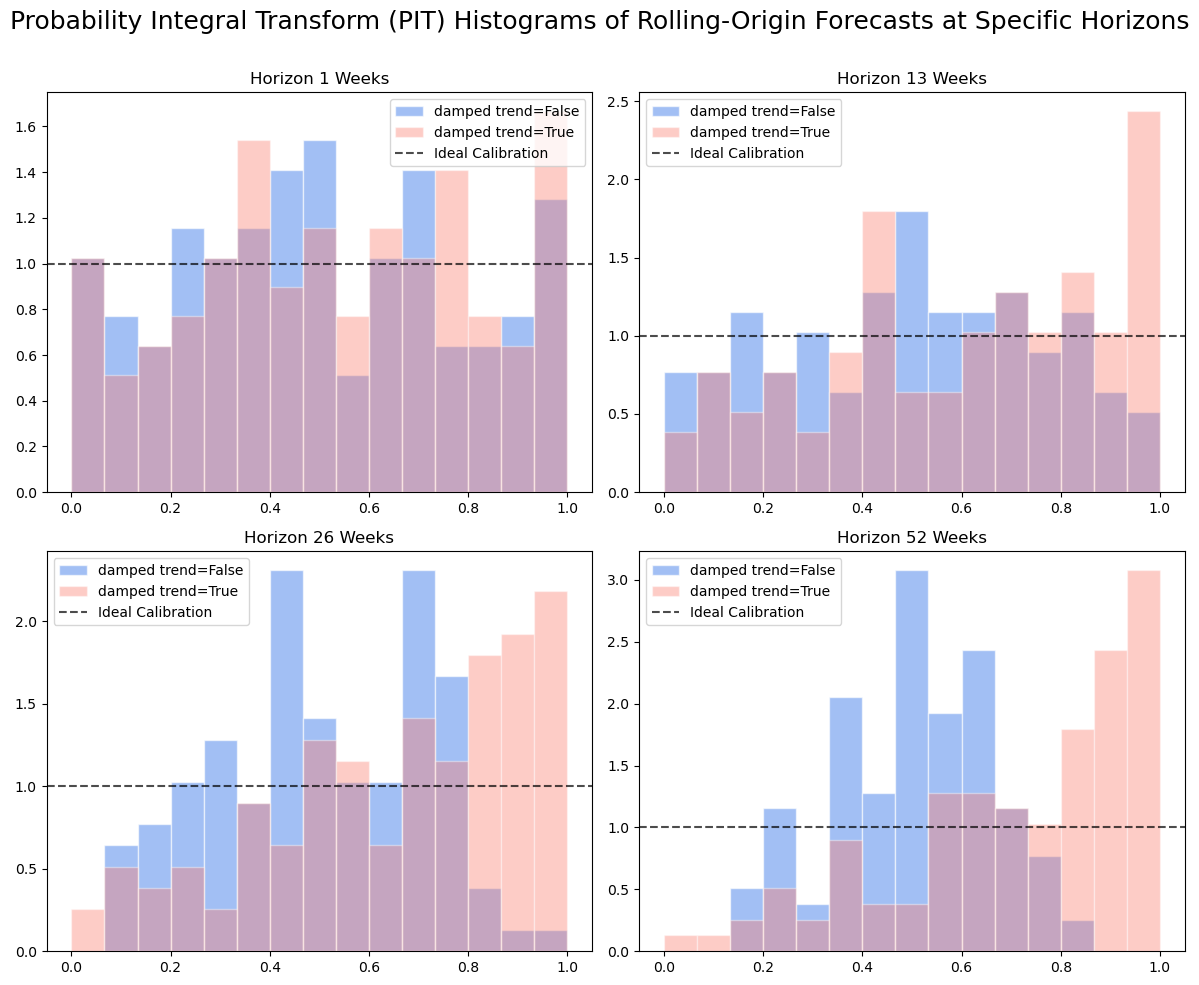

In [698]:
horizons = [1,13,26,52]
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()
common_bins = np.linspace(0,1,16)  # align the 15 bins

for i, h in enumerate(horizons):
    # filter the dynamic sigma (GARCH) PIT values 
    dynamic_pits_dtf = rolling_crps_dynamic_tbats_dtf[rolling_crps_dynamic_tbats_dtf['horizon'] == h]['pit']

    # filter the static/global sigma (no GARCH) PIT values 
    dynamic_pits = rolling_crps_dynamic_tbats[rolling_crps_dynamic_tbats['horizon'] == h]['pit']

    # plot both on axes[i]
    axes[i].hist(dynamic_pits_dtf, bins=common_bins, alpha=0.6, label='damped trend=False', color='cornflowerblue', edgecolor='white', density=True)
    axes[i].hist(dynamic_pits, bins=common_bins, alpha=0.4, label='damped trend=True', color='salmon', edgecolor='white', density=True)

    # add a reference ling at 1.0 (uniform distribution)
    axes[i].axhline(1, color='black', linestyle='--', alpha=0.7, label='Ideal Calibration')
    axes[i].set_title(f'Horizon {h} Weeks')
    axes[i].legend()

plt.suptitle('Probability Integral Transform (PIT) Histograms of Rolling-Origin Forecasts at Specific Horizons\n', fontsize=18)
plt.tight_layout()
plt.show()

#### Interval coverage

In [840]:
# compute coverage per horizon

levels = [0.80, 0.95]
rows = []

for h in [1,13,26,52]:
    dyn_h_tbats_dtf = rolling_crps_dynamic_tbats_dtf[rolling_crps_dynamic_tbats_dtf['horizon'] == h]
    dyn_h_tbats_dtt = rolling_crps_dynamic_tbats[rolling_crps_dynamic_tbats['horizon'] == h]

    for lvl in levels:
        rows.append({
            'horizon': h,
            'level': lvl,
            'coverage_dynamic_tbats_dtf': me.interval_coverage(dyn_h_tbats_dtf, lvl),
            'coverage_dynamic_tbats_dtt': me.interval_coverage(dyn_h_tbats_dtt, lvl)
        })

tbats_dt_coverage_df = pd.DataFrame(rows)

print('Coverage per Horizon for TBATS + GARCH(1,1), damped_trend=True vs False\n')
tbats_dt_coverage_df

Coverage per Horizon for TBATS + GARCH(1,1), damped_trend=True vs False



horizon  level  coverage_dynamic_tbats_dtf  coverage_dynamic_tbats_dtt
0        1   0.80                    0.803419                    0.794872
1        1   0.95                    0.880342                    0.880342
2       13   0.80                    0.854701                    0.777778
3       13   0.95                    0.991453                    0.923077
4       26   0.80                    0.982906                    0.786325
5       26   0.95                    1.000000                    0.923077
6       52   0.80                    1.000000                    0.717949
7       52   0.95                    1.000000                    0.923077

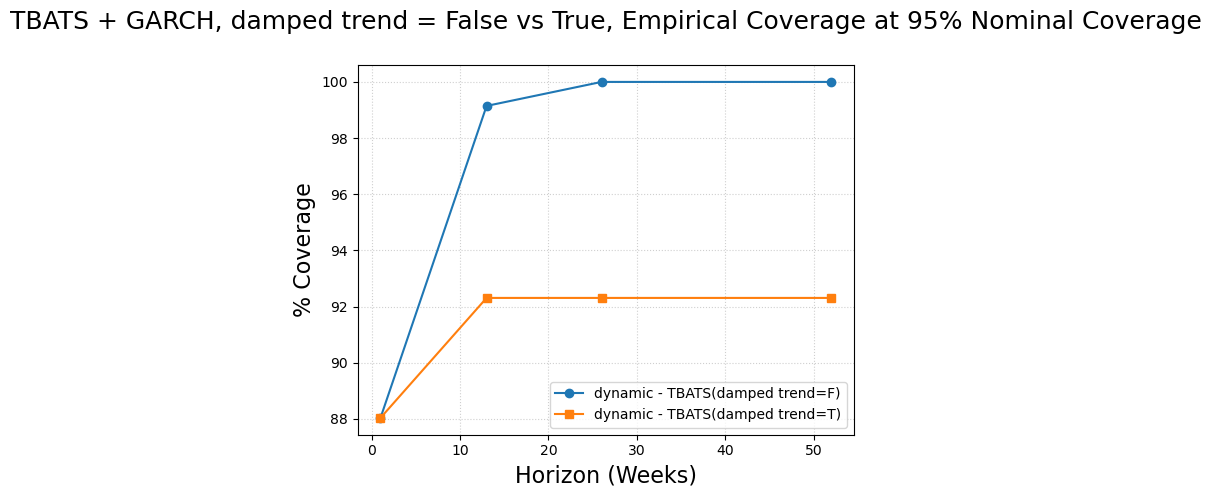

In [841]:
# plot interval coverage vs horizon

# I will plot only the 95% coverage since both 80% and 95% are so similar
tbats_dt_filtered_coverage_df = tbats_dt_coverage_df[tbats_dt_coverage_df['level'] == 0.95]

plt.plot(figsize=(8,6))
plt.plot(tbats_dt_filtered_coverage_df['horizon'], tbats_dt_filtered_coverage_df['coverage_dynamic_tbats_dtf']*100, label = 'dynamic - TBATS(damped trend=F)', marker='o')
plt.plot(tbats_dt_filtered_coverage_df['horizon'], tbats_dt_filtered_coverage_df['coverage_dynamic_tbats_dtt']*100, label = 'dynamic - TBATS(damped trend=T)', marker='s')
plt.title('TBATS + GARCH, damped trend = False vs True, Empirical Coverage at 95% Nominal Coverage\n', fontsize=18)
plt.xlabel('Horizon (Weeks)', fontsize=16)
plt.ylabel('% Coverage', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

### TBATS(bc=T,dt=T) + GARCH(1,1)

In [681]:
# rolling seasonal CRPS on TBATS mean model (Box-Cox = True) + GARCH variance model

rolling_crps_dynamic_tbats_bc = me.rolling_crps(
    y=train_preprocessed,
    model_type='tbats',
    model_params={
        'use_box_cox':True,
        'use_trend':True,
        'use_damped_trend':True,
        'sp':[52.178],
        'use_arma_errors':True
    },
    variance_type='garch',
    variance_params={'p':1, 'q':1},
    horizons=(1,13,26,52),
    step=13
)

In [842]:
# Check rolling_crps function call output to determine if every origin produced forecasts for all horizons
# number of origins: (sample length - start size - 52) / 13
folds_dynamic_bc = rolling_crps_dynamic_tbats_bc.groupby('horizon').size()

# Check for healthy predictive distribution degradation over increasing forecast horizons
# expect 1 < 13 < 26 < 52
crps_dynamic_bc = rolling_crps_dynamic_tbats_bc.groupby('horizon')['crps'].mean()

# calibration diagnostics
pit_dynamic_bc = rolling_crps_dynamic_tbats_bc.groupby('horizon')['pit'].mean()

print('Rolling-origin TBATS (Box-Cox=True) with GARCH (dynamic sigma)')
print('\nNumber of origins (structural correctness)')
print(folds_dynamic_bc)
print('\nCRPS (forecast coherence)')
print(crps_dynamic_bc)
print('\nPIT (calibration diagnostics)')
print(pit_dynamic_bc)

Rolling-origin TBATS (Box-Cox=True) with GARCH (dynamic sigma)

Number of origins (structural correctness)
horizon
1     117
13    117
26    117
52    117
dtype: int64

CRPS (forecast coherence)
horizon
1     2.698985
13    5.400366
26    6.141339
52    7.483737
Name: crps, dtype: float64

PIT (calibration diagnostics)
horizon
1     0.531593
13    0.603609
26    0.656795
52    0.715835
Name: pit, dtype: float64


#### PIT histograms

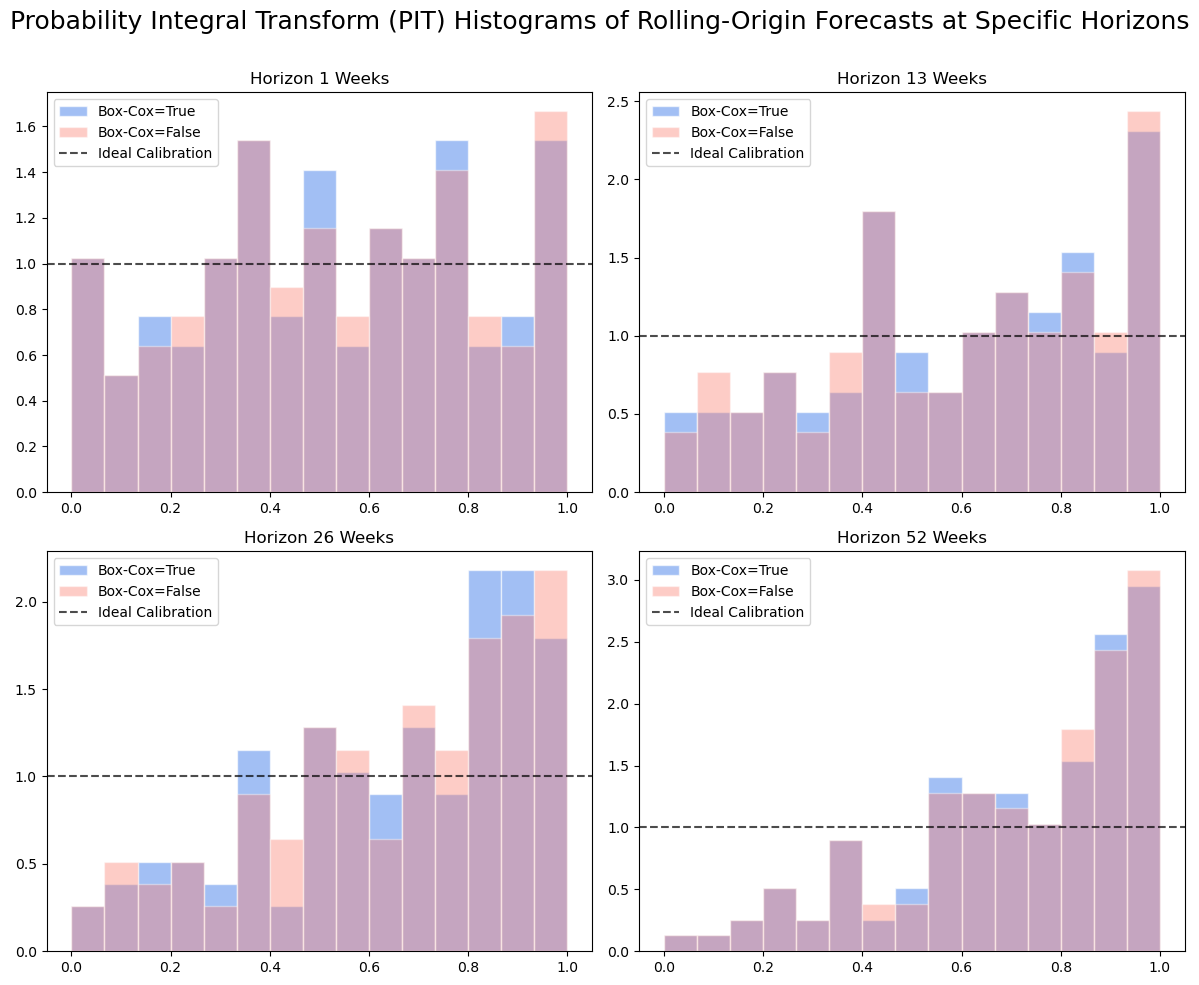

In [704]:
horizons = [1,13,26,52]
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()
common_bins = np.linspace(0,1,16)   # align bins

for i, h in enumerate(horizons):
    # filter the dynamic sigma (GARCH) PIT values 
    dynamic_pits_bc = rolling_crps_dynamic_tbats_bc[rolling_crps_dynamic_tbats_bc['horizon'] == h]['pit']

    # filter the static/global sigma (no GARCH) PIT values 
    dynamic_pits = rolling_crps_dynamic_tbats[rolling_crps_dynamic_tbats['horizon'] == h]['pit']

    # plot both on axes[i]
    axes[i].hist(dynamic_pits_bc, bins=common_bins, alpha=0.6, label='Box-Cox=True', color='cornflowerblue', edgecolor='white', density=True)
    axes[i].hist(dynamic_pits, bins=common_bins, alpha=0.4, label='Box-Cox=False', color='salmon', edgecolor='white', density=True)

    # add a reference ling at 1.0 (uniform distribution)
    axes[i].axhline(1, color='black', linestyle='--', alpha=0.7, label='Ideal Calibration')
    axes[i].set_title(f'Horizon {h} Weeks')
    axes[i].legend()

plt.suptitle('Probability Integral Transform (PIT) Histograms of Rolling-Origin Forecasts at Specific Horizons\n', fontsize=18)
plt.tight_layout()
plt.show()

#### Interval coverage

In [843]:
# compute coverage per horizon

levels = [0.80, 0.95]
rows = []

for h in [1,13,26,52]:
    dyn_h_bcT_dtT = rolling_crps_dynamic_tbats_bc[rolling_crps_dynamic_tbats_bc['horizon'] == h]
    dyn_h_bcF_dtT = rolling_crps_dynamic_tbats[rolling_crps_static_tbats['horizon'] == h]

    for lvl in levels:
        rows.append({
            'horizon': h,
            'level': lvl,
            'coverage_dynamic_bcT_dtT': me.interval_coverage(dyn_h_bcT_dtT, lvl),
            'coverage_dynamic_bcF_dtT': me.interval_coverage(dyn_h_bcF_dtT, lvl)
        })

tbats_bc_coverage_df = pd.DataFrame(rows)
tbats_bc_coverage_df

horizon  level  coverage_dynamic_bcT_dtT  coverage_dynamic_bcF_dtT
0        1   0.80                  0.811966                  0.794872
1        1   0.95                  0.888889                  0.880342
2       13   0.80                  0.786325                  0.777778
3       13   0.95                  0.923077                  0.923077
4       26   0.80                  0.777778                  0.786325
5       26   0.95                  0.923077                  0.923077
6       52   0.80                  0.717949                  0.717949
7       52   0.95                  0.931624                  0.923077

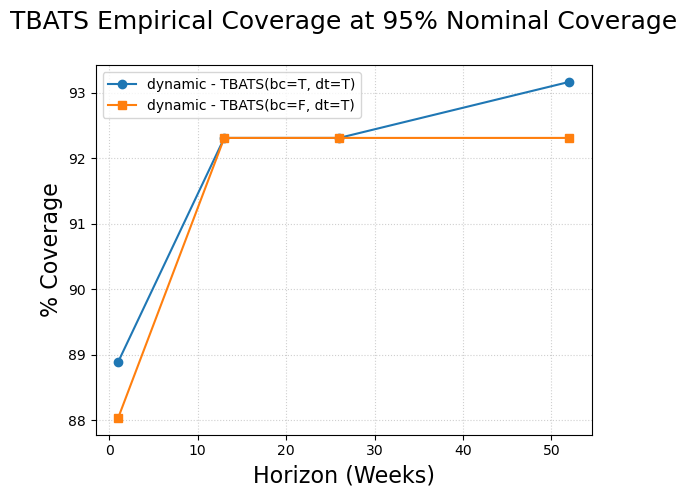

In [844]:
# plot interval coverage vs horizon

# I will plot only the 95% coverage since both 80% and 95% are so similar
tbats_bc_filtered_coverage_df = tbats_bc_coverage_df[tbats_bc_coverage_df['level'] == 0.95]

plt.plot(figsize=(8,6))
plt.plot(tbats_bc_filtered_coverage_df['horizon'], tbats_bc_filtered_coverage_df['coverage_dynamic_bcT_dtT']*100, label = 'dynamic - TBATS(bc=T, dt=T)', marker='o')
plt.plot(tbats_bc_filtered_coverage_df['horizon'], tbats_bc_filtered_coverage_df['coverage_dynamic_bcF_dtT']*100, label = 'dynamic - TBATS(bc=F, dt=T)', marker='s')
plt.title('TBATS Empirical Coverage at 95% Nominal Coverage\n', fontsize=18)
plt.xlabel('Horizon (Weeks)', fontsize=16)
plt.ylabel('% Coverage', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

### TBATS(bc=T,dt=F) + GARCH(1,1)

In [684]:
# rolling seasonal CRPS on TBATS mean model (Box-Cox = True, damped_trend=False) + GARCH variance model

rolling_crps_dynamic_tbats_bc_dtf = me.rolling_crps(
    y=train_preprocessed,
    model_type='tbats',
    model_params={
        'use_box_cox':True,
        'use_trend':True,
        'use_damped_trend':False,
        'sp':[52.178],
        'use_arma_errors':True
    },
    variance_type='garch',
    variance_params={'p':1, 'q':1},
    horizons=(1,13,26,52),
    step=13
)

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\tbats\transformation\BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\tbats\transformation\BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\tbats\transformation\BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\tbats\transformation\BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\tbats\transformation\BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\tbats\transformation\BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\tbats\transformation\BoxCox

In [845]:
# Check rolling_crps function call output to determine if every origin produced forecasts for all horizons
# number of origins: (sample length - start size - 52) / 13
folds_dynamic_bc_dtf = rolling_crps_dynamic_tbats_bc_dtf.groupby('horizon').size()

# Check for healthy predictive distribution degradation over increasing forecast horizons
# expect 1 < 13 < 26 < 52
crps_dynamic_bc_dtf = rolling_crps_dynamic_tbats_bc_dtf.groupby('horizon')['crps'].mean()

# calibration diagnostics
pit_dynamic_bc_dtf = rolling_crps_dynamic_tbats_bc_dtf.groupby('horizon')['pit'].mean()

print('Rolling-origin TBATS (Box-Cox=True, damped trend=False) with GARCH (dynamic sigma)')
print('\nNumber of origins (structural correctness)')
print(folds_dynamic_bc_dtf)
print('\nCRPS (forecast coherence)')
print(crps_dynamic_bc_dtf)
print('\nPIT (calibration diagnostics)')
print(pit_dynamic_bc_dtf)

Rolling-origin TBATS (Box-Cox=True, damped trend=False) with GARCH (dynamic sigma)

Number of origins (structural correctness)
horizon
1     117
13    117
26    117
52    117
dtype: int64

CRPS (forecast coherence)
horizon
1      2.821209
13     6.890254
26     8.616682
52    12.857685
Name: crps, dtype: float64

PIT (calibration diagnostics)
horizon
1     0.494604
13    0.501988
26    0.506689
52    0.505449
Name: pit, dtype: float64


#### PIT histograms

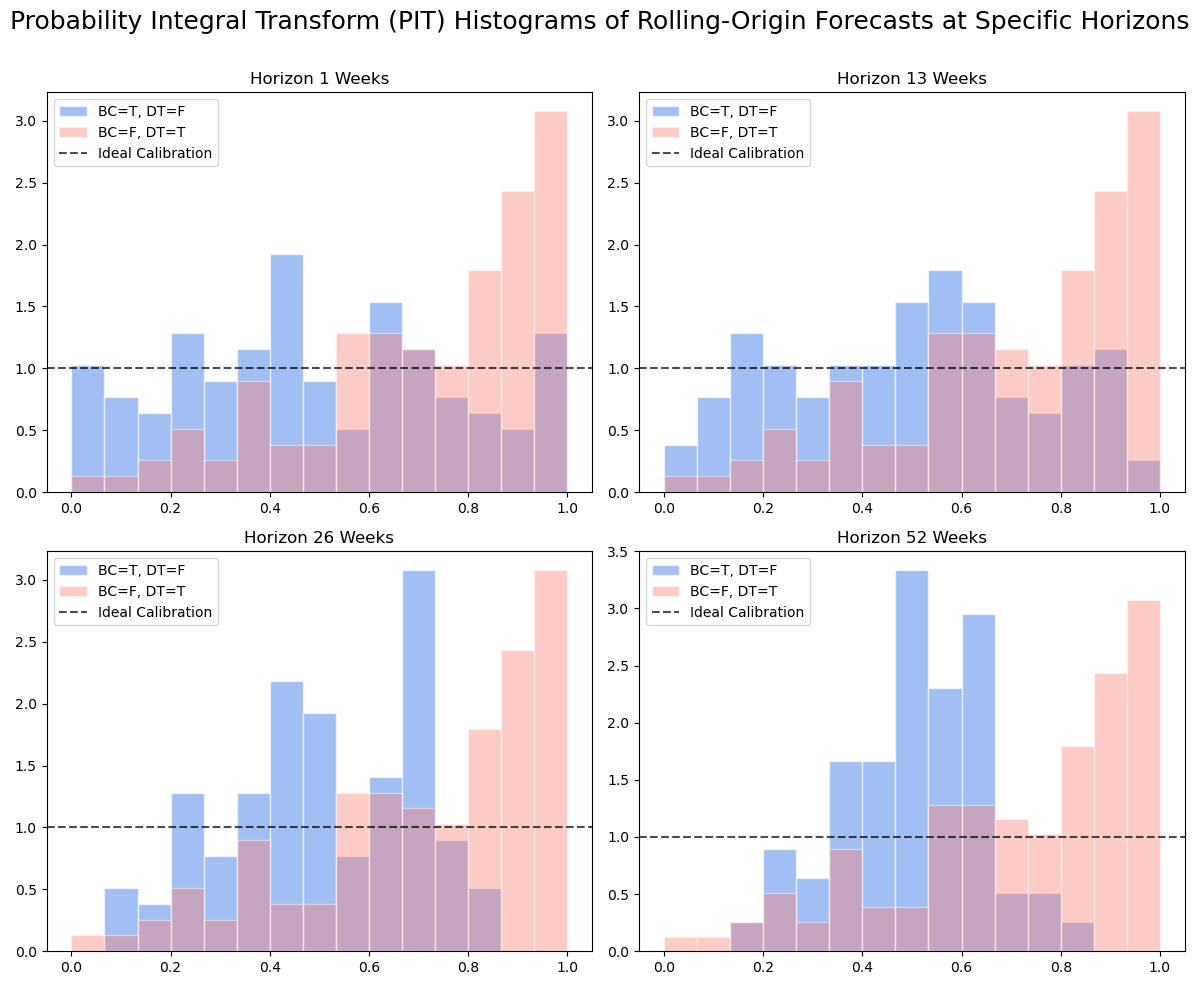

In [690]:
horizons = [1,13,26,52]
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()
common_bins = np.linspace(0,1,16)   # align bins

for i, h in enumerate(horizons):
    # filter the dynamic sigma (GARCH) PIT values 
    dynamic_pits_bc_dtf = rolling_crps_dynamic_tbats_bc_dtf[rolling_crps_dynamic_tbats_bc_dtf['horizon'] == h]['pit']

    # filter the static/global sigma (no GARCH) PIT values 
    # static_pits_bc = rolling_crps_static_tbats_bc[rolling_crps_static_tbats_bc['horizon'] == h]['pit']

    # plot both on axes[i]
    axes[i].hist(dynamic_pits_bc_dtf, bins=common_bins, alpha=0.6, label='BC=T, DT=F', color='cornflowerblue', edgecolor='white', density=True)
    axes[i].hist(dynamic_pits, bins=common_bins, alpha=0.4, label='BC=F, DT=T', color='salmon', edgecolor='white', density=True)

    # add a reference ling at 1.0 (uniform distribution)
    axes[i].axhline(1, color='black', linestyle='--', alpha=0.7, label='Ideal Calibration')
    axes[i].set_title(f'Horizon {h} Weeks')
    axes[i].legend()

plt.suptitle('Probability Integral Transform (PIT) Histograms of Rolling-Origin Forecasts at Specific Horizons\n', fontsize=18)
plt.tight_layout()
plt.show()

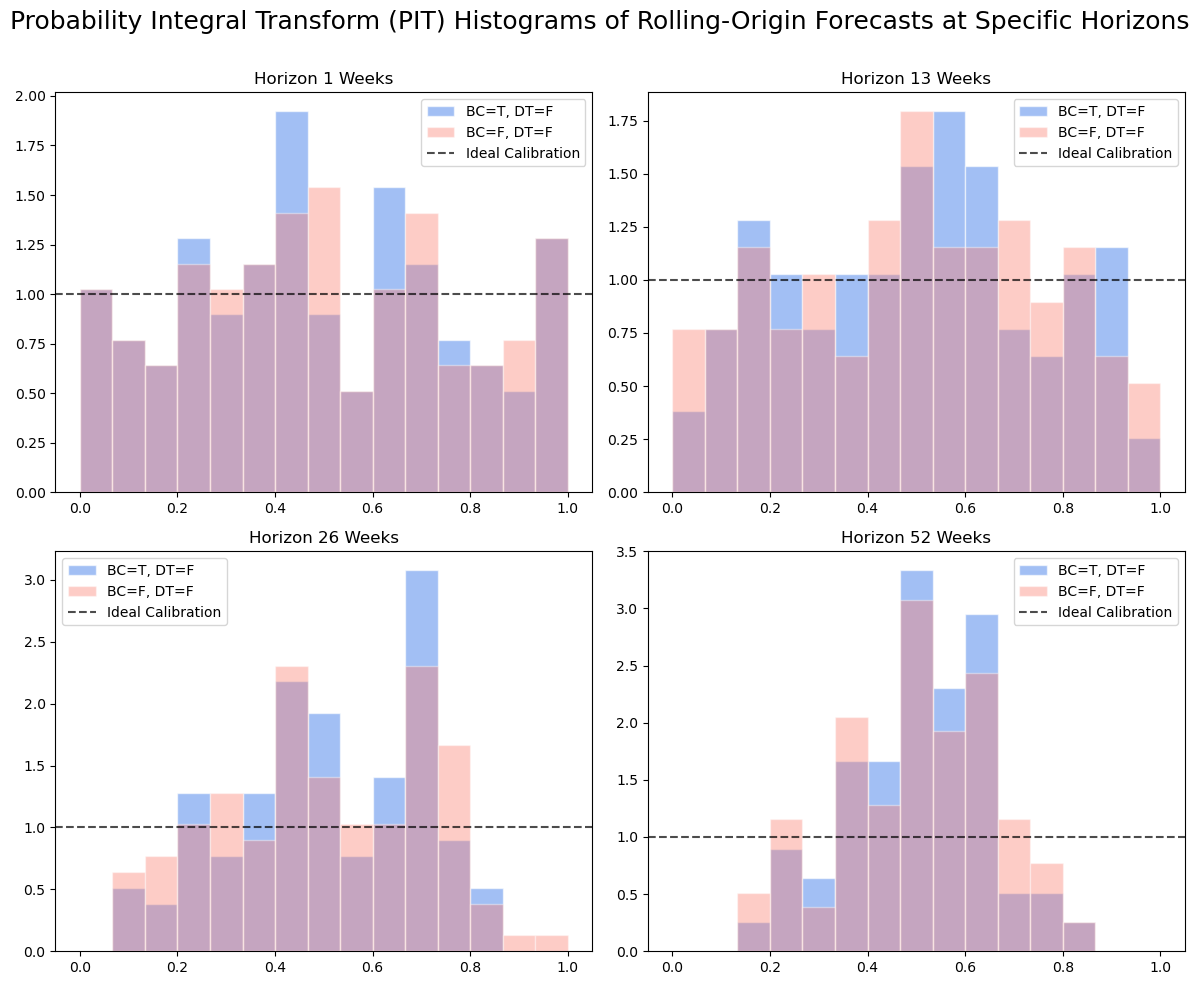

In [697]:
horizons = [1,13,26,52]
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()
common_bins = np.linspace(0,1,16)   # align bins

for i, h in enumerate(horizons):
    # filter the dynamic sigma (GARCH) PIT values 
    dynamic_pits_bc_dtf = rolling_crps_dynamic_tbats_bc_dtf[rolling_crps_dynamic_tbats_bc_dtf['horizon'] == h]['pit']

    # filter the static/global sigma (no GARCH) PIT values 
    dynamic_pits_dtf = rolling_crps_dynamic_tbats_dtf[rolling_crps_dynamic_tbats_dtf['horizon'] == h]['pit']

    # plot both on axes[i]
    axes[i].hist(dynamic_pits_bc_dtf, bins=common_bins, alpha=0.6, label='BC=T, DT=F', color='cornflowerblue', edgecolor='white', density=True)
    axes[i].hist(dynamic_pits_dtf, bins=common_bins, alpha=0.4, label='BC=F, DT=F', color='salmon', edgecolor='white', density=True)

    # add a reference ling at 1.0 (uniform distribution)
    axes[i].axhline(1, color='black', linestyle='--', alpha=0.7, label='Ideal Calibration')
    axes[i].set_title(f'Horizon {h} Weeks')
    axes[i].legend()

plt.suptitle('Probability Integral Transform (PIT) Histograms of Rolling-Origin Forecasts at Specific Horizons\n', fontsize=18)
plt.tight_layout()
plt.show()

#### Interval coverage

In [846]:
# compute coverage per horizon

levels = [0.80, 0.95]
rows = []

for h in [1,13,26,52]:
    dyn_h_bcT_dtF = rolling_crps_dynamic_tbats_bc_dtf[rolling_crps_dynamic_tbats_bc_dtf['horizon'] == h]
    dyn_h = rolling_crps_dynamic_tbats[rolling_crps_static_tbats['horizon'] == h]

    for lvl in levels:
        rows.append({
            'horizon': h,
            'level': lvl,
            'coverage_dynamic_bcT_dtF': me.interval_coverage(dyn_h_bcT_dtF, lvl),
            'coverage_dynamic': me.interval_coverage(dyn_h, lvl)
        })

tbats_bc_dt_coverage_df = pd.DataFrame(rows)
tbats_bc_dt_coverage_df

horizon  level  coverage_dynamic_bcT_dtF  coverage_dynamic
0        1   0.80                  0.794872          0.794872
1        1   0.95                  0.880342          0.880342
2       13   0.80                  0.897436          0.777778
3       13   0.95                  1.000000          0.923077
4       26   0.80                  0.991453          0.786325
5       26   0.95                  1.000000          0.923077
6       52   0.80                  1.000000          0.717949
7       52   0.95                  1.000000          0.923077

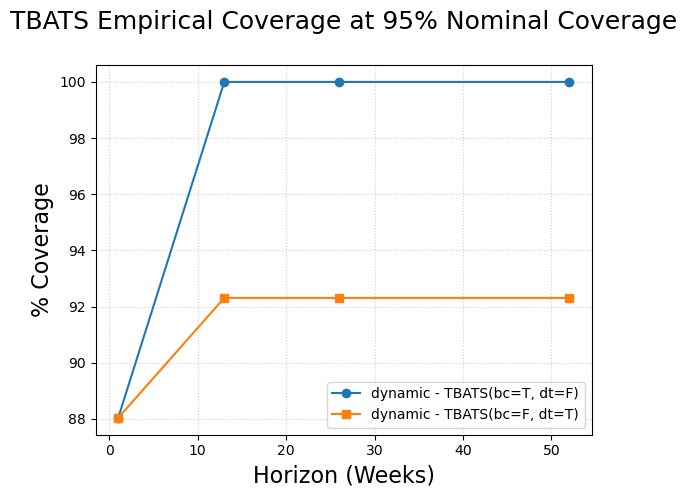

In [847]:
# plot interval coverage vs horizon

# I will plot only the 95% coverage since both 80% and 95% are so similar
tbats_bc_dt_filtered_coverage_df = tbats_bc_dt_coverage_df[tbats_bc_dt_coverage_df['level'] == 0.95]

plt.plot(figsize=(8,6))
plt.plot(tbats_bc_dt_filtered_coverage_df['horizon'], tbats_bc_dt_filtered_coverage_df['coverage_dynamic_bcT_dtF']*100, label = 'dynamic - TBATS(bc=T, dt=F)', marker='o')
plt.plot(tbats_bc_dt_filtered_coverage_df['horizon'], tbats_bc_dt_filtered_coverage_df['coverage_dynamic']*100, label = 'dynamic - TBATS(bc=F, dt=T)', marker='s')
plt.title('TBATS Empirical Coverage at 95% Nominal Coverage\n', fontsize=18)
plt.xlabel('Horizon (Weeks)', fontsize=16)
plt.ylabel('% Coverage', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

In [848]:
# compute coverage per horizon

levels = [0.80, 0.95]
rows = []

for h in [1,13,26,52]:
    dyn_h_bcT_dtF = rolling_crps_dynamic_tbats_bc_dtf[rolling_crps_dynamic_tbats_bc_dtf['horizon'] == h]
    dyn_h_bcF_dtF = rolling_crps_dynamic_tbats_dtf[rolling_crps_static_tbats['horizon'] == h]

    for lvl in levels:
        rows.append({
            'horizon': h,
            'level': lvl,
            'coverage_dynamic_bcT_dtF': me.interval_coverage(dyn_h_bcT_dtF, lvl),
            'coverage_dynamic_bcF_dtF': me.interval_coverage(dyn_h_bcF_dtF, lvl)
        })

tbats_bc_dt_coverage_df = pd.DataFrame(rows)
tbats_bc_dt_coverage_df

horizon  level  coverage_dynamic_bcT_dtF  coverage_dynamic_bcF_dtF
0        1   0.80                  0.794872                  0.803419
1        1   0.95                  0.880342                  0.880342
2       13   0.80                  0.897436                  0.854701
3       13   0.95                  1.000000                  0.991453
4       26   0.80                  0.991453                  0.982906
5       26   0.95                  1.000000                  1.000000
6       52   0.80                  1.000000                  1.000000
7       52   0.95                  1.000000                  1.000000

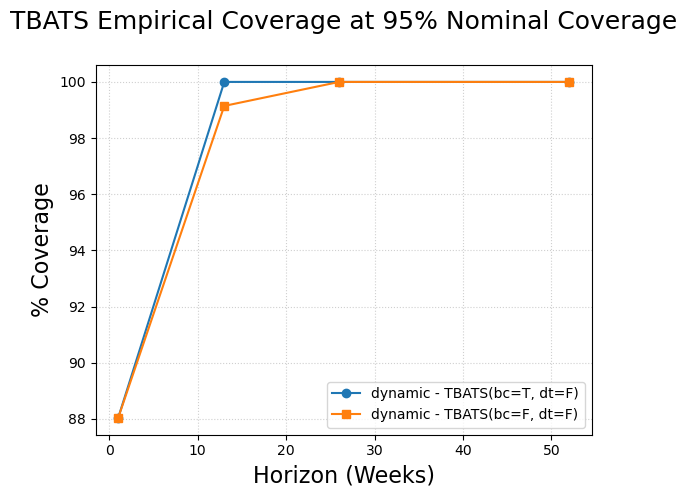

In [849]:
# plot interval coverage vs horizon

# I will plot only the 95% coverage since both 80% and 95% are so similar
tbats_bc_dt_filtered_coverage_df = tbats_bc_dt_coverage_df[tbats_bc_dt_coverage_df['level'] == 0.95]

plt.plot(figsize=(8,6))
plt.plot(tbats_bc_dt_filtered_coverage_df['horizon'], tbats_bc_dt_filtered_coverage_df['coverage_dynamic_bcT_dtF']*100, label = 'dynamic - TBATS(bc=T, dt=F)', marker='o')
plt.plot(tbats_dt_filtered_coverage_df['horizon'], tbats_dt_filtered_coverage_df['coverage_dynamic_tbats_dtf']*100, label = 'dynamic - TBATS(bc=F, dt=F)', marker='s')
plt.title('TBATS Empirical Coverage at 95% Nominal Coverage\n', fontsize=18)
plt.xlabel('Horizon (Weeks)', fontsize=16)
plt.ylabel('% Coverage', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

**Summary of rolling_crps including PIT and interval coverage results**

- CRPS result decides the best model (accuracy and sharpness)
- PIT diagnoses calibration (well calibrated, underconfident, overconfident)
- Interval coverage reports on reliability - the percent of times a observed values falls within the predicted range.

TBATS(bc=T, dt=F) achieves the best combination of mean PIT score and interval coverage, with the tradeoff of a substantial increase in CRPS at h=52 (12.86 vs 7.48), which is an overdispersed model.  
TBATS(bc=F, dt=F) has similar results but runtime warnings suggest some numerical instability.  

damped_trend = False is likely allowing the slope to random-walk producing substantial long-horizon variance and worsening sharpness at long-horizon.  

TBATS(bc=T, dt=T) produces the best combination of CRPS, PIT, and interval coverage.
- PIT drifting above 0.5:  PIT > 0.5 means that the actual value is above the forecast median.  The fact that the PIT scores steadily increase over 0.5 at increasing horizon length means that the actual value increasingly lie above the predicted distribution center/mean, which implicates bias (downward) in the predictive mean.  
- CRPS worsening when uncertainty expands meaning that increasing sigma only tried to compensate with variance leading to mean under forecasting (mean forecasts consistently too low).
- That means mean bias, not variance failure.
- Finally, the PIT values grow monotonically with horizon implicating a weak slope possibly due to trend damping that is too strong.  


Tune the trend strength, not the variance

You have three valid options, in order of increasing complexity:

Option A (recommended first): Tune damping
- Instead of dt=True/False:
- Estimate or grid-search damping ∈ [0.85, 0.98]
- Evaluate CRPS vs PIT drift
- This directly targets your observed issue:
- Mean too weak, uncertainty correct

Option B: Increase slope variance
- If your TBATS implementation allows:
- Higher trend state variance
- Or looser priors
- This allows mean trajectories to move without exploding uncertainty.

Option C: Add a low-frequency component

Examples:
- Fourier with very long period
- Piecewise linear trend
- Structural break allowance
- This is appropriate if the data truly has regime shifts.


How you will know you’re done?

You’re finished when you see:
- CRPS no longer improves with wider variance
- PIT stabilizes around ~0.55–0.65 at long horizons
- Coverage improves slightly but remains < nominal
- No runtime warnings
- Forecasts remain sharp
- That is honest probabilistic forecasting.
- Perfect PIT at h=52 is a red flag, not a goal.

Re-run PIT histograms
Re-run coverage
Decide how much horizon inflation is still needed
(Optional) Student-t innovations (studnet-t GARCH)
(Optional) DM test on CRPS

Apply horizon-dependent variance inflation to address the forecast uncertainty?? 

## Address the apparent problem with conditional mean

What is the mean model behavior, independent of variance modeling?

First, run two TBATS models +/- damped trend, with following parameters:
1. TBATS(bc=F,t=T,arma=T,dt=T), no GARCH
2. TBATS(bc=F,t=T,arma=T,dt=F), no GARCH

box_cox = False because box_cox=True with damped_trend=False results in a large number of runtime warnings.  

Compare:
- mean forecast error across horizons
- mean PIT across horizons
- CRPS across horizons

In [710]:
# 1. TBATS(bc=F,t=T,arma=T,dt=T), no GARCH

rolling_crps_static_tbats_dtT = me.rolling_crps(
    y=train_preprocessed,
    model_type='tbats',
    model_params={
        'use_box_cox':False,
        'use_trend':True,
        'use_damped_trend':True,
        'sp':[52.178],
        'use_arma_errors':True
    },
    variance_type='static',
    variance_params=None,
    horizons=(1,13,26,52),
    step=13
)

In [712]:
list(rolling_crps_static_tbats_dtT)

['origin',
 'horizon',
 'mu',
 'sigma',
 'y_true',
 'crps',
 'pit',
 'mean_model',
 'variance_model']

In [709]:
# 2. TBATS(bc=F,t=T,arma=T,dt=F), no GARCH

rolling_crps_static_tbats_dtF = me.rolling_crps(
    y=train_preprocessed,
    model_type='tbats',
    model_params={
        'use_box_cox':False,
        'use_trend':True,
        'use_damped_trend':False,
        'sp':[52.178],
        'use_arma_errors':True
    },
    variance_type='static',
    variance_params=None,
    horizons=(1,13,26,52),
    step=13
)

In [850]:
# calcualate mean forecast error (y_true - y_hat(mu)), mean PIT, and mean CRPS at each horizon for each model

mean_model_conditions_comp = []

for h in horizons:
    # filter the rolling_crps() function call DataFrame for the specific horizons
    dtT_h = rolling_crps_static_tbats_dtT[rolling_crps_static_tbats_dtT['horizon'] == h]
    dtF_h = rolling_crps_static_tbats_dtF[rolling_crps_static_tbats_dtF['horizon'] == h]

    # calculate mean forecast error (mfe) for each horizon
    mfe_dtT = (dtT_h['y_true'] - dtT_h['mu']).mean()
    mfe_dtF = (dtF_h['y_true'] - dtF_h['mu']).mean()
    mean_pit_dtT = dtT_h['pit'].mean()
    mean_pit_dtF = dtF_h['pit'].mean()
    mean_crps_dtT = dtT_h['crps'].mean()
    mean_crps_dtF = dtF_h['crps'].mean()
    
    mean_model_conditions_comp.append({
        'Horizon':h, 
        'MFE(dt=T)':mfe_dtT, 
        'MFE(dt=F)':mfe_dtF,
        'Mean PIT(dt=T)':mean_pit_dtT,
        'Mean PIT(dt=F)':mean_pit_dtF,
        'Mean CRPS(dt=T)':mean_crps_dtT,
        'Mean CRPS(dt=F)':mean_crps_dtF
    })

# confert list to DataFrame
mean_model_conditions_comp_df = pd.DataFrame(mean_model_conditions_comp)
mean_model_conditions_comp_df   

Horizon  MFE(dt=T)  MFE(dt=F)  Mean PIT(dt=T)  Mean PIT(dt=F)  \
0        1   0.393049  -0.150748        0.529274        0.493499   
1       13   3.466256  -0.248687        0.604187        0.499902   
2       26   5.393095  -0.001942        0.656330        0.503477   
3       52   8.406668   0.271279        0.718468        0.504346   

   Mean CRPS(dt=T)  Mean CRPS(dt=F)  
0         2.718206         2.805379  
1         5.425013         6.851051  
2         6.109206         8.331171  
3         7.490171        12.185174

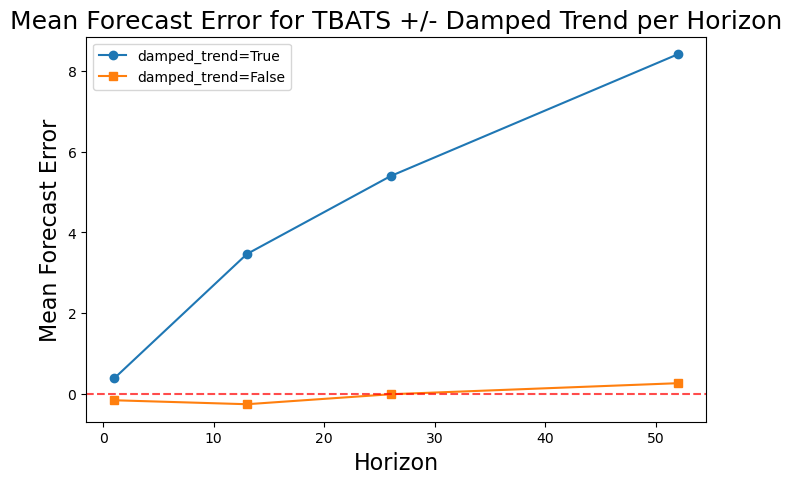

In [851]:
# plot mean forecast errors

plt.figure(figsize=(8,5))
plt.plot(mean_model_conditions_comp_df['Horizon'], mean_model_conditions_comp_df['MFE(dt=T)'], marker='o', label='damped_trend=True')
plt.plot(mean_model_conditions_comp_df['Horizon'], mean_model_conditions_comp_df['MFE(dt=F)'], marker='s', label='damped_trend=False')
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.title('Mean Forecast Error for TBATS +/- Damped Trend per Horizon', fontsize=18)
plt.xlabel('Horizon', fontsize=16)
plt.ylabel('Mean Forecast Error', fontsize=16)
plt.legend()
plt.show()

**Interpretation of TBATS mean model +/- damped trend results**

damped_trend = True
- mean forecast error grows steadily with horizon indicating that the mean forecast is systematically too low.
- mean PIT grows steadily with horizon meaning that the true forecasts increasingly lies above the forecast distribution.
- mena CRPS improves due to the expansion of uncertainty and compensates for biased mean

damped_trend = False
- mean forecast errors are very close to 0 at all horizons indicating that the mean is correctly centered.
- mean PIT is close to 0.5 at all horizons suggesting that the predictive distributions are correctly centered.
- mean CRPS gets worse with horizon suggesting that the uncertainty is mis-specified.

The initial CRPS results misled the initial assessment of the model likely due to the fact that CRPS can reward wide distributions even if they are not centered correctly.  

Next steps, now that the mean is correct (TBATS(dt=F)), test:
- Volatility modeling (GARCH vs static)
- Distributional shape (Gaussian vs Student-t)
- Horizon-dependent variance inflation
- Interval calibration

### TBATS(damped_trend=False) +/- GARCH

In [821]:
# Does adding conditional heteroskedasticity improve out-of-sample probabilistic forecast scores? 
# TBATS(bc=F,t=T,arma=T,dt=F) + GARCH(1,1)

rolling_crps_dynamic_tbats_dtF = me.rolling_crps(
    y=train_preprocessed,
    model_type='tbats',
    model_params={
        'use_box_cox':False,
        'use_trend':True,
        'use_damped_trend':False,
        'sp':[52.178],
        'use_arma_errors':True
    },
    variance_type='garch',
    variance_params={'p':1, 'q':1},
    horizons=(1,13,26,52),
    step=13
)

In [867]:
# Does adding conditional heteroskedasticity improve out-of-sample probabilistic forecast scores? 
# TBATS(bc=F,t=T,arma=T,dt=F) - GARCH

rolling_crps_static_tbats_dtF = me.rolling_crps(
    y=train_preprocessed,
    model_type='tbats',
    model_params={
        'use_box_cox':False,
        'use_trend':True,
        'use_damped_trend':False,
        'sp':[52.178],
        'use_arma_errors':True
    },
    variance_type='static',
    variance_params=None,
    horizons=(1,13,26,52),
    step=13
)

In [868]:
# calcualate mean forecast error (y_true - y_hat(mu)), mean PIT, and mean CRPS at each horizon for each model

tbats_cond_var_comp = []

for h in horizons:
    # filter the rolling_crps() function call DataFrame for the specific horizons
    dtF_garch_h = rolling_crps_dynamic_tbats_dtF[rolling_crps_dynamic_tbats_dtF['horizon'] == h]
    dtF_h = rolling_crps_static_tbats_dtF[rolling_crps_static_tbats_dtF['horizon'] == h]

    # calculate mean forecast error (mfe) for each horizon
    mfe_dtF_garch = (dtF_garch_h['y_true'] - dtF_garch_h['mu']).mean()
    mfe_dtF = (dtF_h['y_true'] - dtF_h['mu']).mean()
    mean_pit_dtF_garch = dtF_garch_h['pit'].mean()
    mean_pit_dtF = dtF_h['pit'].mean()
    mean_crps_dtF_garch = dtF_garch_h['crps'].mean()
    mean_crps_dtF = dtF_h['crps'].mean()
    
    tbats_cond_var_comp.append({
        'Horizon':h, 
        'MFE(static)':mfe_dtF, 
        'MFE(dynamic)':mfe_dtF_garch,
        'Mean PIT(static)':mean_pit_dtF,
        'Mean PIT(dynamic)':mean_pit_dtF_garch,
        'Mean CRPS(static)':mean_crps_dtF,
        'Mean CRPS(dynamic)':mean_crps_dtF_garch
    })

# confert list to DataFrame
tbats_cond_var_comp_df = pd.DataFrame(tbats_cond_var_comp)
tbats_cond_var_comp_df   

Horizon  MFE(static)  MFE(dynamic)  Mean PIT(static)  Mean PIT(dynamic)  \
0        1    -0.150748     -0.150748          0.493499           0.497681   
1       13    -0.248687     -0.248687          0.499902           0.500046   
2       26    -0.001942     -0.001942          0.503477           0.503672   
3       52     0.271279      0.271279          0.504346           0.504475   

   Mean CRPS(static)  Mean CRPS(dynamic)  
0           2.805379            2.796666  
1           6.851051            6.848300  
2           8.331171            8.344558  
3          12.185174           12.235113

**Ineterpretation of TBATS + GARCH model analyses**

GARCH is not expected to affect the mean model, so it is good, but not surprising, that the mean forecast error is unchanged +/- GARCH.  

The mean PIT value at horizons is already well calibrated at near 0.5.  So, again, it's not suprising that GARCH did not improve on the mean calibration metric.  

Importantly, there is no meaningful improvement in CRPS at any horizon.  The expectation was to see an improvement at shorter horizons since GARCH models short-memory variance clustering.  

This result suggests that the data/model is dominated by long-memory state-space uncertainty and GARCH isn't helping with the probabilistic forecasts - volatility modeling is not the problem.  

### PIT of TBATS(dt=F), no GARCH

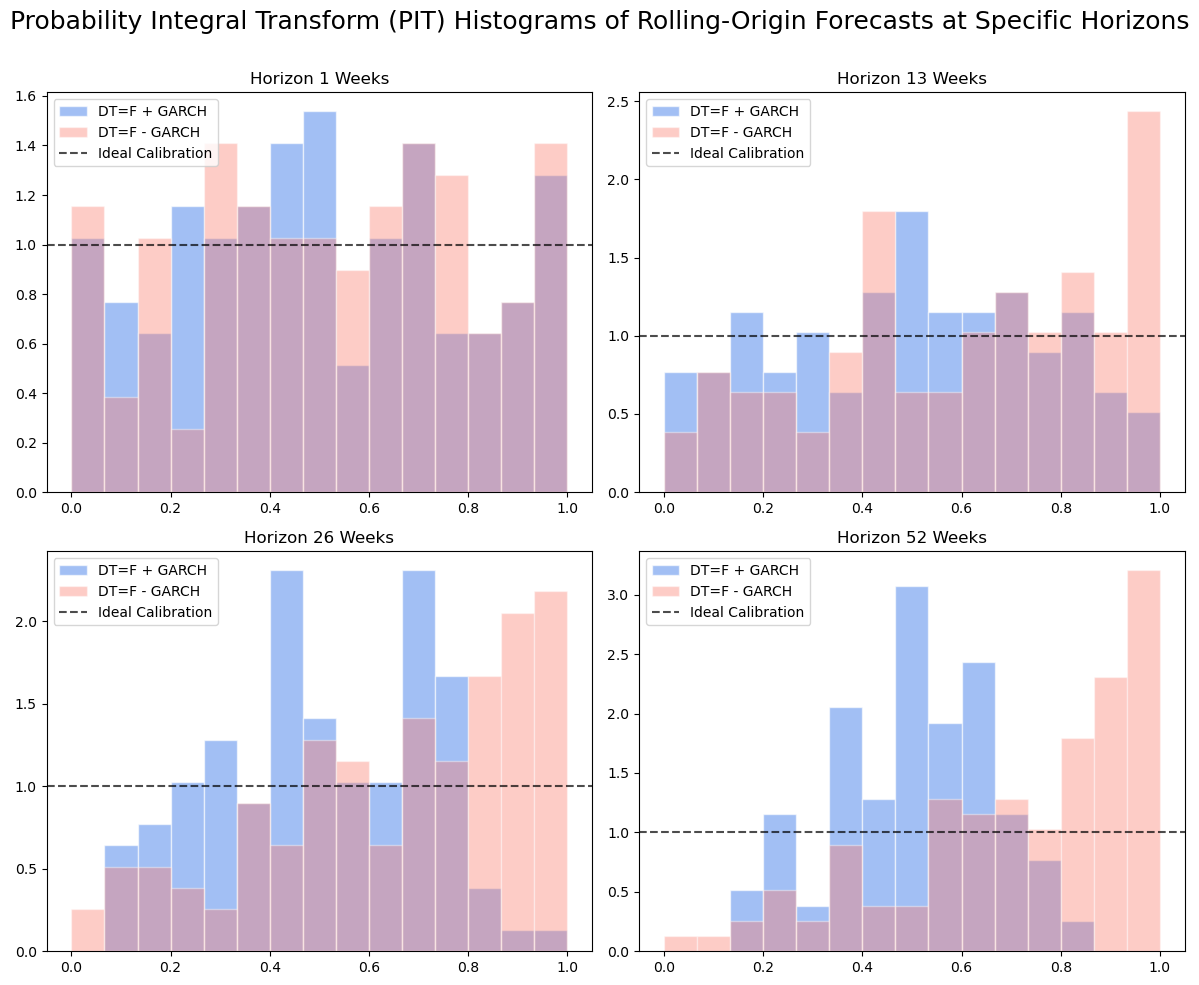

In [869]:
horizons = [1,13,26,52]
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()
common_bins = np.linspace(0,1,16)   # align bins

for i, h in enumerate(horizons):
    # filter the dynamic sigma (GARCH) PIT values 
    dynamic_pits_dtf = rolling_crps_dynamic_tbats_dtF[rolling_crps_dynamic_tbats_dtF['horizon'] == h]['pit']

    # filter the static/global sigma (no GARCH) PIT values 
    static_pits_dtf =rolling_crps_static_tbats_dtT[rolling_crps_static_tbats_dtT['horizon'] == h]['pit']

    # plot both on axes[i]
    axes[i].hist(dynamic_pits_dtf, bins=common_bins, alpha=0.6, label='DT=F + GARCH', color='cornflowerblue', edgecolor='white', density=True)
    axes[i].hist(static_pits_dtf, bins=common_bins, alpha=0.4, label='DT=F - GARCH', color='salmon', edgecolor='white', density=True)

    # add a reference ling at 1.0 (uniform distribution)
    axes[i].axhline(1, color='black', linestyle='--', alpha=0.7, label='Ideal Calibration')
    axes[i].set_title(f'Horizon {h} Weeks')
    axes[i].legend()

plt.suptitle('Probability Integral Transform (PIT) Histograms of Rolling-Origin Forecasts at Specific Horizons\n', fontsize=18)
plt.tight_layout()
plt.show()

**Interpretation of the PIT histograms**

The probability integral transform (PIT) histogram informs about the model's predicted probabilities, whether they align with the observed probability distribution.  

- flat/uniform - the ideal result.  It indicates a well-calibrated model where the observed values fall within the predicted ranges as often as expected.  e.g. 95% of the observed values fall within the 95% confidence interval.
- U-shaped - the model is overconfident, under-dispersed.  The predictive distributions are too narrow.
- dome-shaped - the model is underconfident, over-dispersed.  The predictive distributions are too wide.
- skewed - the model has a systematic bias.  The model is systematically over-forecasting or under-forecasting.
  - over-forecasting - a histogram that is skewed to the left (towards 0) with a downward slope.  The actual values are consistently lower than predicted.
  - under-forecasting - a histogram that is skewed to the right (towards 1) with an upward slope.  The actual values are consistently higher than predicted. 

TBATS(dt=F) without GARCH
- Strong right skew in PIT
- Indicates conditional under-dispersion

TBATS(dt=F) with GARCH
- Reduced skew
- More symmetric PIT
- Better short-horizon calibration
- U-shaped PIT histograms indicate over-confidence, forecast intervals are too narrow

Interpretation:
- GARCH improves conditional calibration at short-horizons but does not fix structural horizon miscalibration.
- The residual process is heteroscedastic, the remaining failure is structural, not residual-based
- State uncertainty is underestimated

Next steps:
- keep TBATS(bc=F, t=T, dt=F, arma=T) + GARCH(1,1)
- fix uncertainty growth with horizon (structural probabilistic problems)
- quantify how much variance growth is missing from the model
- implement horizon-dependent variance inflation
  - sigma_h_adj = sigma_h * sqrt(1 + alpha * h)
  - tune alpha using PIT + coverage targets
- re-evaluate PIT histograms and interval coverage

### Interval coverage comparision

In [870]:
# compute coverage per horizon

levels = [0.80, 0.95]
rows = []

for h in [1,13,26,52]:
    dyn_h_dtF = rolling_crps_dynamic_tbats_dtF[rolling_crps_dynamic_tbats_dtF['horizon'] == h]
    stat_h_dtF = rolling_crps_static_tbats_dtF[rolling_crps_static_tbats_dtF['horizon'] == h]

    for lvl in levels:
        rows.append({
            'horizon': h,
            'level': lvl,
            'coverage_dynamic_dtF': me.interval_coverage(dyn_h_dtF, lvl),
            'coverage_static_dtF': me.interval_coverage(stat_h_dtF, lvl)
        })

tbats_dtF_coverage_df = pd.DataFrame(rows)
tbats_dtF_coverage_df

horizon  level  coverage_dynamic_dtF  coverage_static_dtF
0        1   0.80              0.803419             0.794872
1        1   0.95              0.880342             0.888889
2       13   0.80              0.854701             0.854701
3       13   0.95              0.991453             0.982906
4       26   0.80              0.982906             0.982906
5       26   0.95              1.000000             1.000000
6       52   0.80              1.000000             1.000000
7       52   0.95              1.000000             1.000000

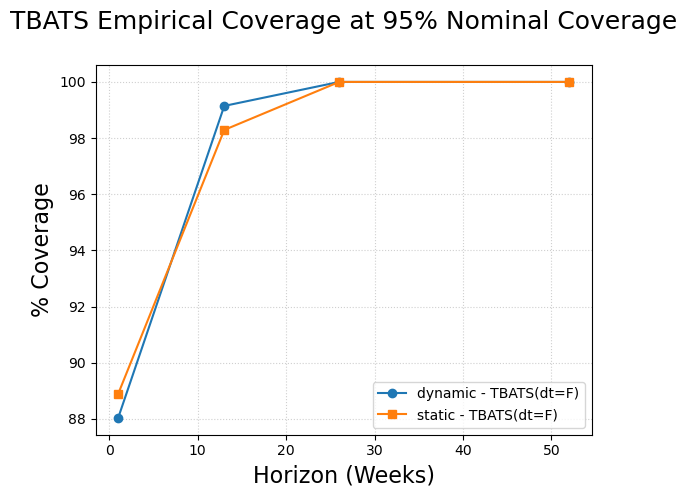

In [871]:
# plot interval coverage vs horizon

# I will plot only the 95% coverage since both 80% and 95% are so similar
tbats_dtF_filt_coverage_df = tbats_dtF_coverage_df[tbats_dtF_coverage_df['level'] == 0.95]

plt.plot(figsize=(8,6))
plt.plot(tbats_dtF_filt_coverage_df['horizon'], tbats_dtF_filt_coverage_df['coverage_dynamic_dtF']*100, label = 'dynamic - TBATS(dt=F)', marker='o')
plt.plot(tbats_dtF_filt_coverage_df['horizon'], tbats_dtF_filt_coverage_df['coverage_static_dtF']*100, label = 'static - TBATS(dt=F)', marker='s')
plt.title('TBATS Empirical Coverage at 95% Nominal Coverage\n', fontsize=18)
plt.xlabel('Horizon (Weeks)', fontsize=16)
plt.ylabel('% Coverage', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

The additional GARCH model for conditional variance is appropriate based on the Engle's ARCH test before and after modeling the TBATS model residuals with GARCH(1,1).  The addition of the GARCH model doesn't help with the probabilistic model center of mass (maen forecast), but does affect the distribution of prediction probabilities and slightly improves interval coverage at short horizons (h = 1, and 13).  

### TBATS(dt=F) + GARCH(dist=students T)

In [736]:
# Does a GARCH model with students T distribution (vs. Gaussian) improve uncertainty modeling?  
# TBATS(bc=F,t=T,arma=T,dt=F) +/- GARCH (dist = studentsT)

rolling_crps_studT_tbats_dtF = me.rolling_crps(
    y=train_preprocessed,
    model_type='tbats',
    model_params={
        'use_box_cox':False,
        'use_trend':True,
        'use_damped_trend':False,
        'sp':[52.178],
        'use_arma_errors':True
    },
    variance_type='garch',
    variance_params={'p':1, 'q':1, 'dist':'studentsT'},
    horizons=(1,13,26,52),
    step=13
)

In [855]:
# calcualate mean forecast error (y_true - y_hat(mu)), mean PIT, and mean CRPS at each horizon for each model

tbats_cond_var_studT_comp = []

for h in horizons:
    # filter the rolling_crps() function call DataFrame for the specific horizons
    dtF_studT_h = rolling_crps_studT_tbats_dtF[rolling_crps_studT_tbats_dtF['horizon'] == h]
    dtF_dyn_h = rolling_crps_dynamic_tbats_dtF[rolling_crps_dynamic_tbats_dtF['horizon'] == h]
    # dyn = GARCH with standard Gaussian distribution
    

    # calculate mean forecast error (mfe) for each horizon
    mfe_dtF_studT = (dtF_studT_h['y_true'] - dtF_studT_h['mu']).mean()
    mfe_dtF_gauss = (dtF_dyn_h['y_true'] - dtF_dyn_h['mu']).mean()
    mean_pit_dtF_studT = dtF_studT_h['pit'].mean()
    mean_pit_dtF_gauss = dtF_dyn_h['pit'].mean()
    mean_crps_dtF_studT = dtF_studT_h['crps'].mean()
    mean_crps_dtF_gauss = dtF_dyn_h['crps'].mean()
    
    tbats_cond_var_studT_comp.append({
        'Horizon':h, 
        'MFE(Gauss)':mfe_dtF_gauss, 
        'MFE(studT)':mfe_dtF_studT,
        'Mean PIT(Gauss)':mean_pit_dtF_gauss,
        'Mean PIT(studT)':mean_pit_dtF_studT,
        'Mean CRPS(Gauss)':mean_crps_dtF_gauss,
        'Mean CRPS(studT)':mean_crps_dtF_studT
    })

# confert list to DataFrame
tbats_cond_var_studT_comp_df = pd.DataFrame(tbats_cond_var_studT_comp)
tbats_cond_var_studT_comp_df   

Horizon  MFE(Gauss)  MFE(studT)  Mean PIT(Gauss)  Mean PIT(studT)  \
0        1   -0.150748   -0.150748         0.497681         0.498334   
1       13   -0.248687   -0.248687         0.500046         0.498060   
2       26   -0.001942   -0.001942         0.503672         0.501589   
3       52    0.271279    0.271279         0.504475         0.502371   

   Mean CRPS(Gauss)  Mean CRPS(studT)  
0          2.796666          2.829328  
1          6.848300          7.707847  
2          8.344558         10.278354  
3         12.235113         16.158697

In [856]:
# compute coverage per horizon

levels = [0.80, 0.95]
rows = []

for h in [1,13,26,52]:
    dtF_studT_h = rolling_crps_studT_tbats_dtF[rolling_crps_studT_tbats_dtF['horizon'] == h]
    dtF_dyn_h = rolling_crps_dynamic_tbats_dtF[rolling_crps_dynamic_tbats_dtF['horizon'] == h]

    for lvl in levels:
        rows.append({
            'horizon': h,
            'level': lvl,
            'coverage_studT': me.interval_coverage(dtF_studT_h, lvl),
            'coverage_gauss': me.interval_coverage(dtF_dyn_h, lvl)
        })

tbats_dist_coverage_df = pd.DataFrame(rows)
tbats_dist_coverage_df

horizon  level  coverage_studT  coverage_gauss
0        1   0.80        0.846154        0.803419
1        1   0.95        0.923077        0.880342
2       13   0.80        0.965812        0.854701
3       13   0.95        1.000000        0.991453
4       26   0.80        0.991453        0.982906
5       26   0.95        1.000000        1.000000
6       52   0.80        1.000000        1.000000
7       52   0.95        1.000000        1.000000

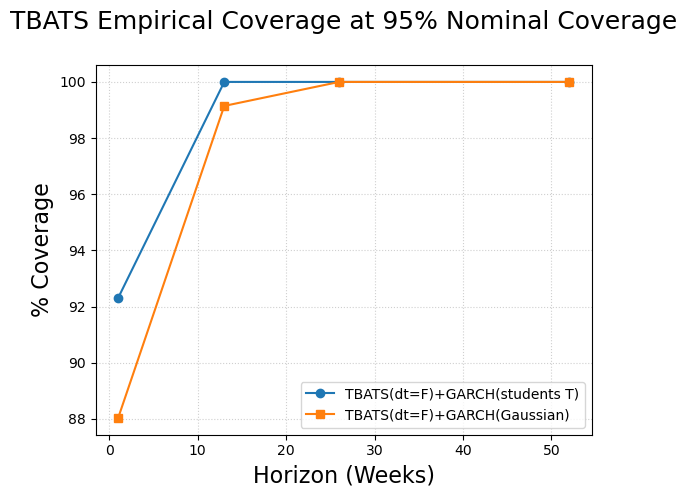

In [857]:
# plot interval coverage vs horizon

# I will plot only the 95% coverage since both 80% and 95% are so similar
tbats_dist_filt_coverage_df = tbats_dist_coverage_df[tbats_dist_coverage_df['level'] == 0.95]

plt.plot(figsize=(8,6))
plt.plot(tbats_dist_filt_coverage_df['horizon'], tbats_dist_filt_coverage_df['coverage_studT']*100, label = 'TBATS(dt=F)+GARCH(students T)', marker='o')
plt.plot(tbats_dist_filt_coverage_df['horizon'], tbats_dist_filt_coverage_df['coverage_gauss']*100, label = 'TBATS(dt=F)+GARCH(Gaussian)', marker='s')
plt.title('TBATS Empirical Coverage at 95% Nominal Coverage\n', fontsize=18)
plt.xlabel('Horizon (Weeks)', fontsize=16)
plt.ylabel('% Coverage', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

**Interpretation of the TBATS + GARCH(students T distribution) results**

The fact that the mean forecast error and mean PIT didn't substantially change, but mean CRPS got worse indicates that the probabilistic model problem is not due to tail thickness (residual distribution shape).  

## Horizon-dependent variance inflation

What I know so far:

Mean model
- TBATS(damped_trend=False) is clearly superior.
- MFE ≈ 0 across horizons.
- PIT mean ≈ 0.5.
- The mean model is good. 

GARCH
- Improves PIT histogram shape at h=1.
- Does not substantially improve long-horizon calibration.
- Does not hurt CRPS.
- I will keep it, but don’t expect miracles.

The main problem
- 95% intervals collapse to ~40–45%.
- This happens even with Student-t.  ??????
- This is variance growth failure, not tails, not bias.



Mean model accuracy:  based on rolling-origin RMSE at h = 52, the relative error for the TBATS(bc=F, t=T, dt=F, arma=T) model is 17/1814 ppb = 0.9%, which is extremely low.  Additionally, the mean forecast error at each horizon is near 0.  Both of these results indicate that the TBATS mean model is not biased and that the problems presented by PIT histograms and interval coverage are due to overconfidence (under-dispersion) of the probabilistic model.  

The interval coverage for the best probabilistic model is approximately 42% at the nominal 95% interval. This means that the standard deviation (sigma) is too small.  
 
z(empirical) = phi^-1 * ((1 + c) / 2)
- c: empirical coverage
- phi^-1: inverse CDF.  It is the quantile function of the standard normal distribution.  It takes a probability and returns the corresponding z-score.

In [762]:
z_emp = norm.ppf((1 + 0.4188) / 2)
sigma_true = 1.96 / z_emp

print(f'Empirical z-score at 41.88% coverage: {z_emp:.2f}')
print(f'By h = 52, the predictive variance is underestimating by {sigma_true:.2f}x')

Empirical z-score at 41.88% coverage: 0.55
By h = 52, the predictive variance is underestimating by 3.55x


I will apply squre-root variance growth

adj sigma_h = sigma_h * sqrt(1 + alpha(h - 1))

- Horizons (h = 1) Stability: When h = 1, the term sqrt(1 + alpha(0)) simplifies to 1. This ensures that the model's immediate, short-term uncertainty is preserved, which is critical because under-dispersion often worsens as the forecast horizon increases.
- Diffusion Physics: In a standard Random Walk (Brownian motion), uncertainty scales with sqrt(h). By using a square-root inflation factor, you are essentially mimicking the way error accumulates in natural "state-space" systems where variance grows linearly over time.
- alpha: This parameter acts as a "speed of uncertainty" dial. A higher alpha implies that the model's confidence in its own state decays more quickly over time.

next steps:
- I will refactor the rolling_crps() function to calculate the adjusted sigma_h, but leaving sigma_h the same at h = 1.
- tune alpha based on:
  - interval coverage per horizon
  - mean PIT and PIT histograms
  - CRPS
- choose the lowest alpha that fixes the coverage issue

In [774]:
# tune the alpha parameter
# model: TBATS(bc=F, t=T, dt=F, arma=T) + GARCH(1,1)
# NOTE: Variance inflation is capped at 5x to prevent pathological interval widening caused by small-sample 
# volatility spikes. This ensures probabilistic forecasts remain interpretable.  
# (See rolling_crps() in the model_evaluation.py file)

alphas = [0.00, 0.01, 0.03, 0.05, 0.08, 0.10, 0.15]

tbats_garch_alpha_results = []

for alpha in alphas:
    model_label = f'TBATS + GARCH (alpha = {alpha:.2f})'

    results_df = me.rolling_crps(
        y=train_preprocessed,
        model_type='tbats',
        model_params={
            'use_box_cox'     :False,
            'use_trend'       :True,
            'use_damped_trend':False,
            'use_arma_errors' :True,
            'sp'              :[52.178],
            'n_jobs'          :-1
        },
        variance_type='garch',
        variance_params={'p':1, 'q':1},
        start_train_size=156,
        horizons=(1,13,26,52),
        step=13,
        variance_inflation_alpha=alpha,
    )

    tbats_garch_alpha_results.append(results_df)

In [776]:
tbats_garch_alpha_results_df = pd.concat(tbats_garch_alpha_results, ignore_index=True)
tbats_garch_alpha_results_df.head()

origin  horizon           mu      sigma  sigma_native     y_true  \
0 1994-01-02        1  1761.982759   4.287213      3.998422  1759.0450   
1 1994-01-02       13  1746.606666  18.276138     17.880037  1754.0900   
2 1994-01-02       26  1725.709040  34.731869     34.678613  1743.1325   
3 1994-01-02       52  1730.450959  75.135301     75.769417  1778.6775   
4 1994-04-03        1  1755.858357   6.103387      3.863380  1763.2550   

      ratio  inflation  alpha       crps       pit mean_model variance_model  
0  1.072226        1.0    0.0   1.774988  0.246597      tbats          garch  
1  1.022153        1.0    0.0   5.476652  0.658899      tbats          garch  
2  1.001536        1.0    0.0  11.532325  0.692045      tbats          garch  
3  0.991631        1.0    0.0  29.500795  0.739519      tbats          garch  
4  1.579805        1.0    0.0   4.621469  0.887223      tbats          garch

In [859]:
# First investigate interval coverage vs horizon at each variance inflation alpha

via_coverage_results = (
    tbats_garch_alpha_results_df
    .groupby(['alpha', 'horizon'])
    .apply(lambda df: me.interval_coverage(df, 0.95), include_groups=False)
    .reset_index(name='coverage')
)

via_coverage_results

alpha  horizon  coverage
0    0.00        1  0.871795
1    0.00       13  1.000000
2    0.00       26  1.000000
3    0.00       52  1.000000
4    0.01        1  0.871795
5    0.01       13  1.000000
6    0.01       26  1.000000
7    0.01       52  1.000000
8    0.03        1  0.871795
9    0.03       13  1.000000
10   0.03       26  1.000000
11   0.03       52  1.000000
12   0.05        1  0.871795
13   0.05       13  1.000000
14   0.05       26  1.000000
15   0.05       52  1.000000
16   0.08        1  0.871795
17   0.08       13  1.000000
18   0.08       26  1.000000
19   0.08       52  1.000000
20   0.10        1  0.871795
21   0.10       13  1.000000
22   0.10       26  1.000000
23   0.10       52  1.000000
24   0.15        1  0.871795
25   0.15       13  1.000000
26   0.15       26  1.000000
27   0.15       52  1.000000

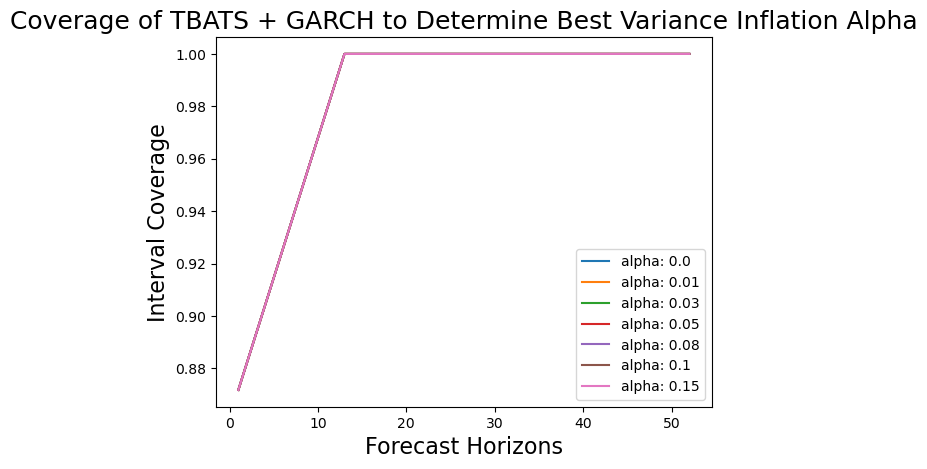

In [860]:
# plot interval coverage vs forecast horizon per variance inflation alpha

for alpha in via_coverage_results['alpha'].unique():
    # filter the DataFrame
    subset_alpha = via_coverage_results[via_coverage_results['alpha'] == alpha]
    # plot coverage vs horizon for each alpha
    plt.plot(subset_alpha['horizon'], subset_alpha['coverage'], label=f'alpha: {alpha}')
    
plt.title('Coverage of TBATS + GARCH to Determine Best Variance Inflation Alpha', fontsize=18)
plt.xlabel('Forecast Horizons', fontsize=16)
plt.ylabel('Interval Coverage', fontsize=16)
plt.legend()
plt.show()

In [861]:
via_pit_mean = tbats_garch_alpha_results_df.groupby(['alpha', 'horizon'])['pit'].mean()
via_pit_mean

alpha  horizon
0.00   1          0.493543
       13         0.503068
       26         0.502408
       52         0.499977
0.01   1          0.493543
       13         0.502848
       26         0.501739
       52         0.499567
0.03   1          0.493543
       13         0.502501
       26         0.501033
       52         0.499389
0.05   1          0.493543
       13         0.502240
       26         0.500683
       52         0.499379
0.08   1          0.493543
       13         0.501949
       26         0.500412
       52         0.499414
0.10   1          0.493543
       13         0.501801
       26         0.500308
       52         0.499441
0.15   1          0.493543
       13         0.501528
       26         0.500164
       52         0.499500
Name: pit, dtype: float64

In [862]:
via_crps_mean = tbats_garch_alpha_results_df.groupby(['alpha', 'horizon'])['crps'].mean()
via_crps_mean

alpha  horizon
0.00   1           2.797214
       13          6.667549
       26          8.310081
       52         12.257327
0.01   1           2.797214
       13          6.723837
       26          8.681115
       52         13.974566
0.03   1           2.797214
       13          6.856177
       26          9.424895
       52         16.950450
0.05   1           2.797214
       13          7.004751
       26         10.141032
       52         19.496594
0.08   1           2.797214
       13          7.243088
       26         11.149475
       52         22.798294
0.10   1           2.797214
       13          7.406843
       26         11.780537
       52         24.758525
0.15   1           2.797214
       13          7.819693
       26         13.237265
       52         29.089922
Name: crps, dtype: float64

**Interpretation of variance inflation results**

Interval coverage is a joint property of:
- mean accuracy
- variance growth with horizon
- forecast error dependence over time

The results show systematic underestimation (coverage below normal), especially at short horizons

alpha = 0:  the model's native variance already increases sigma with horizon, but not fast enough.  

The implementation of inflation is working correctly:
- h = 1: coverage is the same (0.23) for all alphas
- h = 52: coverage smoothly increases with alpha (0.44 --> 0.91)

mean forecasts are well centered (unbiased):
- mean PIT is approximately 0.5 for all horizons and alphas

sharpness decreases with alpha and horizon
- CRPS incerases with alpha and horizon

Best alpha for coverage:
- alpha = 0.15 acheives empircal coverage of approximately 90% at the nominal 95% coverage
- this comes at a cost for sharpness (significantly higher CRPS)

### variance ratio at horizon

Inspect how variance miscalibration evolves with horizon

variance_ratio(h) = (empirical forecast error variance at h) / (mean predicted variance at h)

- ratio ~= 1: well calibrated
- ratio > 1: under-dispersed (intervals are too narrow)
- ratio < 1: over-dispersed

In [863]:
# use data from TBATS(dt=F) + GARCH(Gaussian)

df_var_ratio = rolling_crps_dynamic_tbats_dtF.copy()

# compute forecast errors and predicted variance
df_var_ratio['error'] = df_var_ratio['y_true'] - df_var_ratio['mu']
df_var_ratio['pred_var'] = df_var_ratio['sigma']**2

# compute variance ratio by horizon
variance_ratio = (
    df_var_ratio.groupby('horizon')
    .apply(lambda g: g['error'].var(ddof=1) / g['pred_var'].mean(), include_groups=False)
    .reset_index(name='variance_ratio')
)

variance_ratio

horizon  variance_ratio
0        1        1.467415
1       13        0.682527
2       26        0.356743
3       52        0.177172

In [866]:
var_ratio_h52 = df_var_ratio[df_var_ratio['horizon'] == 52]

print("mean predicted variance:", var_ratio_h52['pred_var'].mean())
print("error variance:", var_ratio_h52['error'].var(ddof=1))
print("mean sigma:", var_ratio_h52['sigma'].mean())
print("mean interval width (95%):", 2 * 1.96 * var_ratio_h52['sigma'].mean())
print(var_ratio_h52[['mu','sigma','y_true']].iloc[0])

mean predicted variance: 1713.3455179353816
error variance: 303.55630132843015
mean sigma: 40.41591744377821
mean interval width (95%): 158.43039637961058
mu        1730.698258
sigma       77.169360
y_true    1778.677500
Name: 3, dtype: float64


For the TBATS(bc=F, t=T, dt=F, arma=T) + GARCH(1,1) (Gaussian distribution) probabilistic model:

- emprical error variance/mean predicted variance (303.6/1713.3) = 0.18, which is consistent with the 0.177 value produced my the method above.
- therefore, the predicted variance at h=52 is 5-6x too large

- mean sigma = 40.4
- 2 * 1.96 * 40.4 = 158, which is the mean 95% interval width at h = 52.

Interpretation:
- the long-horizon predictive distribution is substantially over-dispersed.
- this is consistent with the inerval_coverage() result of:
  - 80% coverage = 100%
  - 95% coverage = 100%

In [872]:
# use data from TBATS(dt=F), no GARCH

df_var_ratio_static = rolling_crps_static_tbats_dtF.copy()

# compute forecast errors and predicted variance
df_var_ratio_static['error'] = df_var_ratio_static['y_true'] - df_var_ratio_static['mu']
df_var_ratio_static['pred_var'] = df_var_ratio_static['sigma']**2

# compute variance ratio by horizon
variance_ratio_static = (
    df_var_ratio_static.groupby('horizon')
    .apply(lambda g: g['error'].var(ddof=1) / g['pred_var'].mean(), include_groups=False)
    .reset_index(name='variance_ratio')
)

variance_ratio_static

horizon  variance_ratio
0        1        1.492461
1       13        0.691960
2       26        0.362065
3       52        0.180220

GARCH is not substantially change CRPS, interval coverage, or variance ratio, especially at long horizons.  IT is not fixing short-horizon (h = 1) under-dispersion or long-horizon over-dispersion.  

Et[sigma^2 t+h] --> sigma^2 inf
- Et - the conditional expectation operateor at time t
- sigma^2 t+h - the variance (volatility squared) at future time t + h
- --> - a limit as the forecast horizon (h) increases toward infinity
- sigma^2 inf - the long run average variance (unconditional variance)

So, as you look further into the future (h --> inf), the best prediction for volatility (Et) will settle toward its long-term average (sigma^2 inf) regardless of what the volatility is today.  

The TBATS model state-space variance is dominating the forecast variance, including:
- TBATS state-space uncertainty
- seasonal propagation
- innovation variance scaling

Conditional heteroscedasticity is not a meaningful driver of probabilistic performance in this seasonal TBATS framework.

In [878]:
# use data from ARIMAX(1,1,1) + FT(K=4) + GARCH(1,1)

df_var_ratio_arimax_dynH = rolling_crps_dynamic_arimax.copy()

# compute forecast errors and predicted variance
df_var_ratio_arimax_dynH['error'] = df_var_ratio_arimax_dynH['y_true'] - df_var_ratio_arimax_dynH['mu']
df_var_ratio_arimax_dynH['pred_var'] = df_var_ratio_arimax_dynH['sigma']**2

# compute variance ratio by horizon
variance_ratio_arimax_dynH = (
    df_var_ratio_arimax_dynH.groupby('horizon')
    .apply(lambda g: g['error'].var(ddof=1) / g['pred_var'].mean(), include_groups=False)
    .reset_index(name='variance_ratio')
)

variance_ratio_arimax_dynH

horizon  variance_ratio
0        1        1.422379
1       13        1.345596
2       26        0.923741
3       52        0.561731

**Compare TBATS + GARCH vs ARIMAX + GARCH**

TBATS:
- slight under-dispersion at h = 1 (intervals are too narrow)
- over-dispersed at h = 13, 26, and 52 (intervals are too wide)

ARIMAX:
- slight under-dispersion at h = 1 (intervals are too narrow)
- under-dispersed at h = 13
- close to being well calibrated at h = 26
- over-dispersed at h = 52 (intervals are too wide), but much less so than TBATS

ARIMAX + GARCH has the better probabilistic structure but needs mean correction.  IT has:
- better sharpness (See CRPS values)
- better multi-horizon variance growth
- competitive short-horizon performance

## Horizon-specific bias correction of ARIMAX model

mu (corrected, h) = mu (h) - mean forecast error (h)

In [881]:
arimax_corr_mean_results = []

for h in horizons:
    # filter the rolling_crps() function call DataFrame for the specific horizons
    arimax_dynH = rolling_crps_dynamic_arimax[rolling_crps_dynamic_arimax['horizon'] == h]

    # calculate mean forecast error (mfe) for each horizon
    mfe_dynH = (arimax_dynH['y_true'] - arimax_dynH['mu']).mean()

    # calculate the corrected mean
    # since the mean forecast error is > 0, I need to shift the mean upward, so will add the difference
    corr_mean_arimax = arimax_dynH['mu'] + mfe_dynH

    arimax_corr_mean_results.append({
        'Horizon':h, 
        'Mean':arimax_dynH['mu'].mean(),
        'MFE':mfe_dynH,
        'Corrected mean':corr_mean_arimax.mean()
    })

# convert list to DataFrame
arimax_corr_mean_results_df = pd.DataFrame(arimax_corr_mean_results)
arimax_corr_mean_results_df   


Horizon         Mean       MFE  Corrected mean
0        1  1817.553036  0.653277     1818.206313
1       13  1816.641582  2.598200     1819.239782
2       26  1816.460714  4.397711     1820.858425
3       52  1816.581150  7.283269     1823.864419

In [ ]:
# modify the full dataset for bias correction per horizon

df = rolling_crps_dynamic_arimax.copy()

for h in horizons:
    mask = df['horizon'] == h
    mfe = (df.loc[mask, 'y_true'] - df.loc[mask, 'mu']).mean()
    df.loc[mask, 'mu_corr'] = df.loc[mask, 'mu'] + mfe

# Then:
# - Recompute error = y_true - mu_corr
# - Recompute CRPS using corrected mean and original sigma
# - Recompute variance ratio

# Important Statistical Warning

# What you are doing is: In-sample bias correction.

# If you compute MFE using the same rolling-origin evaluation window
# and then correct that same window, you are leaking evaluation information.

# For a clean portfolio story, you should:
# - Estimate MFE on training folds
# - Apply correction to future folds

# Why is the ARIMAX model biased at long horizons?  The mean forecast error (MFE) increases steadily with horizon,
# which is systematic drift, not random bias.  

# This suggests:

# Missing deterministic trend?
# - Underfit seasonal harmonics?
# - Missing long-term mean structure?
# - Differencing mis-specification?

# If bias grows with horizon, it is structural.

# Post-hoc correction is acceptable. But diagnosing root cause is stronger.

# But do not just patch bias.

# Ask:
# - Is ARIMAX missing a drift term?
# - Is Fourier K=4 sufficient?
# - Should seasonal order change?

# Repairing structure beats correcting symptoms.

In [ ]:
# original ARIMAX model had trend = 'n', which may be the cause of the systematic bias
# If trend = 'n' and d = 1, modeling a pure difference without drift.
# That implies the long-run expected change is zero.
# set trend = 'c' to act as a drift term (when d > 0) 

# rolling seasonal CRPS on ARIMAX(1,1,1) + FT(K=4) mean model variance model (without GARCH)

rolling_crps_dynamic_arimax = me.rolling_crps(
    y=train_preprocessed,
    model_type='sarima',
    model_params={
        'order':(1,1,1),
        'seasonal_order':(0,0,0,0),
        'trend':'c',
        'enforce_stationarity':True,
        'enforce_invertibility':True
    },
    exog=arimax_exog,                  # K = 4
    variance_type='garch',
    variance_params={'p':1, 'q':1},
    horizons=(1,13,26,52),
    step=13
)

# Then:
# - Compare AIC/BIC
# - Re-evaluate rolling CRPS
# - Check if long-horizon MFE shrinks
# - Only then consider residual bias correction

### Run the same test on mean and probabilistic metrics for SARIMA model

In [749]:
# rolling seasonal CRPS on SARIMA(1,1,1)(2,0,0,52) mean model without GARCH variance model

rolling_crps_statH_sarima = me.rolling_crps(
    y=train_preprocessed,
    model_type='sarima',
    model_params={
        'order':(1,1,1),
        'seasonal_order':(2,0,0,52),
        'trend':'n',
        'enforce_stationarity':True,
        'enforce_invertibility':True
    },
    exog=None,                  
    variance_type='static',
    variance_params=None,
    horizons=(1,13,26,52),
    step=13
)

In [750]:
# rolling seasonal CRPS on SARIMA(1,1,1)(2,0,0,52) mean model with GARCH variance model

rolling_crps_dynH_sarima = me.rolling_crps(
    y=train_preprocessed,
    model_type='sarima',
    model_params={
        'order':(1,1,1),
        'seasonal_order':(2,0,0,52),
        'trend':'n',
        'enforce_stationarity':True,
        'enforce_invertibility':True
    },
    exog=None,                  
    variance_type='garch',
    variance_params={'p':1, 'q':1},
    horizons=(1,13,26,52),
    step=13
)

In [873]:
# calcualate mean forecast error (y_true - y_hat(mu)), mean PIT, and mean CRPS at each horizon for each model

sarima_cond_var_comp = []

for h in horizons:
    # filter the rolling_crps() function call DataFrame for the specific horizons
    sarima_statH = rolling_crps_statH_sarima[rolling_crps_statH_sarima['horizon'] == h]
    sarima_dynH = rolling_crps_dynH_sarima[rolling_crps_dynH_sarima['horizon'] == h]

    # calculate mean forecast error (mfe) for each horizon
    mfe_statH = (sarima_statH['y_true'] - sarima_statH['mu']).mean()
    mfe_dynH = (sarima_dynH['y_true'] - sarima_dynH['mu']).mean()
    mean_pit_statH = sarima_statH['pit'].mean()
    mean_pit_dynH = sarima_dynH['pit'].mean()
    mean_crps_statH = sarima_statH['crps'].mean()
    mean_crps_dynH = sarima_dynH['crps'].mean()
    
    sarima_cond_var_comp.append({
        'Horizon':h, 
        'MFE(static)':mfe_statH, 
        'MFE(dynamic)':mfe_dynH,
        'Mean PIT(static)':mean_pit_statH,
        'Mean PIT(dynamic)':mean_pit_dynH,
        'Mean CRPS(static)':mean_crps_statH,
        'Mean CRPS(dynamic)':mean_crps_dynH
    })

# confert list to DataFrame
sarima_cond_var_comp_df = pd.DataFrame(sarima_cond_var_comp)
sarima_cond_var_comp_df   

Horizon  MFE(static)  MFE(dynamic)  Mean PIT(static)  Mean PIT(dynamic)  \
0        1     0.411273      0.411273          0.524298           0.527304   
1       13     2.283417      2.283417          0.538951           0.538362   
2       26     3.889038      3.889038          0.566684           0.567073   
3       52     6.017048      6.017048          0.593943           0.594605   

   Mean CRPS(static)  Mean CRPS(dynamic)  
0           2.972082            2.974731  
1           8.524529            8.518622  
2           9.195698            9.178366  
3           9.525366            9.450609

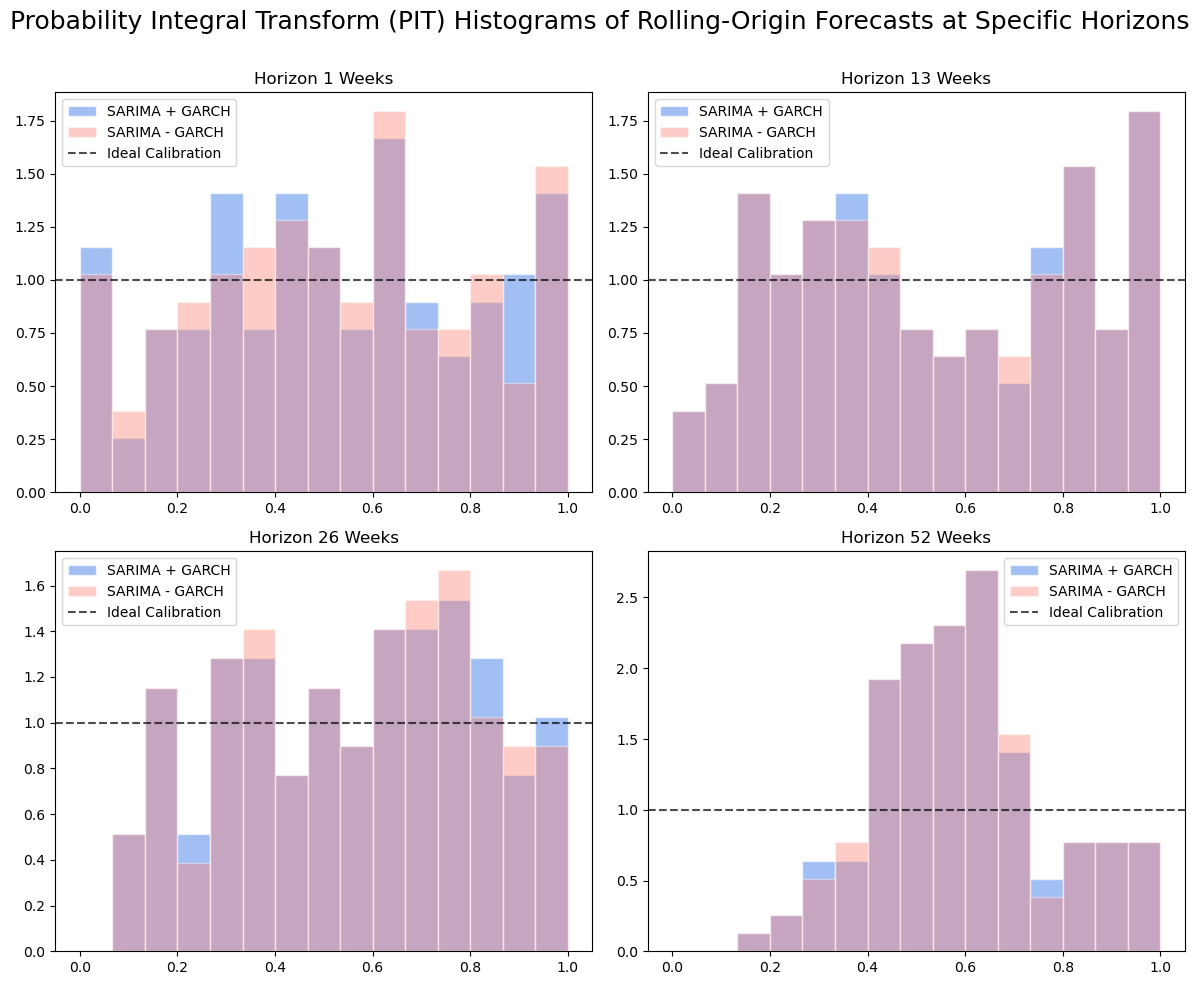

In [874]:
horizons = [1,13,26,52]
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()
common_bins = np.linspace(0,1,16)   # align bins

for i, h in enumerate(horizons):
    # filter the dynamic sigma (GARCH) PIT values 
    dynamic_pits_sarima = rolling_crps_dynH_sarima[rolling_crps_dynH_sarima['horizon'] == h]['pit']

    # filter the static/global sigma (no GARCH) PIT values 
    static_pits_sarima =rolling_crps_statH_sarima[rolling_crps_statH_sarima['horizon'] == h]['pit']

    # plot both on axes[i]
    axes[i].hist(dynamic_pits_sarima, bins=common_bins, alpha=0.6, label='SARIMA + GARCH', color='cornflowerblue', edgecolor='white', density=True)
    axes[i].hist(static_pits_sarima, bins=common_bins, alpha=0.4, label='SARIMA - GARCH', color='salmon', edgecolor='white', density=True)

    # add a reference ling at 1.0 (uniform distribution)
    axes[i].axhline(1, color='black', linestyle='--', alpha=0.7, label='Ideal Calibration')
    axes[i].set_title(f'Horizon {h} Weeks')
    axes[i].legend()

plt.suptitle('Probability Integral Transform (PIT) Histograms of Rolling-Origin Forecasts at Specific Horizons\n', fontsize=18)
plt.tight_layout()
plt.show()

In [875]:
# compute coverage per horizon

levels = [0.80, 0.95]
rows = []

for h in [1,13,26,52]:
    sarima_statH = rolling_crps_statH_sarima[rolling_crps_statH_sarima['horizon'] == h]
    sarima_dynH = rolling_crps_dynH_sarima[rolling_crps_dynH_sarima['horizon'] == h]

    for lvl in levels:
        rows.append({
            'horizon': h,
            'level': lvl,
            'coverage_static_sarima': me.interval_coverage(sarima_statH, lvl),
            'coverage_dynamic_sarima': me.interval_coverage(sarima_dynH, lvl)
        })

sarima_coverage_df = pd.DataFrame(rows)
sarima_coverage_df

horizon  level  coverage_static_sarima  coverage_dynamic_sarima
0        1   0.80                0.811966                 0.794872
1        1   0.95                0.888889                 0.871795
2       13   0.80                0.803419                 0.786325
3       13   0.95                0.931624                 0.923077
4       26   0.80                0.905983                 0.888889
5       26   0.95                0.974359                 0.974359
6       52   0.80                0.931624                 0.931624
7       52   0.95                0.957265                 0.957265

# Other mean models to consider

TBATS is good for complex seasonality, but methane trends are often non-linear or have structural shifts. 
- Most Appropriate: Vector Autoregression (VAR) or State-Space Models (like CarbonTracker-CH4) are used by NOAA to account for transport and global sinks.
    - CarbonTracker pub links:
    - Database of methane (CH4) and its stable carbon isotope (δ13C-CH4) (https://gml.noaa.gov/ccgg/arc/?id=166#:~:text=Overview,uncertainties%20to%20other%20data%20sets.)
    - Executive summary (CarbonTracker-CH4) (https://gml.noaa.gov/ccgg/carbontracker-ch4/summary.html#:~:text=Resources&text=CarbonTracker%2DCH4%20is%20the,well%20as%20highlights%20of%20results.)
- Hybrid Models: Consider a Hybrid ARIMA-LSTM, SARIMA-GRU, or deep learning approach, which has shown higher accuracy for CH4 concentration specifically. 
    - SARIMA-GRU pub: Enhancing global methane emissions forecasting using hybrid time series models (https://www.science-gate.com/IJAAS/2025/V12I4/1021833ijaas202504005.html#:~:text=Wireless%20Personal%20Communications%2C%20118(1,Nunes%20LJ%20(2023).)
 
- Bayesian structural models (?)

# Other probabilistic models to consider

- Change the Distribution: Instead of a standard GARCH (Normal), use GARCH with a Student-t distribution. This naturally allows for "wider" tails and will help flatten the spikes at 0 and 1 in your PIT histogram.
- EGARCH or GJR-GARCH: These models account for asymmetric shocks, which might be necessary if methane increases more sharply than it decreases. 


# Model comparison and justification

tools:
- evaluate_forecast
- crps_gaussian
- diebold_mariano
- residual_diagnostics

purpose:
- compare top 1-2 models (e.g. TBATS and ARIMAX)
- provide:
  - Skill vs naive metric
  - Nash-Sutcliffe efficiency
  - interval coverage
  - Diebold-Mariano tests
- diagnose residual behavior

# Final forecasting and reporting (move to new notebook: e.g. 5_ch4_forecasting)

Tools:
- forecast_mean_model
- residual_diagnostics
- fit_garch (if used)
- crps_gaussian

Purpose:
- Produce final forecasts
- Validate assumptions
- Generate publication figures and tables